# Prabal Ghosh



# Research Project

# Physically-Informed Machine Learning for Modelling the Dynamics of Plant-Pathogens Molecular Interactions

                Name - Prabal Ghosh
                Supervisor - Silvia Bottini
                Course- Research Project
                Msc Data Science and Artificial Intelligence (M2)
                Université Côte d’Azur, Sophia Antipolis, France




## Parametric ODE Model for Each Gene: dy/dt = α + β * y(t) + γ * t


In [1]:
# !pip install torchdiffeq

# Data preprocessing

In [1]:
# Data preprocessing
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import matplotlib.pyplot as plt

df = pd.read_csv('arabido_example_genes.csv')

print(df)
df.info()  # Check data types
df.describe()  # Statistical summary

print(df.columns)
# print(df.columns.tolist())




  Unnamed: 0  Hpa-NO_1d  Hpa-NO_2d  Hpa-NO_4d
0  AT5G40100  -0.447960  -0.560155  -5.091964
1  AT1G06930   1.778359   0.000000   0.000000
2  AT1G04470   0.000000   1.175150   0.000000
3  AT5G66730   0.055375   0.098435  -0.101757
4  AT2G38472   0.900000   0.500000   0.000000
5  AT2G38474   0.000000   0.500000   0.000000
6  AT2G38470   0.906000   0.906000   0.906000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  7 non-null      object 
 1   Hpa-NO_1d   7 non-null      float64
 2   Hpa-NO_2d   7 non-null      float64
 3   Hpa-NO_4d   7 non-null      float64
dtypes: float64(3), object(1)
memory usage: 356.0+ bytes
Index(['Unnamed: 0', 'Hpa-NO_1d', 'Hpa-NO_2d', 'Hpa-NO_4d'], dtype='object')


# 1. Neural ode (parametric) +Inverse Pinn



In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import matplotlib.pyplot as plt

print("Original Data:")
print(df)

# Time points (in days)
time_points = np.array([1.0, 2.0, 4.0], dtype=np.float32)  # Day1, Day2, Day4

# Extract gene expression data (each row is one gene)
gene_data = df[["Hpa-NO_1d", "Hpa-NO_2d", "Hpa-NO_4d"]].values

# Convert to PyTorch tensors
time_points_tensor = torch.tensor(time_points, dtype=torch.float32, requires_grad=True)
gene_data_tensor = torch.tensor(gene_data, dtype=torch.float32)

##############################################################################
# Parametric ODE Model for Each Gene: dy/dt = α + β * y(t) + γ * t
##############################################################################

class GeneParametricODE(nn.Module):
    def __init__(self):
        super(GeneParametricODE, self).__init__()
        # Learnable parameters: α, β, and γ
        self.alpha = nn.Parameter(torch.tensor(0.1))
        self.beta = nn.Parameter(torch.tensor(0.1))
        self.gamma = nn.Parameter(torch.tensor(0.1))

    def forward(self, t, y):
        # ODE: dy/dt = α + β * y(t) + γ * t
        return self.alpha + self.beta * y + self.gamma * t

# Create one ODE model per gene
num_genes = gene_data_tensor.shape[0]
ode_models = nn.ModuleList([GeneParametricODE() for _ in range(num_genes)])

##############################################################################
# Inverse PINN Loss Function (Data Loss + Physics Loss)
##############################################################################

def inverse_pinn_loss(ode_models, time_points, gene_data, lambda_physics=0.1):
    total_data_loss = 0.0
    total_physics_loss = 0.0
    n_genes = gene_data.shape[0]
    gene_losses = []  # List to store individual gene losses


    for i in range(n_genes):
        # Observed expression for gene i (shape: (num_time_points,))
        y_observed = gene_data[i]
        # Use the first time point as the initial condition
        y0 = y_observed[0].unsqueeze(0)  # shape: (1,)

        # Solve the ODE for gene i over the time points
        preds = odeint(ode_models[i], y0, time_points).squeeze()  # shape: (num_time_points,)

        # Data loss: Mean squared error between predictions and observed values
        data_loss = torch.mean((preds - y_observed)**2)

        # Physics loss: Enforce that the derivative from autograd matches the ODE output
        dy_dt_pred = torch.autograd.grad(
            outputs=preds,
            inputs=time_points,
            grad_outputs=torch.ones_like(preds),
            create_graph=True,
            retain_graph=True
        )[0]

        dy_dt_ode = []
        for t_val, p_val in zip(time_points, preds):
            deriv = ode_models[i](t_val, p_val.unsqueeze(0))
            dy_dt_ode.append(deriv.squeeze())
        dy_dt_ode = torch.stack(dy_dt_ode)

        physics_loss = torch.mean((dy_dt_pred - dy_dt_ode)**2)

        # Calculate total loss for this gene and add to list
        gene_loss = data_loss + lambda_physics * physics_loss
        gene_losses.append(gene_loss.item())  # Store as Python float


        total_data_loss += data_loss
        total_physics_loss += physics_loss

    avg_data_loss = total_data_loss / n_genes
    avg_physics_loss = total_physics_loss / n_genes
    total_loss = avg_data_loss + lambda_physics * avg_physics_loss
    return total_loss, avg_data_loss, avg_physics_loss, gene_losses


Original Data:
  Unnamed: 0  Hpa-NO_1d  Hpa-NO_2d  Hpa-NO_4d
0  AT5G40100  -0.447960  -0.560155  -5.091964
1  AT1G06930   1.778359   0.000000   0.000000
2  AT1G04470   0.000000   1.175150   0.000000
3  AT5G66730   0.055375   0.098435  -0.101757
4  AT2G38472   0.900000   0.500000   0.000000
5  AT2G38474   0.000000   0.500000   0.000000
6  AT2G38470   0.906000   0.906000   0.906000


In [4]:

# ##############################################################################
# # Training Loop
# ##############################################################################

# optimizer = optim.Adam(ode_models.parameters(), lr=0.01)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

# epochs = 1000

# for epoch in range(epochs):
#     optimizer.zero_grad()
#     total_loss, data_loss, physics_loss = inverse_pinn_loss(ode_models, time_points_tensor, gene_data_tensor, lambda_physics=0.1)
#     total_loss.backward()
#     optimizer.step()
#     scheduler.step()

#     if epoch % 100 == 0:
#         print(f"Epoch {epoch:4d} | Total Loss: {total_loss.item():.4f} | Data Loss: {data_loss.item():.4f} | Physics Loss: {physics_loss.item():.4f}")


In [3]:

##############################################################################
# Training Loop
##############################################################################

optimizer = optim.Adam(ode_models.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

epochs = 1000

# Track losses for all genes throughout training
all_gene_losses = [[] for _ in range(num_genes)]
total_losses = []

for epoch in range(epochs):
    optimizer.zero_grad()
    total_loss, data_loss, physics_loss, gene_losses = inverse_pinn_loss(
        ode_models, time_points_tensor, gene_data_tensor, lambda_physics=0.1
    )
    total_loss.backward()
    optimizer.step()
    scheduler.step()
    
    # Store losses for plotting
    total_losses.append(total_loss.item())
    for i, loss in enumerate(gene_losses):
        all_gene_losses[i].append(loss)
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch:4d} | Total Loss: {total_loss.item():.4f} | Data Loss: {data_loss.item():.4f} | Physics Loss: {physics_loss.item():.4f}")


Epoch    0 | Total Loss: 3.1150 | Data Loss: 3.0890 | Physics Loss: 0.2601
Epoch  100 | Total Loss: 0.2029 | Data Loss: 0.1498 | Physics Loss: 0.5309
Epoch  200 | Total Loss: 0.1867 | Data Loss: 0.1343 | Physics Loss: 0.5244
Epoch  300 | Total Loss: 0.1780 | Data Loss: 0.1262 | Physics Loss: 0.5181
Epoch  400 | Total Loss: 0.1733 | Data Loss: 0.1218 | Physics Loss: 0.5148
Epoch  500 | Total Loss: 0.1707 | Data Loss: 0.1194 | Physics Loss: 0.5129
Epoch  600 | Total Loss: 0.1693 | Data Loss: 0.1181 | Physics Loss: 0.5119
Epoch  700 | Total Loss: 0.1686 | Data Loss: 0.1174 | Physics Loss: 0.5114
Epoch  800 | Total Loss: 0.1682 | Data Loss: 0.1171 | Physics Loss: 0.5110
Epoch  900 | Total Loss: 0.1679 | Data Loss: 0.1169 | Physics Loss: 0.5109


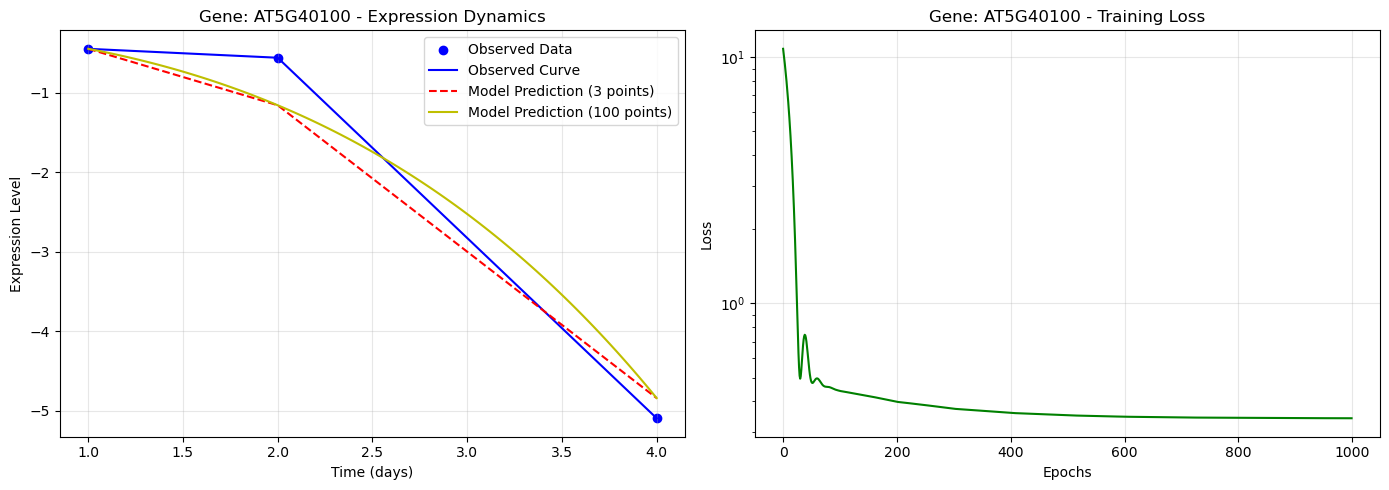

Learned ODE for Gene AT5G40100:
  dy/dt = -0.0036 + 0.3644 * y + -0.2866 * t
Formatted ODE Equation: dy/dt = -0.0036 + 0.3644 * y(t) + -0.2866 * t



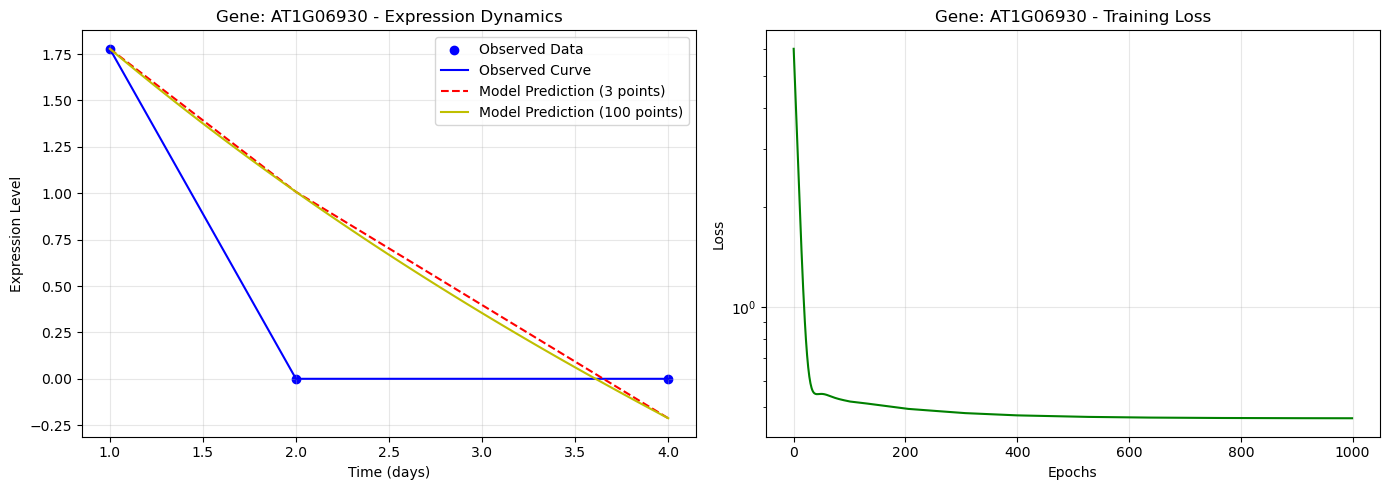

Learned ODE for Gene AT1G06930:
  dy/dt = -0.2060 + -0.3030 * y + -0.0975 * t
Formatted ODE Equation: dy/dt = -0.2060 + -0.3030 * y(t) + -0.0975 * t



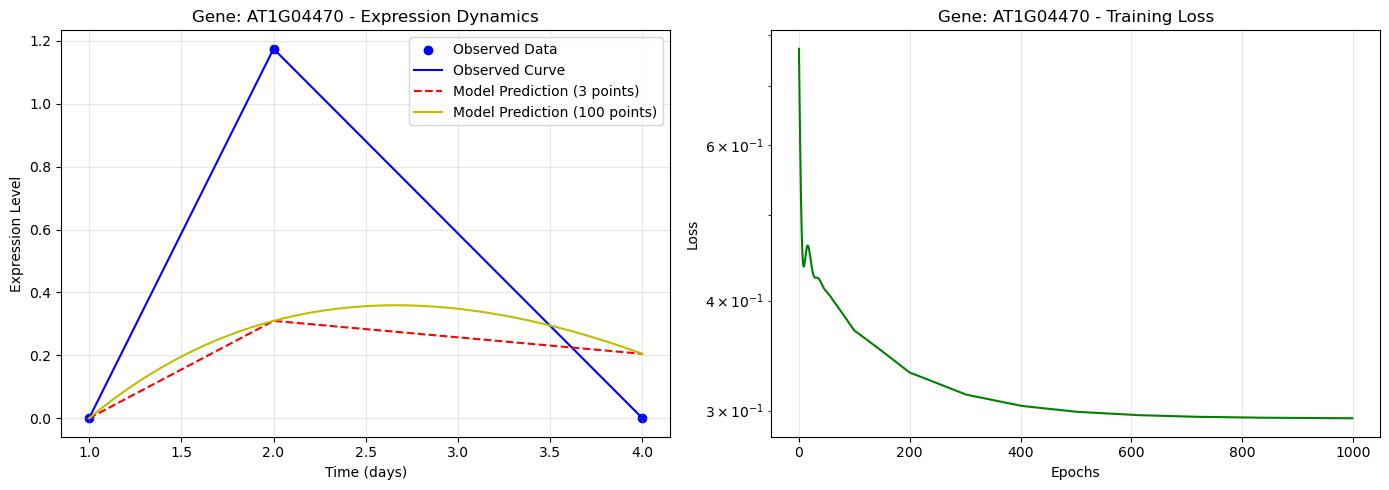

Learned ODE for Gene AT1G04470:
  dy/dt = 0.6907 + -0.4008 * y + -0.2052 * t
Formatted ODE Equation: dy/dt = 0.6907 + -0.4008 * y(t) + -0.2052 * t



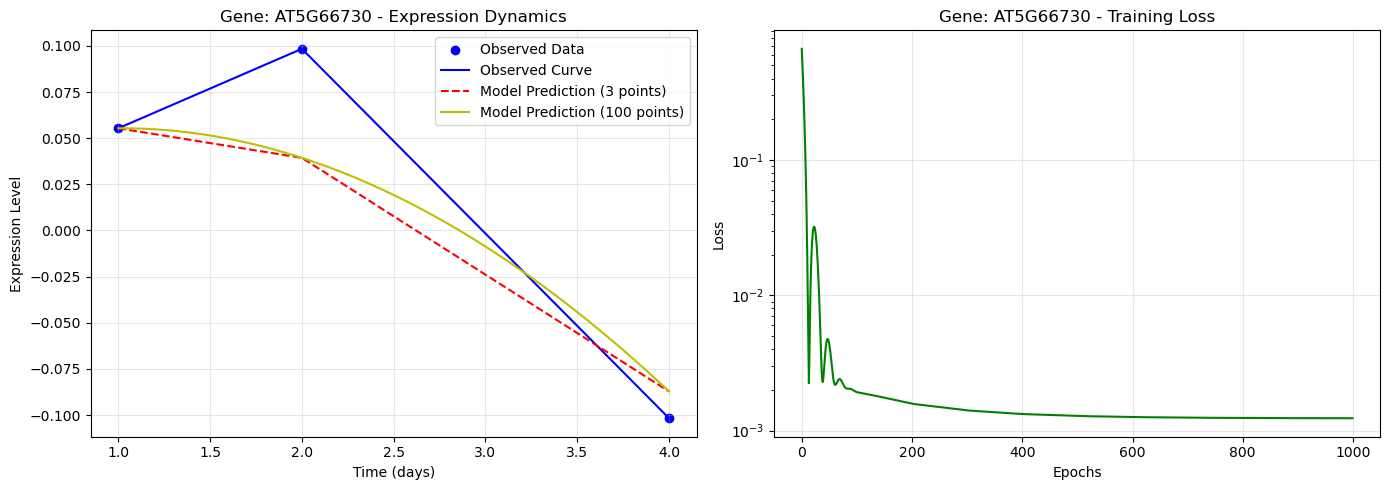

Learned ODE for Gene AT5G66730:
  dy/dt = 0.0368 + -0.0494 * y + -0.0336 * t
Formatted ODE Equation: dy/dt = 0.0368 + -0.0494 * y(t) + -0.0336 * t



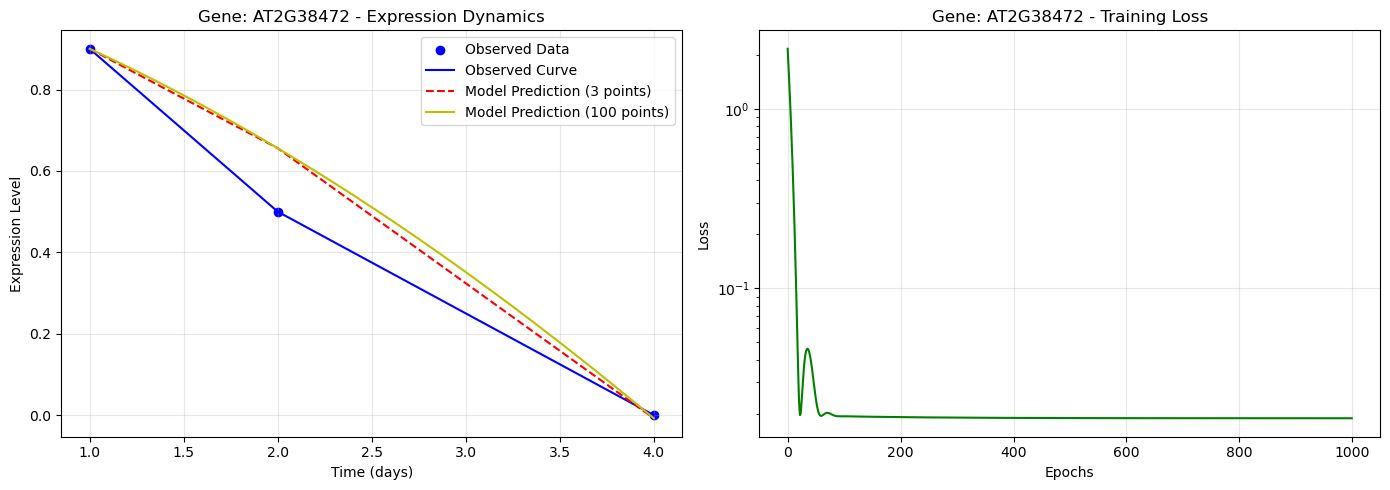

Learned ODE for Gene AT2G38472:
  dy/dt = -0.0479 + -0.0889 * y + -0.0845 * t
Formatted ODE Equation: dy/dt = -0.0479 + -0.0889 * y(t) + -0.0845 * t



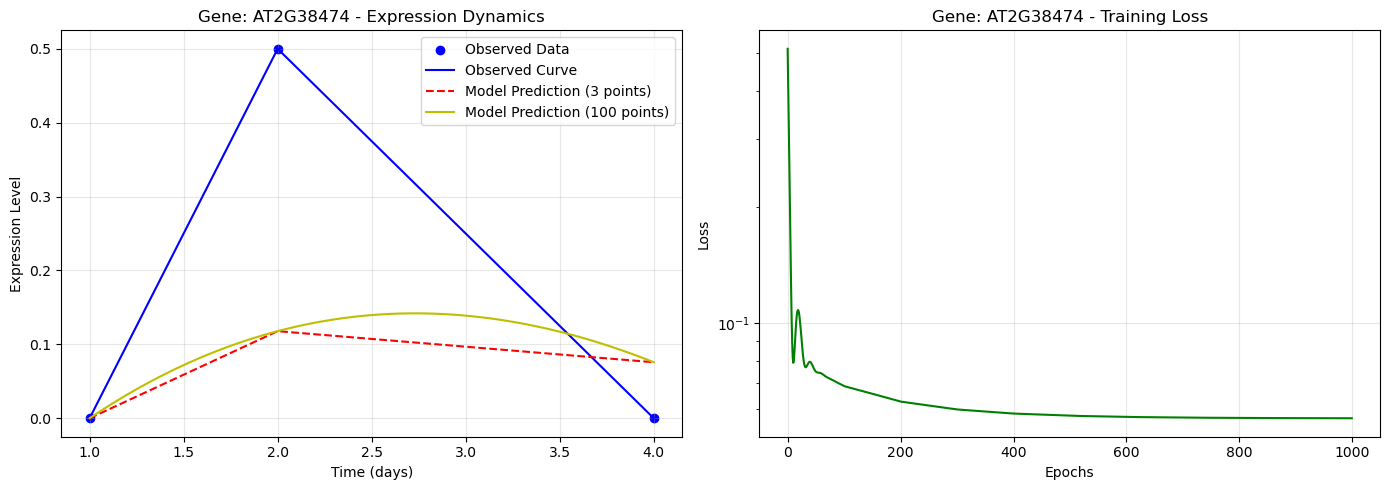

Learned ODE for Gene AT2G38474:
  dy/dt = 0.2582 + -0.1415 * y + -0.0872 * t
Formatted ODE Equation: dy/dt = 0.2582 + -0.1415 * y(t) + -0.0872 * t



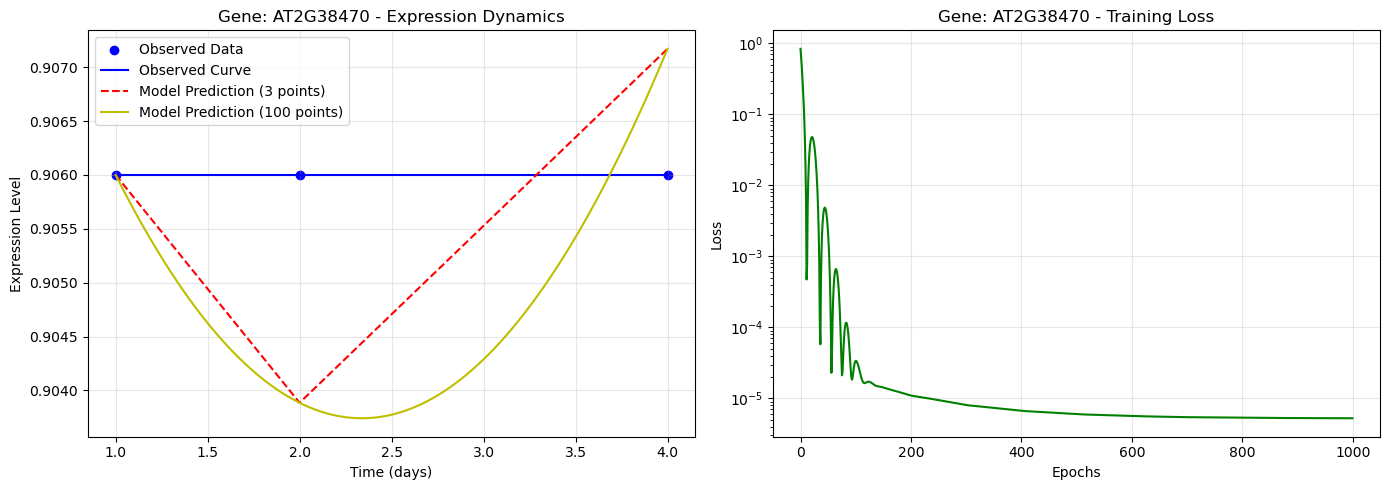

Learned ODE for Gene AT2G38470:
  dy/dt = 0.0086 + -0.0159 * y + 0.0025 * t
Formatted ODE Equation: dy/dt = 0.0086 + -0.0159 * y(t) + 0.0025 * t



In [4]:
fine_t = torch.linspace(1, 4, steps=100)

with torch.no_grad():
    for i, gene_id in enumerate(df['Unnamed: 0']):
        # Use the Day1 value as the initial condition for each gene
        y0 = gene_data_tensor[i, 0].unsqueeze(0)  # shape: (1,)
        preds = odeint(ode_models[i], y0, time_points_tensor).squeeze().numpy()
        y_pred = odeint(ode_models[i], y0, fine_t).squeeze().detach().numpy()
        
        # Create figure with two subplots side by side
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        # Plot 1: Predictions
        ax1.scatter(time_points, gene_data[i], c='b', label="Observed Data")
        ax1.plot(time_points, gene_data[i], 'b-', label="Observed Curve")
        ax1.plot(time_points, preds, 'r--', label="Model Prediction (3 points)")
        ax1.plot(fine_t.numpy(), y_pred, 'y-', label='Model Prediction (100 points)')
        ax1.set_title(f"Gene: {gene_id} - Expression Dynamics")
        ax1.set_xlabel("Time (days)")
        ax1.set_ylabel("Expression Level")
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Loss function
        ax2.plot(range(epochs), all_gene_losses[i], 'g-')
        ax2.set_title(f"Gene: {gene_id} - Training Loss")
        ax2.set_xlabel("Epochs")
        ax2.set_ylabel("Loss")
        ax2.set_yscale('log')  # Log scale for better visualization
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Print learned parameters for the gene
        model = ode_models[i]
        alpha = model.alpha.item()
        beta = model.beta.item()
        gamma = model.gamma.item()
        print(f"Learned ODE for Gene {gene_id}:")
        print(f"  dy/dt = {alpha:.4f} + {beta:.4f} * y + {gamma:.4f} * t")
        print(f"Formatted ODE Equation: dy/dt = {alpha:.4f} + {beta:.4f} * y(t) + {gamma:.4f} * t\n")

In [5]:
n_genes = gene_data_tensor.shape[0]


Learned Parameters:
        Gene     alpha      beta     gamma
0  AT5G40100 -0.003555  0.364435 -0.286588
1  AT1G06930 -0.205956 -0.302995 -0.097479
2  AT1G04470  0.690664 -0.400836 -0.205206
3  AT5G66730  0.036836 -0.049357 -0.033600
4  AT2G38472 -0.047874 -0.088919 -0.084477
5  AT2G38474  0.258217 -0.141527 -0.087192
6  AT2G38470  0.008556 -0.015947  0.002505


c:\Users\praba\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(



Cluster assignments for each gene:
[2 1 0 1 1 3 1]

Cluster assignments for each gene:
        Gene     alpha      beta     gamma  cluster
0  AT5G40100 -0.003555  0.364435 -0.286588        2
1  AT1G06930 -0.205956 -0.302995 -0.097479        1
2  AT1G04470  0.690664 -0.400836 -0.205206        0
3  AT5G66730  0.036836 -0.049357 -0.033600        1
4  AT2G38472 -0.047874 -0.088919 -0.084477        1
5  AT2G38474  0.258217 -0.141527 -0.087192        3
6  AT2G38470  0.008556 -0.015947  0.002505        1


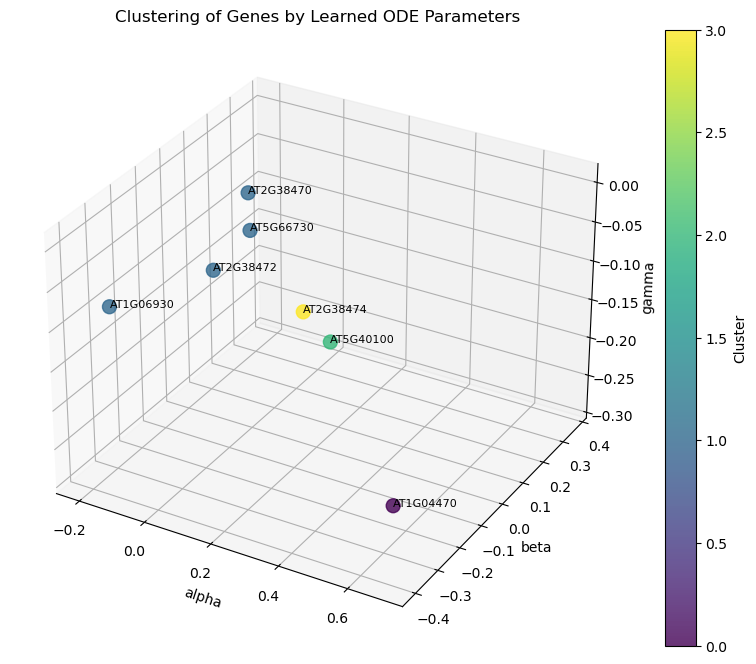

In [6]:
# =============================================================================
# 5. Clustering the Genes Based on Learned ODE Parameters (α, β, γ)
# =============================================================================

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Create a DataFrame to store parameters
params_df = pd.DataFrame(columns=['Gene', 'alpha', 'beta', 'gamma'])

with torch.no_grad():
    for i, gene_id in enumerate(df['Unnamed: 0']):
        model = ode_models[i]
        params_df.loc[i] = [
            gene_id,
            model.alpha.item(),
            model.beta.item(),
            model.gamma.item()
        ]

print("\nLearned Parameters:")
print(params_df)

# Prepare data for clustering
X = params_df[['alpha', 'beta', 'gamma']].values

# (Optional) Scale parameters before clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Choose number of clusters (k=3 here)
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
print("\nCluster assignments for each gene:")
print(clusters)
# Add cluster assignments to the DataFrame
params_df['cluster'] = clusters

print("\nCluster assignments for each gene:")
print(params_df)

# Extract learned parameters for plotting in 3D
alphas_learned = X[:, 0]
betas_learned = X[:, 1]
gammas_learned = X[:, 2]

# Plot the clusters in 3D parameter space
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(alphas_learned, betas_learned, gammas_learned, c=clusters, cmap='viridis', s=100, alpha=0.8)

# Add gene IDs as text annotations
for i, row in params_df.iterrows():
    ax.text(row['alpha'], row['beta'], row['gamma'], row['Gene'], size=8, color='black')

ax.set_xlabel("alpha")
ax.set_ylabel("beta")
ax.set_zlabel("gamma")
ax.set_title("Clustering of Genes by Learned ODE Parameters")
plt.colorbar(scatter, ax=ax, label="Cluster")
plt.show()

In [9]:
##############################################################################
# Step 4: Cluster Analysis
##############################################################################

print("\nCluster Analysis:")
for cluster_id in sorted(params_df['cluster'].unique()):
    cluster_data = params_df[params_df['cluster'] == cluster_id]

    print(f"\nCluster {cluster_id} - Genes:")
    print(", ".join(cluster_data['Gene'].values))

    print("Parameter Statistics:")
    print(f"Alpha: μ = {cluster_data['alpha'].mean():.4f} ± {cluster_data['alpha'].std():.4f}")
    print(f"Beta:  μ = {cluster_data['beta'].mean():.4f} ± {cluster_data['beta'].std():.4f}")
    print(f"Gamma: μ = {cluster_data['gamma'].mean():.4f} ± {cluster_data['gamma'].std():.4f}")

##############################################################################
# Step 5: Save Parameters to CSV
##############################################################################

params_df.to_csv('gene_ode_parameters.csv', index=False)
print("\nParameters saved to gene_ode_parameters.csv")


Cluster Analysis:

Cluster 0 - Genes:
AT1G04470
Parameter Statistics:
Alpha: μ = 0.5707 ± nan
Beta:  μ = -0.3223 ± nan
Gamma: μ = -0.1678 ± nan

Cluster 1 - Genes:
AT1G06930, AT2G38472, AT2G38474
Parameter Statistics:
Alpha: μ = -0.0128 ± 0.2073
Beta:  μ = -0.1547 ± 0.0959
Gamma: μ = -0.0877 ± 0.0213

Cluster 2 - Genes:
AT5G40100
Parameter Statistics:
Alpha: μ = -0.0502 ± nan
Beta:  μ = 0.3639 ± nan
Gamma: μ = -0.2649 ± nan

Cluster 3 - Genes:
AT5G66730, AT2G38470
Parameter Statistics:
Alpha: μ = 0.0174 ± 0.0137
Beta:  μ = -0.0349 ± 0.0259
Gamma: μ = -0.0132 ± 0.0230

Parameters saved to gene_ode_parameters.csv



Learned Parameters:


        Gene     alpha      beta     gamma
0  AT5G40100 -0.050180  0.363852 -0.264872
1  AT1G06930 -0.196227 -0.264498 -0.111149
2  AT1G04470  0.570749 -0.322303 -0.167774
3  AT5G66730  0.027060 -0.053178 -0.029475
4  AT2G38472 -0.054266 -0.087294 -0.082143
5  AT2G38474  0.212122 -0.112262 -0.069675
6  AT2G38470  0.007693 -0.016542  0.003100


c:\Users\praba\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


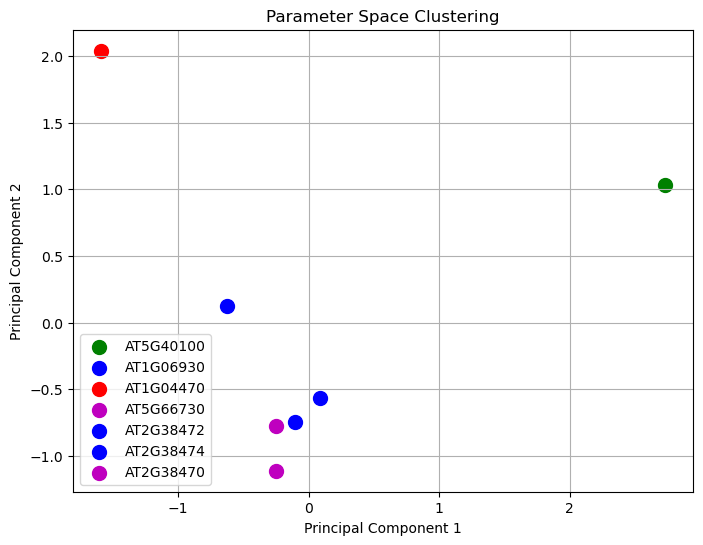


Cluster Analysis:

Cluster 0 - Genes:
AT1G04470
Parameter Statistics:
Alpha: μ = 0.5707 ± nan
Beta:  μ = -0.3223 ± nan
Gamma: μ = -0.1678 ± nan

Cluster 1 - Genes:
AT1G06930, AT2G38472, AT2G38474
Parameter Statistics:
Alpha: μ = -0.0128 ± 0.2073
Beta:  μ = -0.1547 ± 0.0959
Gamma: μ = -0.0877 ± 0.0213

Cluster 2 - Genes:
AT5G40100
Parameter Statistics:
Alpha: μ = -0.0502 ± nan
Beta:  μ = 0.3639 ± nan
Gamma: μ = -0.2649 ± nan

Cluster 3 - Genes:
AT5G66730, AT2G38470
Parameter Statistics:
Alpha: μ = 0.0174 ± 0.0137
Beta:  μ = -0.0349 ± 0.0259
Gamma: μ = -0.0132 ± 0.0230

Parameters saved to gene_ode_parameters.csv


In [10]:
##############################################################################
# Step 1: Store and Print Learned Parameters
##############################################################################

# Create a DataFrame to store parameters
params_df = pd.DataFrame(columns=['Gene', 'alpha', 'beta', 'gamma'])

with torch.no_grad():
    for i, gene_id in enumerate(df['Unnamed: 0']):
        model = ode_models[i]
        params_df.loc[i] = [
            gene_id,
            model.alpha.item(),
            model.beta.item(),
            model.gamma.item()
        ]

print("\nLearned Parameters:")
print(params_df)

##############################################################################
# Step 2: Parameter Clustering using K-means
##############################################################################

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Prepare data for clustering
X = params_df[['alpha', 'beta', 'gamma']].values

# Normalize parameters
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform K-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add clusters to DataFrame
params_df['cluster'] = clusters

##############################################################################
# Step 3: Visualize Clusters with PCA
##############################################################################

# Reduce dimensionality for visualization
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

# Create plot
plt.figure(figsize=(8, 6))
colors = ['r', 'b', 'g', 'm', 'y']
markers = ['o', 's', 'D', '^', 'v']

for i, gene in enumerate(params_df['Gene']):
    plt.scatter(
        principal_components[i, 0],
        principal_components[i, 1],
        c=colors[clusters[i]],
        # marker=markers[i],
        s=100,
        label=gene
    )

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Parameter Space Clustering')
plt.legend()
plt.grid(True)
plt.show()

##############################################################################
# Step 4: Cluster Analysis
##############################################################################

print("\nCluster Analysis:")
for cluster_id in sorted(params_df['cluster'].unique()):
    cluster_data = params_df[params_df['cluster'] == cluster_id]

    print(f"\nCluster {cluster_id} - Genes:")
    print(", ".join(cluster_data['Gene'].values))

    print("Parameter Statistics:")
    print(f"Alpha: μ = {cluster_data['alpha'].mean():.4f} ± {cluster_data['alpha'].std():.4f}")
    print(f"Beta:  μ = {cluster_data['beta'].mean():.4f} ± {cluster_data['beta'].std():.4f}")
    print(f"Gamma: μ = {cluster_data['gamma'].mean():.4f} ± {cluster_data['gamma'].std():.4f}")

##############################################################################
# Step 5: Save Parameters to CSV
##############################################################################

params_df.to_csv('gene_ode_parameters.csv', index=False)
print("\nParameters saved to gene_ode_parameters.csv")

## generate some synthetic data for cluster 2 and after that use the alpha , beta, gama and ththe ODE ato predict the data.we can see that the prediction is okay but not impressive.

c:\Users\praba\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Synthetic Data:
          Unnamed: 0  Hpa-NO_1d  Hpa-NO_2d  Hpa-NO_4d  cluster
0   SYNTHETIC_0_4543   0.001557   1.042837   0.089332        0
1   SYNTHETIC_0_2343  -0.133490   1.219085   0.070089        0
2   SYNTHETIC_0_8506  -0.075390   1.143329  -0.092556        0
3   SYNTHETIC_0_4220  -0.078711   1.187159   0.000532        0
4   SYNTHETIC_1_8616   0.213114   0.137036  -0.087830        1
5   SYNTHETIC_1_4789   0.087198   0.499927  -0.396537        1
6   SYNTHETIC_1_5763  -0.151984   0.074140  -0.148106        1
7   SYNTHETIC_1_3412   0.431014   0.228277   0.236877        1
8   SYNTHETIC_2_7981  -0.451840  -0.796160  -5.113225        2
9   SYNTHETIC_2_2384  -0.341923  -0.738131  -5.183941        2
10  SYNTHETIC_2_8713  -0.453931  -0.386800  -5.105513        2
11  SYNTHETIC_2_3812  -0.571841  -0.574107  -5.057426        2
12  SYNTHETIC_3_3942   1.026500   0.388874  -0.107986        3
13  SYNTHETIC_3_8564   0.539399   0.634399   0.397393        3
14  SYNTHETIC_3_1038   1.401073   0.637

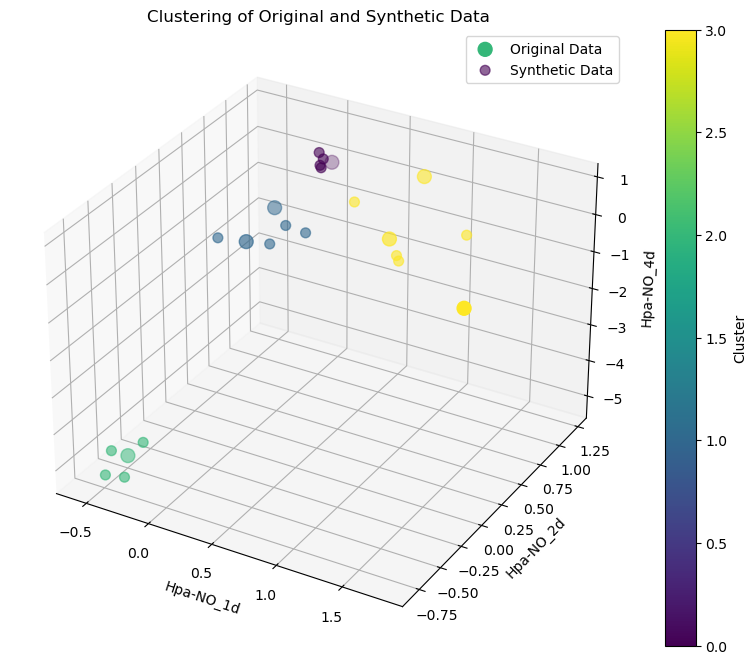

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Original data (example structure)
original_data = pd.DataFrame({
    "Unnamed: 0": ["AT5G40100", "AT1G06930", "AT1G04470", "AT5G66730", "AT2G38472", "AT2G38474", "AT2G38470"],
    "Hpa-NO_1d": [-0.447960, 1.778359, 0.000000, 0.055375, 0.900000, 0.000000, 0.906000],
    "Hpa-NO_2d": [-0.560155, 0.000000, 1.175150, 0.098435, 0.500000, 0.500000, 0.906000],
    "Hpa-NO_4d": [-5.091964, 0.000000, 0.000000, -0.101757, 0.000000, 0.000000, 0.906000]
})

# Extract numerical data for clustering
X = original_data[["Hpa-NO_1d", "Hpa-NO_2d", "Hpa-NO_4d"]].values

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform clustering (e.g., k=4 clusters)
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to the original data
original_data["cluster"] = clusters

# Generate synthetic data based on cluster centroids
centroids = kmeans.cluster_centers_
centroids_original = scaler.inverse_transform(centroids)  # Transform centroids back to original scale

# Number of synthetic samples per cluster
num_synthetic_samples_per_cluster = 4

# Generate synthetic data
synthetic_data = []
for cluster_idx, centroid in enumerate(centroids_original):
    # Add random noise around the centroid to generate synthetic points
    noise = np.random.normal(scale=0.2, size=(num_synthetic_samples_per_cluster, 3))  # Adjust scale for noise level
    cluster_synthetic_points = centroid + noise
    for point in cluster_synthetic_points:
        synthetic_data.append({
            "Unnamed: 0": f"SYNTHETIC_{cluster_idx}_{np.random.randint(1000, 9999)}",
            "Hpa-NO_1d": point[0],
            "Hpa-NO_2d": point[1],
            "Hpa-NO_4d": point[2],
            "cluster": cluster_idx
        })

# Convert synthetic data to DataFrame
synthetic_df = pd.DataFrame(synthetic_data)

# Combine original and synthetic data for comparison
combined_data = pd.concat([original_data, synthetic_df], ignore_index=True)

# Print synthetic data
print("Synthetic Data:")
print(synthetic_df)

# Print combined data
print("\nCombined Data:")
print(combined_data)

# Visualize the clusters in 3D parameter space
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot original data
scatter_original = ax.scatter(
    original_data["Hpa-NO_1d"], original_data["Hpa-NO_2d"], original_data["Hpa-NO_4d"],
    c=original_data["cluster"], cmap='viridis', s=100, label="Original Data"
)

# Plot synthetic data
scatter_synthetic = ax.scatter(
    synthetic_df["Hpa-NO_1d"], synthetic_df["Hpa-NO_2d"], synthetic_df["Hpa-NO_4d"],
    c=synthetic_df["cluster"], cmap='viridis', s=50, alpha=0.6, label="Synthetic Data"
)

ax.set_xlabel("Hpa-NO_1d")
ax.set_ylabel("Hpa-NO_2d")
ax.set_zlabel("Hpa-NO_4d")
ax.set_title("Clustering of Original and Synthetic Data")
plt.colorbar(scatter_original, ax=ax, label="Cluster")
plt.legend()
plt.show()

Synthetic Point 0:
  Actual Derivative: [-0.34432   -0.9490575 -2.1585325]
  Predicted Derivative: [-0.45480931 -0.86687957 -3.01334515]
  Satisfies Model: False

Synthetic Point 1:
  Actual Derivative: [-0.396208 -1.005107 -2.222905]
  Predicted Derivative: [-0.41475171 -0.84573177 -3.03911654]
  Satisfies Model: False



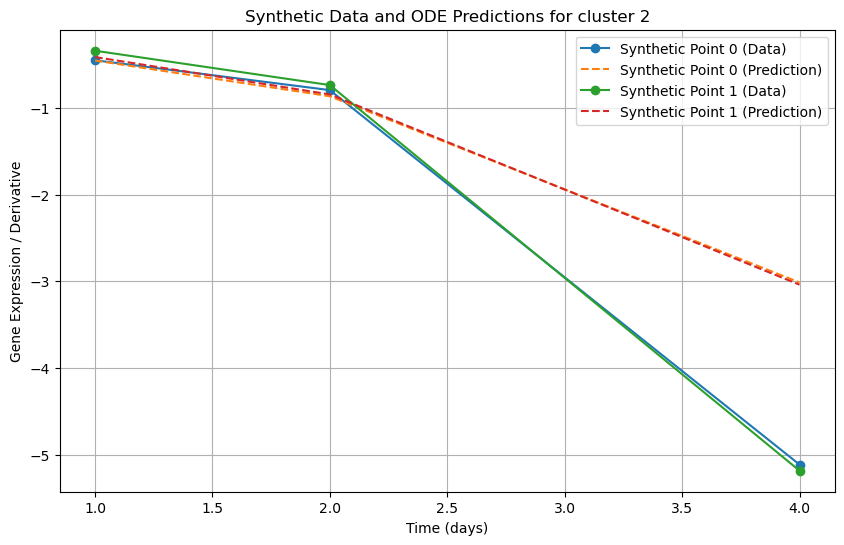

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Given parameters for cluster 2
alpha = -0.003555
beta = 0.364435
gamma = -0.286588

# Synthetic data points in cluster 2
# synthetic_cluster_2 = pd.DataFrame({
#     "Hpa-NO_1d": [-0.451840, -0.341923, -0.453931, -0.571841],
#     "Hpa-NO_2d": [-0.796160, -0.738131, -0.386800, -0.574107]
#     "Hpa-NO_4d": [-5.113225, -5.183941, -5.105513, -5.057426]
# })
synthetic_cluster_2 = pd.DataFrame({
    "Hpa-NO_1d": [-0.451840, -0.341923, ],
    "Hpa-NO_2d": [-0.796160, -0.738131, ],
    "Hpa-NO_4d": [-5.113225, -5.183941,   ]
})

# Time points corresponding to the columns
time_points = np.array([1.0, 2.0, 4.0])  # Day 1, Day 2, Day 4

# Function to compute the ODE prediction
def compute_ode_prediction(y, t, alpha, beta, gamma):
    return alpha + beta * y + gamma * t

# Check if the synthetic data satisfies the ODE model
results = []
for index, row in synthetic_cluster_2.iterrows():
    y_values = row.values  # Extract y(t) values
    dy_dt_actual = np.gradient(y_values, time_points)  # Compute actual derivative using finite differences
    dy_dt_predicted = compute_ode_prediction(y_values, time_points, alpha, beta, gamma)  # Predicted derivative
    satisfies_model = np.allclose(dy_dt_actual, dy_dt_predicted, atol=0.1)  # Check if actual ≈ predicted
    results.append({
        "Synthetic Point": index,
        "Actual Derivative": dy_dt_actual,
        "Predicted Derivative": dy_dt_predicted,
        "Satisfies Model": satisfies_model
    })

# Display results
for result in results:
    print(f"Synthetic Point {result['Synthetic Point']}:")
    print(f"  Actual Derivative: {result['Actual Derivative']}")
    print(f"  Predicted Derivative: {result['Predicted Derivative']}")
    print(f"  Satisfies Model: {result['Satisfies Model']}")
    print()

# Plot the synthetic data and predictions
plt.figure(figsize=(10, 6))
for index, row in synthetic_cluster_2.iterrows():
    y_values = row.values  # Extract y(t) values
    dy_dt_predicted = compute_ode_prediction(y_values, time_points, alpha, beta, gamma)  # Predicted derivative

    # Plot synthetic data
    plt.plot(time_points, y_values, 'o-', label=f"Synthetic Point {index} (Data)")

    # Plot predicted values
    plt.plot(time_points, dy_dt_predicted, '--', label=f"Synthetic Point {index} (Prediction)")

plt.xlabel("Time (days)")
plt.ylabel("Gene Expression / Derivative")
plt.title("Synthetic Data and ODE Predictions for cluster 2")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import matplotlib.pyplot as plt

# Generate synthetic test data
test_data = {
    "Unnamed: 0": ["AT5G40101", "AT1G06930", "AT1G04470", "AT5G66730", "AT2G38471"],
    "Hpa-NO_1d": [-0.5, 1.8, 0.1, 0.05, 0.5],
    "Hpa-NO_2d": [-0.6, 0.1, 1.2, 0.1, 0.8],
    "Hpa-NO_4d": [-5.1, 0.1, 0.1, -0.1, 0.5],
}

test_df = pd.DataFrame(test_data)
print("Test Data:")
print(test_df)


Test Data:
  Unnamed: 0  Hpa-NO_1d  Hpa-NO_2d  Hpa-NO_4d
0  AT5G40101      -0.50       -0.6       -5.1
1  AT1G06930       1.80        0.1        0.1
2  AT1G04470       0.10        1.2        0.1
3  AT5G66730       0.05        0.1       -0.1
4  AT2G38471       0.50        0.8        0.5


In [12]:

# Extract gene expression data from test data
test_gene_data = test_df[["Hpa-NO_1d", "Hpa-NO_2d", "Hpa-NO_4d"]].values
print(test_gene_data)
# Convert to PyTorch tensors
test_gene_data_tensor = torch.tensor(test_gene_data, dtype=torch.float32)


[[-0.5  -0.6  -5.1 ]
 [ 1.8   0.1   0.1 ]
 [ 0.1   1.2   0.1 ]
 [ 0.05  0.1  -0.1 ]
 [ 0.5   0.8   0.5 ]]


In [13]:
noise = 0.005 * torch.randn_like(gene_data_tensor)
test_gene_data_tensor = gene_data_tensor + noise
# x0_test = test_data[:, 0].unsqueeze(1)


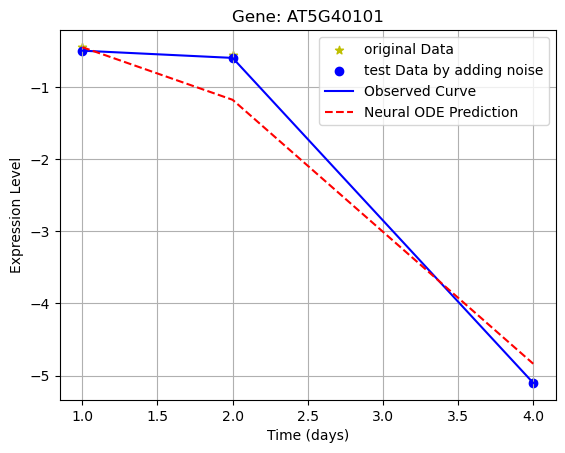

Learned ODE for Gene AT5G40101:
  dy/dt = -0.0502 + 0.3639 * y + -0.2649 * t
Formatted ODE Equation: dy/dt = -0.0502 + 0.3639 * y(t) + -0.2649 * t



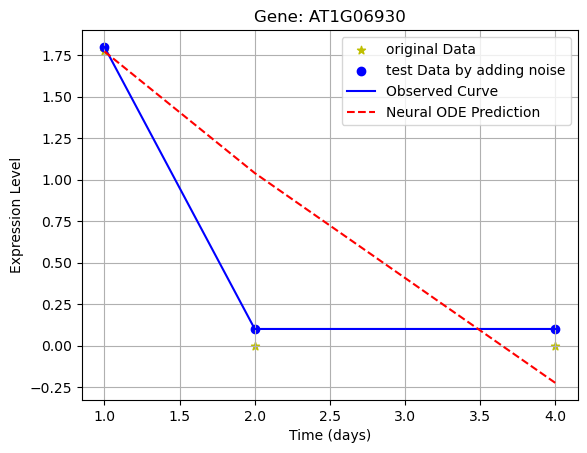

Learned ODE for Gene AT1G06930:
  dy/dt = -0.1962 + -0.2645 * y + -0.1111 * t
Formatted ODE Equation: dy/dt = -0.1962 + -0.2645 * y(t) + -0.1111 * t



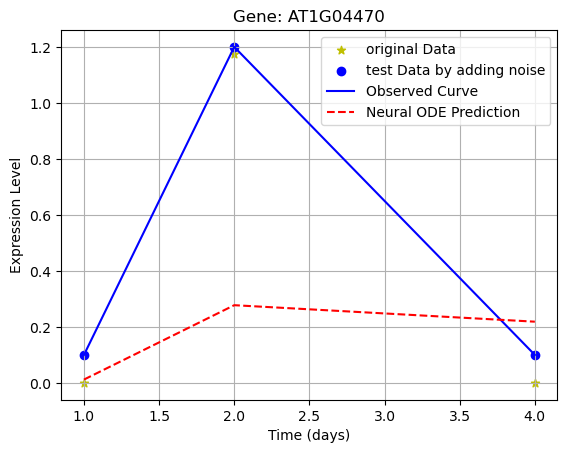

Learned ODE for Gene AT1G04470:
  dy/dt = 0.5707 + -0.3223 * y + -0.1678 * t
Formatted ODE Equation: dy/dt = 0.5707 + -0.3223 * y(t) + -0.1678 * t



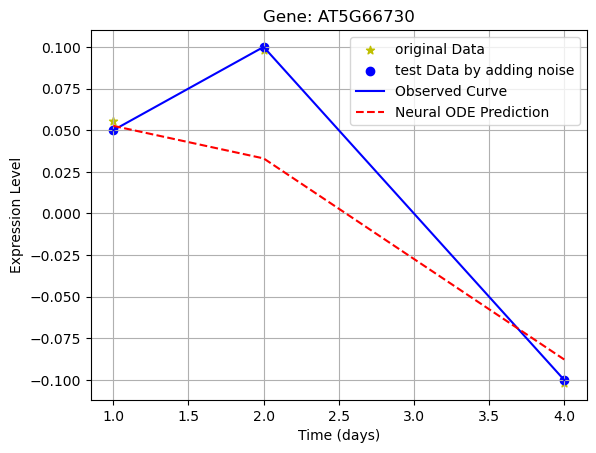

Learned ODE for Gene AT5G66730:
  dy/dt = 0.0271 + -0.0532 * y + -0.0295 * t
Formatted ODE Equation: dy/dt = 0.0271 + -0.0532 * y(t) + -0.0295 * t



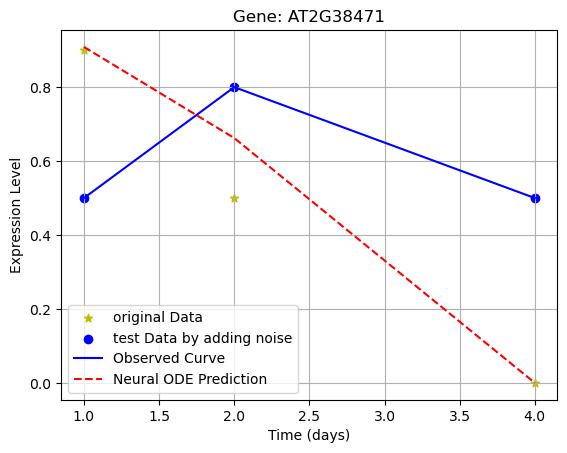

Learned ODE for Gene AT2G38471:
  dy/dt = -0.0543 + -0.0873 * y + -0.0821 * t
Formatted ODE Equation: dy/dt = -0.0543 + -0.0873 * y(t) + -0.0821 * t



In [14]:

# Use the trained model to make predictions on the test data
with torch.no_grad():
    for i, gene_id in enumerate(test_df['Unnamed: 0']):
        # Use the Day1 value as the initial condition for each gene
        y0 = test_gene_data_tensor[i, 0].unsqueeze(0)  # shape: (1,)
        preds = odeint(ode_models[i], y0, time_points_tensor).squeeze().numpy()

        # Plot observed data vs. Neural ODE predictions
        plt.figure()
        plt.scatter(time_points, gene_data_tensor[i], c='y',marker='*', label="original Data")

        plt.scatter(time_points, test_gene_data[i], c='b', label="test Data by adding noise")
        plt.plot(time_points, test_gene_data[i], 'b-', label="Observed Curve")
        plt.plot(time_points, preds, 'r--', label="Neural ODE Prediction")
        plt.title(f"Gene: {gene_id}")
        plt.xlabel("Time (days)")
        plt.ylabel("Expression Level")
        plt.legend()
        plt.grid(True)
        plt.show()

        # Print learned parameters for the gene
        model = ode_models[i]
        alpha = model.alpha.item()
        beta = model.beta.item()
        gamma = model.gamma.item()
        print(f"Learned ODE for Gene {gene_id}:")
        print(f"  dy/dt = {alpha:.4f} + {beta:.4f} * y + {gamma:.4f} * t")
        print(f"Formatted ODE Equation: dy/dt = {alpha:.4f} + {beta:.4f} * y(t) + {gamma:.4f} * t\n")

In [15]:
from sklearn.cluster import KMeans

# Number of clusters for each parameter
n_clusters = 4

# Cluster alpha values
kmeans_alpha = KMeans(n_clusters=n_clusters, random_state=42)
params_df['alpha_cluster'] = kmeans_alpha.fit_predict(params_df[['alpha']])

# Cluster beta values
kmeans_beta = KMeans(n_clusters=n_clusters, random_state=42)
params_df['beta_cluster'] = kmeans_beta.fit_predict(params_df[['beta']])

# Cluster gamma values
kmeans_gamma = KMeans(n_clusters=n_clusters, random_state=42)
params_df['gamma_cluster'] = kmeans_gamma.fit_predict(params_df[['gamma']])

print("\nClustered Parameters:")
print(params_df)

c:\Users\praba\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(



Clustered Parameters:
        Gene     alpha      beta     gamma  cluster  alpha_cluster  \
0  AT5G40100 -0.050180  0.363852 -0.264872        2              1   
1  AT1G06930 -0.196227 -0.264498 -0.111149        1              2   
2  AT1G04470  0.570749 -0.322303 -0.167774        0              0   
3  AT5G66730  0.027060 -0.053178 -0.029475        3              1   
4  AT2G38472 -0.054266 -0.087294 -0.082143        1              1   
5  AT2G38474  0.212122 -0.112262 -0.069675        1              3   
6  AT2G38470  0.007693 -0.016542  0.003100        3              1   

   beta_cluster  gamma_cluster  
0             2              2  
1             0              1  
2             0              0  
3             1              3  
4             3              1  
5             3              1  
6             1              3  


c:\Users\praba\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\praba\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Columns in params_df: Index(['Gene', 'alpha', 'beta', 'gamma', 'cluster', 'alpha_cluster',
       'beta_cluster', 'gamma_cluster'],
      dtype='object')


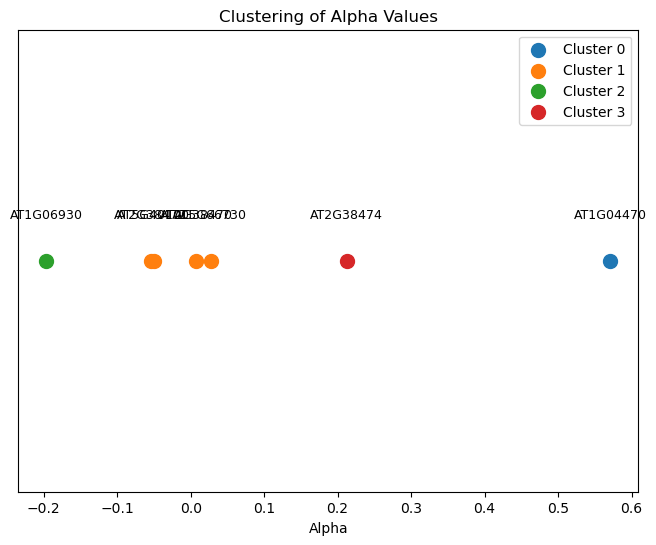

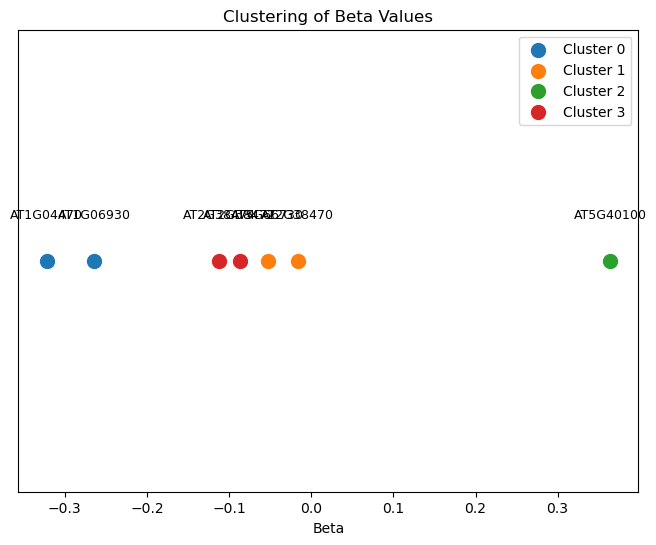

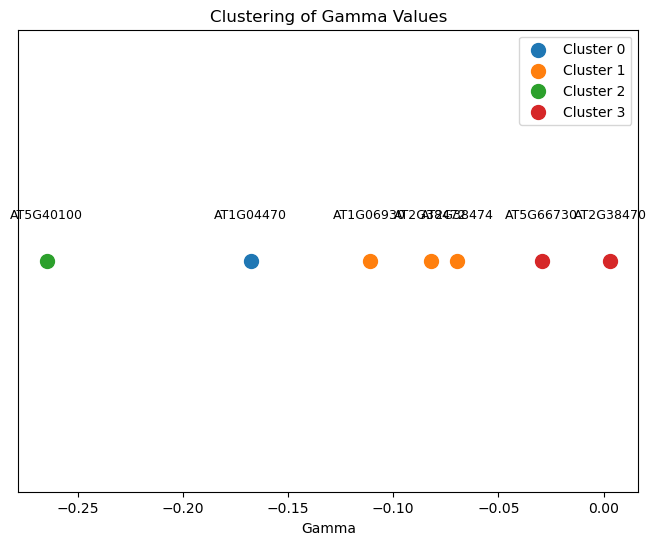

In [16]:
# Verify column names in params_df
print("Columns in params_df:", params_df.columns)

# Replace 'Unnamed: 0' with the correct column name if necessary
gene_id_column = 'Gene'  # Replace with the actual column name for gene IDs

# Plot clusters for alpha
plt.figure(figsize=(8, 6))
for cluster in range(n_clusters):
    cluster_data = params_df[params_df['alpha_cluster'] == cluster]
    plt.scatter(cluster_data['alpha'], np.zeros_like(cluster_data['alpha']),
                label=f'Cluster {cluster}', s=100)
    for _, row in cluster_data.iterrows():
        plt.text(row['alpha'], 0.01, row[gene_id_column], fontsize=9, ha='center')
plt.title('Clustering of Alpha Values')
plt.xlabel('Alpha')
plt.yticks([])
plt.legend()
plt.show()

# Plot clusters for beta
plt.figure(figsize=(8, 6))
for cluster in range(n_clusters):
    cluster_data = params_df[params_df['beta_cluster'] == cluster]
    plt.scatter(cluster_data['beta'], np.zeros_like(cluster_data['beta']),
                label=f'Cluster {cluster}', s=100)
    for _, row in cluster_data.iterrows():
        plt.text(row['beta'], 0.01, row[gene_id_column], fontsize=9, ha='center')
plt.title('Clustering of Beta Values')
plt.xlabel('Beta')
plt.yticks([])
plt.legend()
plt.show()

# Plot clusters for gamma
plt.figure(figsize=(8, 6))
for cluster in range(n_clusters):
    cluster_data = params_df[params_df['gamma_cluster'] == cluster]
    plt.scatter(cluster_data['gamma'], np.zeros_like(cluster_data['gamma']),
                label=f'Cluster {cluster}', s=100)
    for _, row in cluster_data.iterrows():
        plt.text(row['gamma'], 0.01, row[gene_id_column], fontsize=9, ha='center')
plt.title('Clustering of Gamma Values')
plt.xlabel('Gamma')
plt.yticks([])
plt.legend()
plt.show()

In [17]:
# Check the column names in params_df
print("Columns in params_df:", params_df.columns)

# Replace 'Unnamed: 0' with the correct column name for gene IDs
gene_id_column = 'Gene'  # Replace with the actual column name if different

print("\nCluster Analysis:")

# Alpha clusters
print("\nAlpha Clusters:")
for cluster in range(n_clusters):
    cluster_genes = params_df[params_df['alpha_cluster'] == cluster][gene_id_column].values
    print(f"Cluster {cluster}: {', '.join(cluster_genes)}")

# Beta clusters
print("\nBeta Clusters:")
for cluster in range(n_clusters):
    cluster_genes = params_df[params_df['beta_cluster'] == cluster][gene_id_column].values
    print(f"Cluster {cluster}: {', '.join(cluster_genes)}")

# Gamma clusters
print("\nGamma Clusters:")
for cluster in range(n_clusters):
    cluster_genes = params_df[params_df['gamma_cluster'] == cluster][gene_id_column].values
    print(f"Cluster {cluster}: {', '.join(cluster_genes)}")

Columns in params_df: Index(['Gene', 'alpha', 'beta', 'gamma', 'cluster', 'alpha_cluster',
       'beta_cluster', 'gamma_cluster'],
      dtype='object')

Cluster Analysis:

Alpha Clusters:
Cluster 0: AT1G04470
Cluster 1: AT5G40100, AT5G66730, AT2G38472, AT2G38470
Cluster 2: AT1G06930
Cluster 3: AT2G38474

Beta Clusters:
Cluster 0: AT1G06930, AT1G04470
Cluster 1: AT5G66730, AT2G38470
Cluster 2: AT5G40100
Cluster 3: AT2G38472, AT2G38474

Gamma Clusters:
Cluster 0: AT1G04470
Cluster 1: AT1G06930, AT2G38472, AT2G38474
Cluster 2: AT5G40100
Cluster 3: AT5G66730, AT2G38470


In [18]:
params_df.to_csv('clustered_parameters.csv', index=False)
print("\nClustered parameters saved to 'clustered_parameters.csv'.")


Clustered parameters saved to 'clustered_parameters.csv'.


------------------


Synthetic Test Data:
[[-0.72590638 -0.82891627 -0.90451129]
 [ 0.28741614  1.64437679 11.09726935]
 [-0.03168118 -0.39860141 -1.05950237]
 [-0.47011605  0.34017766  1.47737887]
 [-0.15389745  1.07888982  3.54903912]]
True underlying parameters (α, β, γ) for test genes:
[[ 0.23891089  0.06618777 -0.04545708]
 [ 0.21344134  0.83719946 -0.03519653]
 [-0.0936401   0.5095812   0.03408211]
 [ 0.06926537 -0.64634555  0.39646022]
 [ 0.76836462 -0.53094848  0.49413243]]


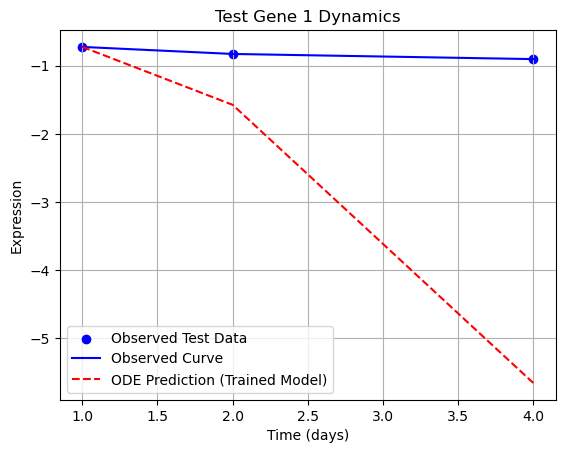

Learned ODE for Test Gene 1 (using Trained Model 1):
  dy/dt = -0.0502 + 0.3639 * y(t) + -0.2649 * t



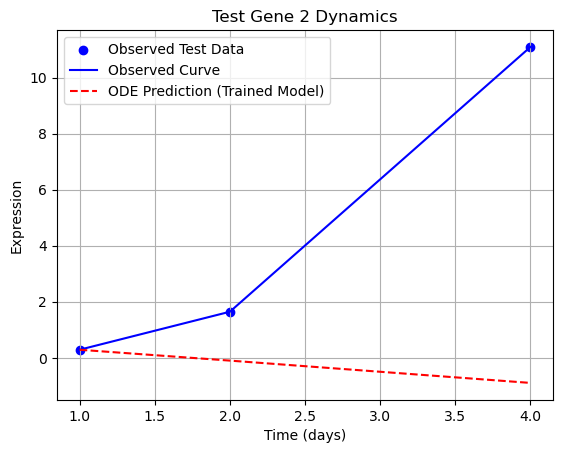

Learned ODE for Test Gene 2 (using Trained Model 2):
  dy/dt = -0.1962 + -0.2645 * y(t) + -0.1111 * t



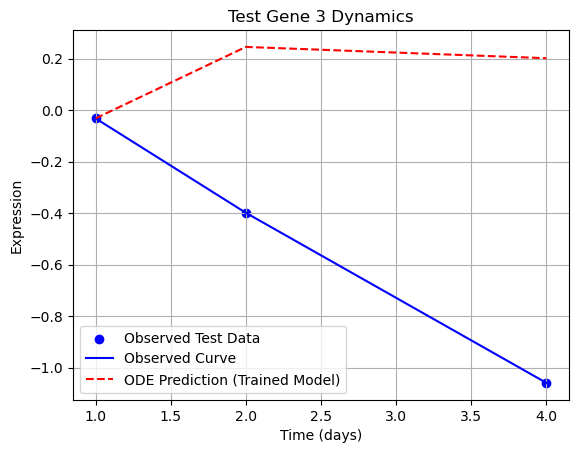

Learned ODE for Test Gene 3 (using Trained Model 3):
  dy/dt = 0.5707 + -0.3223 * y(t) + -0.1678 * t



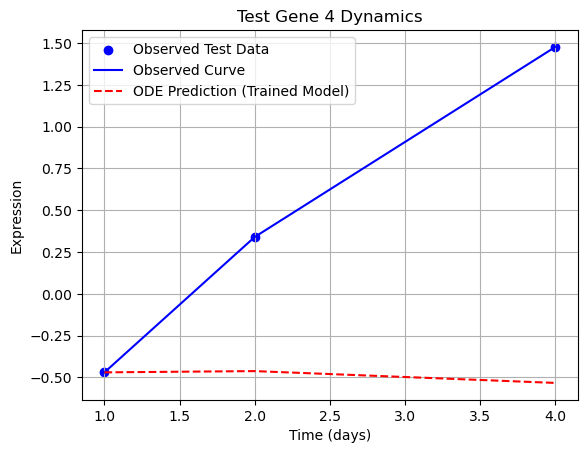

Learned ODE for Test Gene 4 (using Trained Model 4):
  dy/dt = 0.0271 + -0.0532 * y(t) + -0.0295 * t



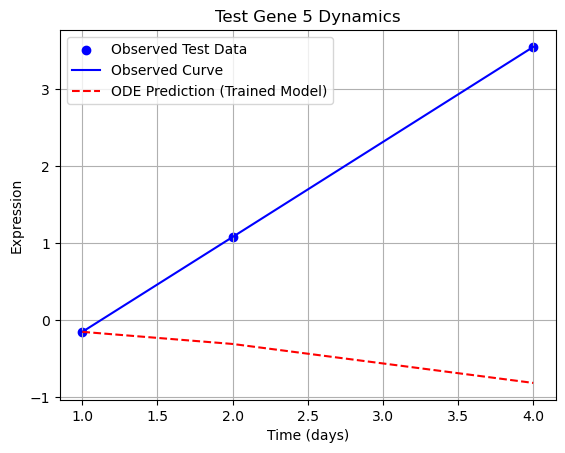

Learned ODE for Test Gene 5 (using Trained Model 5):
  dy/dt = -0.0543 + -0.0873 * y(t) + -0.0821 * t

Cluster assignments for trained ODE parameters (used for testing):
[2 3 0 1 1]


c:\Users\praba\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


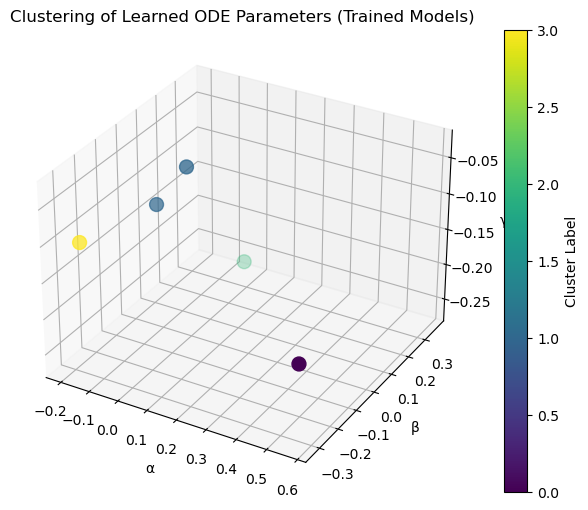

In [19]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from scipy.integrate import odeint as scipy_odeint

##############################################################################
#  Generate Synthetic Test Data
##############################################################################
# Generate synthetic test data using a similar ODE model but with new (synthetic) parameters.
def generate_synthetic_test_data(num_genes, time_points, noise_std=0.1):
    test_data = []
    true_params = []
    for i in range(num_genes):
        # Randomly sample parameters from uniform distributions
        alpha = np.random.uniform(-1, 1)
        beta = np.random.uniform(-1, 1)
        gamma = np.random.uniform(-0.5, 0.5)
        true_params.append([alpha, beta, gamma])

        # Choose an initial condition y0 randomly
        y0 = np.random.uniform(-1, 1)

        # Define the ODE function for simulation
        def ode_func(y, t, alpha=alpha, beta=beta, gamma=gamma):
            return alpha + beta * y + gamma * t

        # Simulate the ODE using SciPy's odeint
        y_sim = scipy_odeint(ode_func, y0, time_points).flatten()
        # Add noise
        y_sim_noisy = y_sim + np.random.normal(0, noise_std, size=y_sim.shape)
        test_data.append(y_sim_noisy)
    return np.array(test_data), np.array(true_params)

num_test_genes = 5
test_time_points = time_points  # same time points for test data
test_data_np, true_test_params = generate_synthetic_test_data(num_test_genes, test_time_points, noise_std=0.2)
print("\nSynthetic Test Data:")
print(test_data_np)
print("True underlying parameters (α, β, γ) for test genes:")
print(true_test_params)

# Convert test data to torch tensor
test_data_tensor = torch.tensor(test_data_np, dtype=torch.float32)

##############################################################################
# 6. Testing: Use Trained Models on Test Data (Do NOT update/train the models)
##############################################################################
# For simplicity, we pair test genes with training models by index
# (using the first min(num_training_genes, num_test_genes) pairs)
num_pairs = min(num_genes, num_test_genes)
learned_params = []  # to collect parameters for clustering

with torch.no_grad():
    for i in range(num_pairs):
        y0_test = test_data_tensor[i, 0].unsqueeze(0)  # use the test gene's Day1 as initial condition
        preds = odeint(ode_models[i], y0_test, time_points_tensor).squeeze().cpu().numpy()

        # Plot observed test data vs. prediction from the trained model
        plt.figure()
        plt.scatter(time_points, test_data_np[i], c='b', label="Observed Test Data")
        plt.plot(time_points, test_data_np[i], 'b-', label="Observed Curve")
        plt.plot(time_points, preds, 'r--', label="ODE Prediction (Trained Model)")
        plt.title(f"Test Gene {i+1} Dynamics")
        plt.xlabel("Time (days)")
        plt.ylabel("Expression")
        plt.legend()
        plt.grid(True)
        plt.show()

        # Extract and print learned parameters from the corresponding trained model
        model_i = ode_models[i]
        alpha = model_i.alpha.item()
        beta = model_i.beta.item()
        gamma = model_i.gamma.item()
        learned_params.append([alpha, beta, gamma])
        print(f"Learned ODE for Test Gene {i+1} (using Trained Model {i+1}):")
        print(f"  dy/dt = {alpha:.4f} + {beta:.4f} * y(t) + {gamma:.4f} * t\n")

learned_params = np.array(learned_params)

##############################################################################
# 7. Cluster the Learned ODE Parameters from Trained Models
##############################################################################
# Cluster the parameter vectors [α, β, γ] from the trained models used for testing.
k = 4  # choose number of clusters (e.g., 2)
kmeans = KMeans(n_clusters=k, random_state=0).fit(learned_params)
cluster_labels = kmeans.labels_
print("Cluster assignments for trained ODE parameters (used for testing):")
print(cluster_labels)

# 3D Scatter Plot of the Clustered Parameters
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(learned_params[:, 0], learned_params[:, 1], learned_params[:, 2],
                     c=cluster_labels, cmap='viridis', s=100)
ax.set_xlabel("α")
ax.set_ylabel("β")
ax.set_zlabel("γ")
ax.set_title("Clustering of Learned ODE Parameters (Trained Models)")
plt.colorbar(scatter, ax=ax, label='Cluster Label')
plt.show()


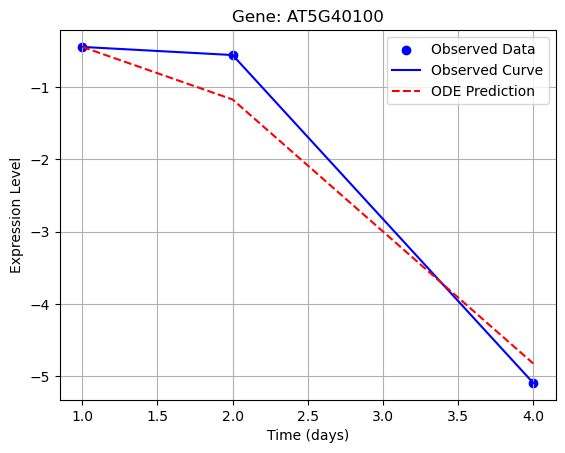

Learned ODE for Gene AT5G40100:
  dy/dt = -0.0502 + 0.3639 * y + -0.2649 * t
Formatted ODE Equation: dy/dt = -0.0502 + 0.3639 * y(t) + -0.2649 * t



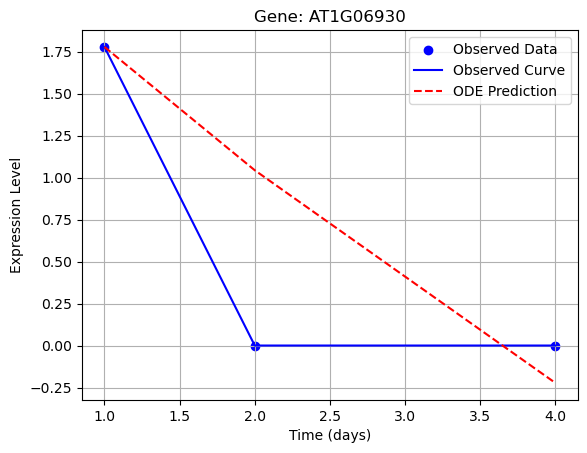

Learned ODE for Gene AT1G06930:
  dy/dt = -0.1962 + -0.2645 * y + -0.1111 * t
Formatted ODE Equation: dy/dt = -0.1962 + -0.2645 * y(t) + -0.1111 * t



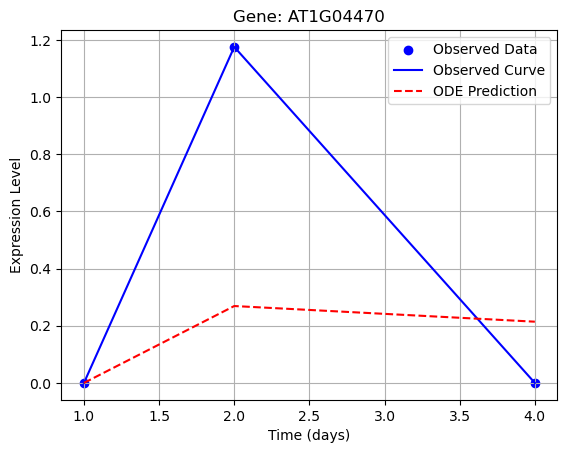

Learned ODE for Gene AT1G04470:
  dy/dt = 0.5707 + -0.3223 * y + -0.1678 * t
Formatted ODE Equation: dy/dt = 0.5707 + -0.3223 * y(t) + -0.1678 * t



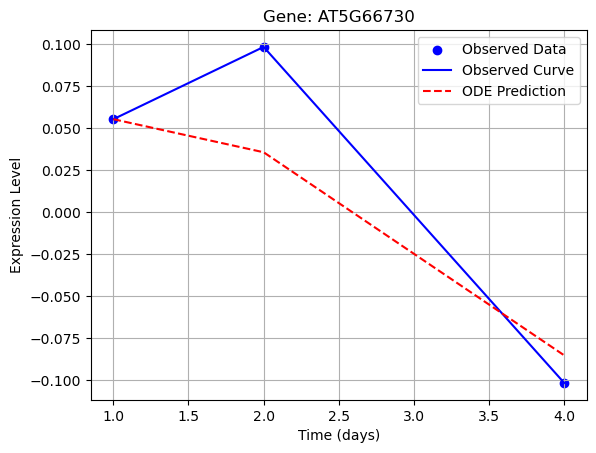

Learned ODE for Gene AT5G66730:
  dy/dt = 0.0271 + -0.0532 * y + -0.0295 * t
Formatted ODE Equation: dy/dt = 0.0271 + -0.0532 * y(t) + -0.0295 * t



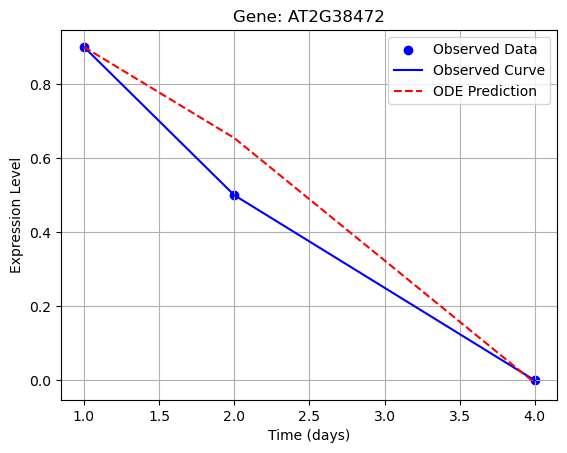

Learned ODE for Gene AT2G38472:
  dy/dt = -0.0543 + -0.0873 * y + -0.0821 * t
Formatted ODE Equation: dy/dt = -0.0543 + -0.0873 * y(t) + -0.0821 * t



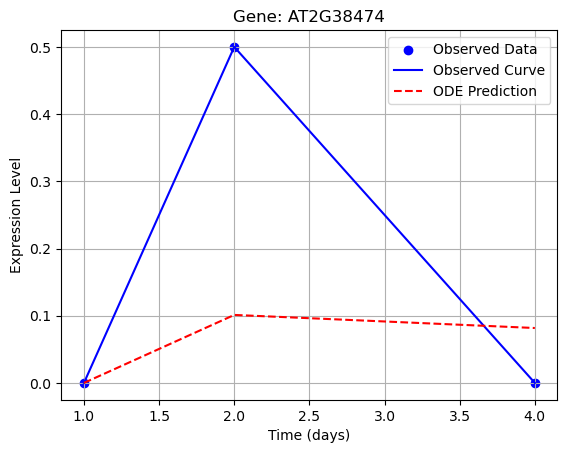

Learned ODE for Gene AT2G38474:
  dy/dt = 0.2121 + -0.1123 * y + -0.0697 * t
Formatted ODE Equation: dy/dt = 0.2121 + -0.1123 * y(t) + -0.0697 * t



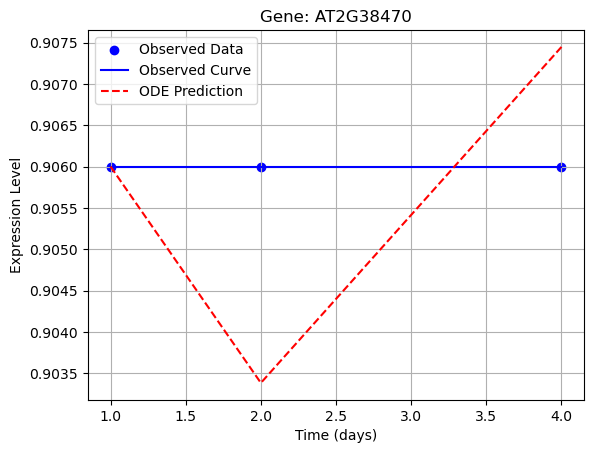

Learned ODE for Gene AT2G38470:
  dy/dt = 0.0077 + -0.0165 * y + 0.0031 * t
Formatted ODE Equation: dy/dt = 0.0077 + -0.0165 * y(t) + 0.0031 * t


Learned Parameters:
        Gene     alpha      beta     gamma
0  AT5G40100 -0.050180  0.363852 -0.264872
1  AT1G06930 -0.196227 -0.264498 -0.111149
2  AT1G04470  0.570749 -0.322303 -0.167774
3  AT5G66730  0.027060 -0.053178 -0.029475
4  AT2G38472 -0.054266 -0.087294 -0.082143
5  AT2G38474  0.212122 -0.112262 -0.069675
6  AT2G38470  0.007693 -0.016542  0.003100

Parameters with Individual Clusters:
        Gene     alpha      beta     gamma  alpha_cluster  beta_cluster  \
0  AT5G40100 -0.050180  0.363852 -0.264872              1             2   
1  AT1G06930 -0.196227 -0.264498 -0.111149              2             0   
2  AT1G04470  0.570749 -0.322303 -0.167774              0             0   
3  AT5G66730  0.027060 -0.053178 -0.029475              1             1   
4  AT2G38472 -0.054266 -0.087294 -0.082143              1             1   
5

c:\Users\praba\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\praba\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\praba\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


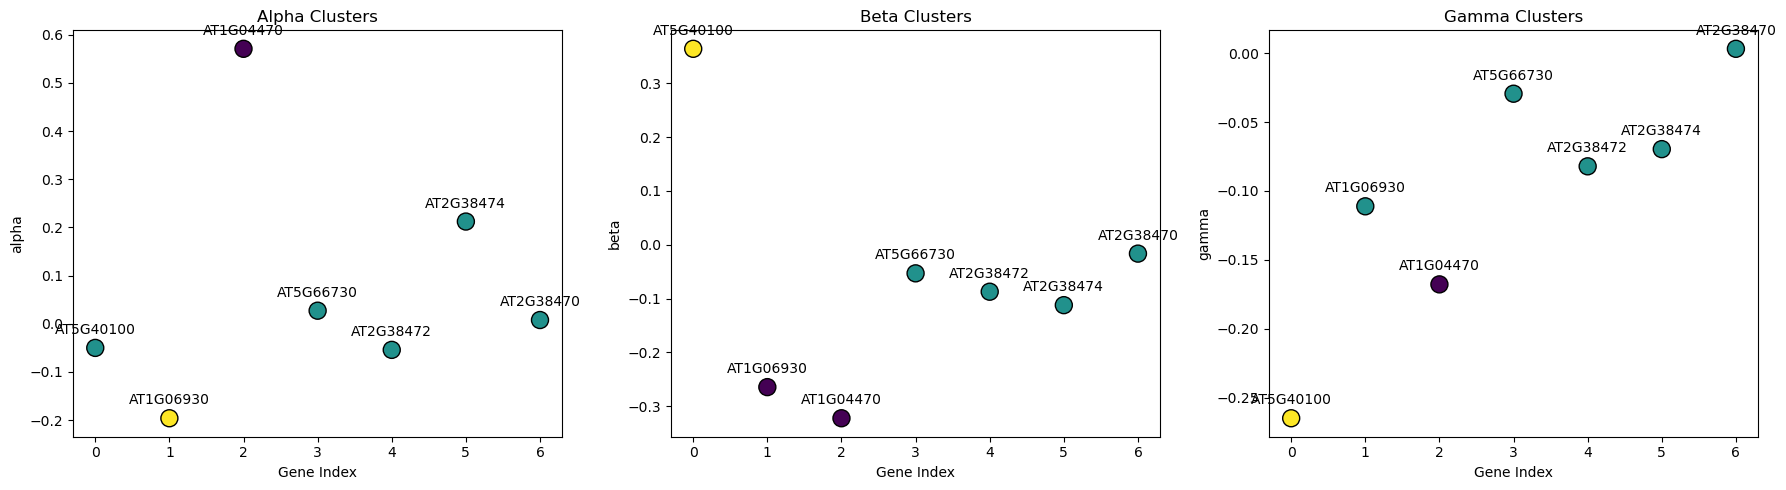


Cluster Analysis for Alpha:
Alpha Cluster 0: AT1G04470
Alpha Cluster 1: AT5G40100, AT5G66730, AT2G38472, AT2G38474, AT2G38470
Alpha Cluster 2: AT1G06930

Cluster Analysis for Beta:
Beta Cluster 0: AT1G06930, AT1G04470
Beta Cluster 1: AT5G66730, AT2G38472, AT2G38474, AT2G38470
Beta Cluster 2: AT5G40100

Cluster Analysis for Gamma:
Gamma Cluster 0: AT1G04470
Gamma Cluster 1: AT1G06930, AT5G66730, AT2G38472, AT2G38474, AT2G38470
Gamma Cluster 2: AT5G40100


In [20]:
##############################################################################
# Plotting Predictions and Printing Learned ODE Parameters
##############################################################################

with torch.no_grad():
    for i, gene_id in enumerate(df['Unnamed: 0']):
        # Use the Day1 value as the initial condition for each gene
        y0 = gene_data_tensor[i, 0].unsqueeze(0)  # shape: (1,)
        preds = odeint(ode_models[i], y0, time_points_tensor).squeeze().numpy()

        # Plot observed data vs. ODE predictions
        plt.figure()
        plt.scatter(time_points, gene_data[i], c='b', label="Observed Data")
        plt.plot(time_points, gene_data[i], 'b-', label="Observed Curve")
        plt.plot(time_points, preds, 'r--', label="ODE Prediction")
        plt.title(f"Gene: {gene_id}")
        plt.xlabel("Time (days)")
        plt.ylabel("Expression Level")
        plt.legend()
        plt.grid(True)
        plt.show()

        # Print learned parameters for the gene
        model = ode_models[i]
        alpha = model.alpha.item()
        beta = model.beta.item()
        gamma = model.gamma.item()
        print(f"Learned ODE for Gene {gene_id}:")
        print(f"  dy/dt = {alpha:.4f} + {beta:.4f} * y + {gamma:.4f} * t")
        print(f"Formatted ODE Equation: dy/dt = {alpha:.4f} + {beta:.4f} * y(t) + {gamma:.4f} * t\n")

##############################################################################
# Clustering Learned Parameters Separately for alpha, beta, and gamma
##############################################################################

# Create a DataFrame to store parameters
params_df = pd.DataFrame(columns=['Gene', 'alpha', 'beta', 'gamma'])

with torch.no_grad():
    for i, gene_id in enumerate(df['Unnamed: 0']):
        model = ode_models[i]
        params_df.loc[i] = [
            gene_id,
            model.alpha.item(),
            model.beta.item(),
            model.gamma.item()
        ]

print("\nLearned Parameters:")
print(params_df)

# Cluster each parameter individually
from sklearn.cluster import KMeans

# Cluster for alpha
alphas = params_df['alpha'].values.reshape(-1, 1)
kmeans_alpha = KMeans(n_clusters=3, random_state=42).fit(alphas)
params_df['alpha_cluster'] = kmeans_alpha.labels_

# Cluster for beta
betas = params_df['beta'].values.reshape(-1, 1)
kmeans_beta = KMeans(n_clusters=3, random_state=42).fit(betas)
params_df['beta_cluster'] = kmeans_beta.labels_

# Cluster for gamma
gammas = params_df['gamma'].values.reshape(-1, 1)
kmeans_gamma = KMeans(n_clusters=3, random_state=42).fit(gammas)
params_df['gamma_cluster'] = kmeans_gamma.labels_

print("\nParameters with Individual Clusters:")
print(params_df)

##############################################################################
# Visualize Clusters for Each Parameter
##############################################################################

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# For alpha: simple scatter of gene index vs. alpha, colored by cluster
axs[0].scatter(range(len(alphas)), alphas, c=params_df['alpha_cluster'], cmap='viridis', s=150, edgecolor='k')
for i, txt in enumerate(params_df['Gene']):
    axs[0].annotate(txt, (i, alphas[i]), textcoords="offset points", xytext=(0,10), ha='center')
axs[0].set_title('Alpha Clusters')
axs[0].set_xlabel('Gene Index')
axs[0].set_ylabel('alpha')

# For beta
axs[1].scatter(range(len(betas)), betas, c=params_df['beta_cluster'], cmap='viridis', s=150, edgecolor='k')
for i, txt in enumerate(params_df['Gene']):
    axs[1].annotate(txt, (i, betas[i]), textcoords="offset points", xytext=(0,10), ha='center')
axs[1].set_title('Beta Clusters')
axs[1].set_xlabel('Gene Index')
axs[1].set_ylabel('beta')

# For gamma
axs[2].scatter(range(len(gammas)), gammas, c=params_df['gamma_cluster'], cmap='viridis', s=150, edgecolor='k')
for i, txt in enumerate(params_df['Gene']):
    axs[2].annotate(txt, (i, gammas[i]), textcoords="offset points", xytext=(0,10), ha='center')
axs[2].set_title('Gamma Clusters')
axs[2].set_xlabel('Gene Index')
axs[2].set_ylabel('gamma')

plt.tight_layout()
plt.show()

##############################################################################
# Cluster Analysis for Each Parameter
##############################################################################

print("\nCluster Analysis for Alpha:")
for cluster in sorted(params_df['alpha_cluster'].unique()):
    group = params_df[params_df['alpha_cluster'] == cluster]
    print(f"Alpha Cluster {cluster}: {', '.join(group['Gene'])}")

print("\nCluster Analysis for Beta:")
for cluster in sorted(params_df['beta_cluster'].unique()):
    group = params_df[params_df['beta_cluster'] == cluster]
    print(f"Beta Cluster {cluster}: {', '.join(group['Gene'])}")

print("\nCluster Analysis for Gamma:")
for cluster in sorted(params_df['gamma_cluster'].unique()):
    group = params_df[params_df['gamma_cluster'] == cluster]
    print(f"Gamma Cluster {cluster}: {', '.join(group['Gene'])}")


C:\Users\praba\AppData\Local\Temp\ipykernel_10984\2551134867.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='alpha_cluster', y='alpha', data=params_df, palette='viridis')


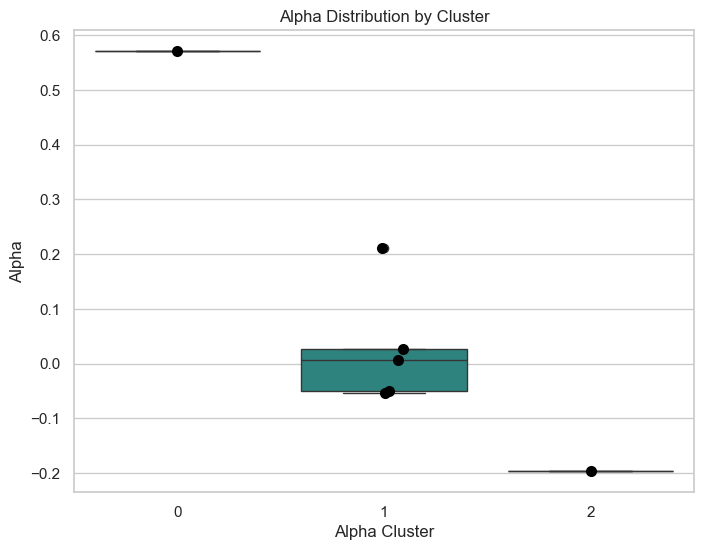

C:\Users\praba\AppData\Local\Temp\ipykernel_10984\2551134867.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='beta_cluster', y='beta', data=params_df, palette='viridis')


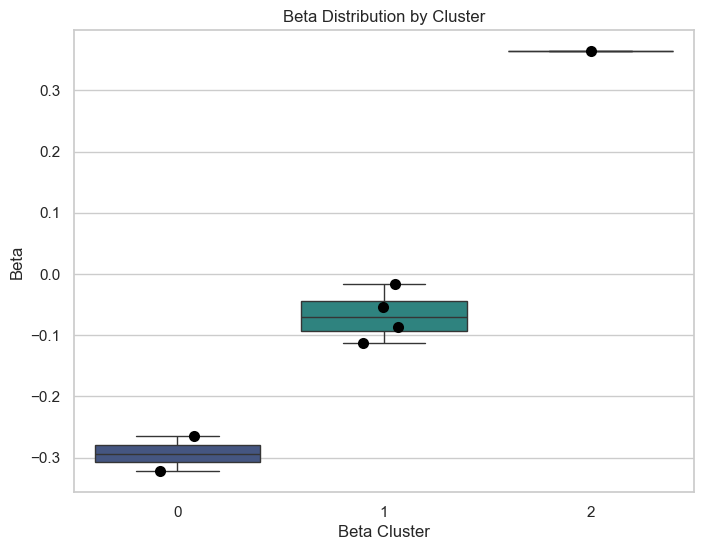

C:\Users\praba\AppData\Local\Temp\ipykernel_10984\2551134867.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='gamma_cluster', y='gamma', data=params_df, palette='viridis')


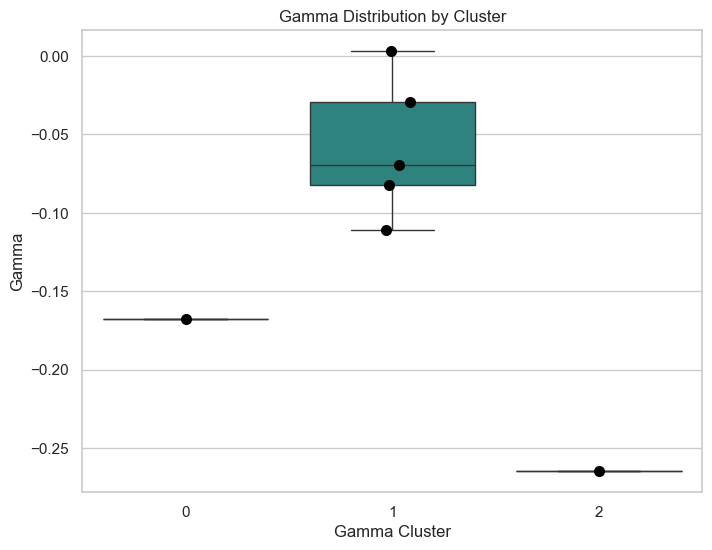

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

# Plot for alpha
plt.figure(figsize=(8, 6))
sns.boxplot(x='alpha_cluster', y='alpha', data=params_df, palette='viridis')
sns.stripplot(x='alpha_cluster', y='alpha', data=params_df, color='black', size=8, jitter=True)
plt.title('Alpha Distribution by Cluster')
plt.xlabel('Alpha Cluster')
plt.ylabel('Alpha')
plt.show()

# Plot for beta
plt.figure(figsize=(8, 6))
sns.boxplot(x='beta_cluster', y='beta', data=params_df, palette='viridis')
sns.stripplot(x='beta_cluster', y='beta', data=params_df, color='black', size=8, jitter=True)
plt.title('Beta Distribution by Cluster')
plt.xlabel('Beta Cluster')
plt.ylabel('Beta')
plt.show()

# Plot for gamma
plt.figure(figsize=(8, 6))
sns.boxplot(x='gamma_cluster', y='gamma', data=params_df, palette='viridis')
sns.stripplot(x='gamma_cluster', y='gamma', data=params_df, color='black', size=8, jitter=True)
plt.title('Gamma Distribution by Cluster')
plt.xlabel('Gamma Cluster')
plt.ylabel('Gamma')
plt.show()


C:\Users\praba\AppData\Local\Temp\ipykernel_10984\2577053300.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='alpha_cluster', y='alpha', data=params_df, palette='viridis', inner="quartile")


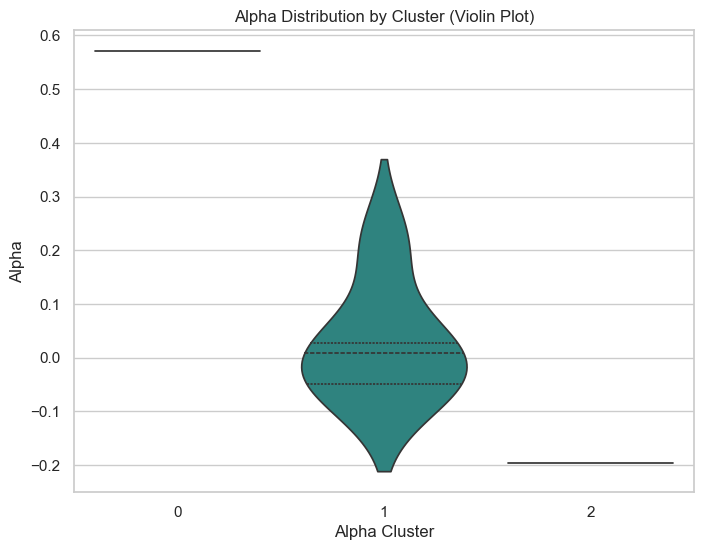

C:\Users\praba\AppData\Local\Temp\ipykernel_10984\2577053300.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='beta_cluster', y='beta', data=params_df, palette='viridis', inner="quartile")


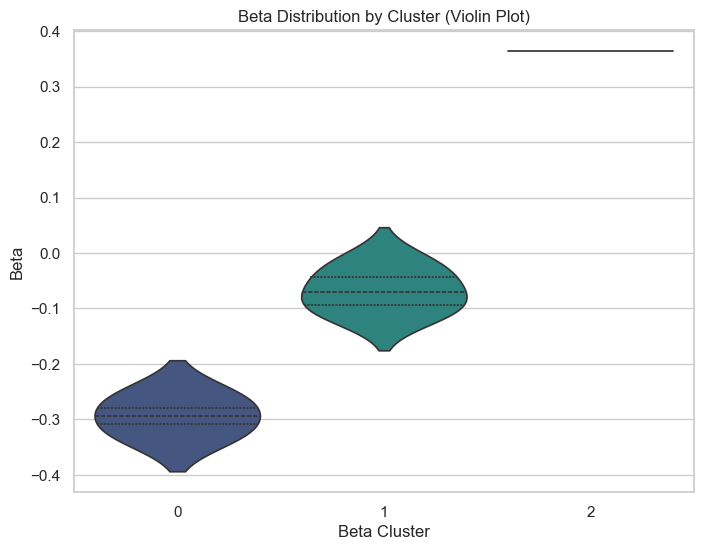

C:\Users\praba\AppData\Local\Temp\ipykernel_10984\2577053300.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='gamma_cluster', y='gamma', data=params_df, palette='viridis', inner="quartile")


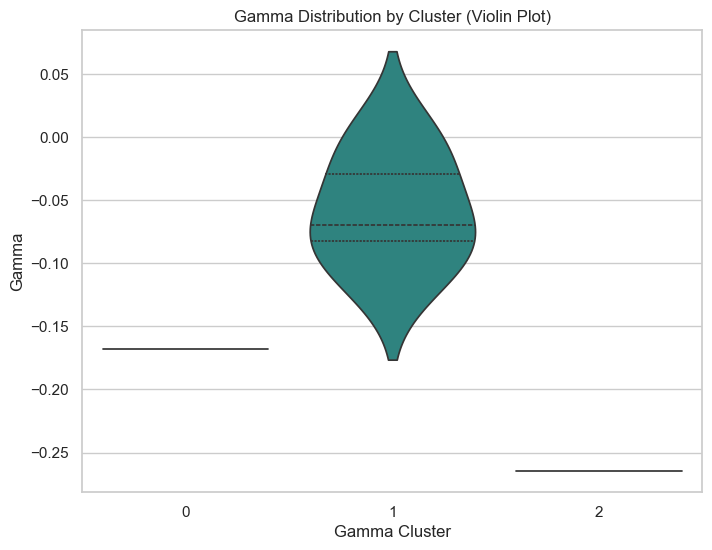

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

# Violin plot for alpha
plt.figure(figsize=(8, 6))
sns.violinplot(x='alpha_cluster', y='alpha', data=params_df, palette='viridis', inner="quartile")
plt.title('Alpha Distribution by Cluster (Violin Plot)')
plt.xlabel('Alpha Cluster')
plt.ylabel('Alpha')
plt.show()

# Violin plot for beta
plt.figure(figsize=(8, 6))
sns.violinplot(x='beta_cluster', y='beta', data=params_df, palette='viridis', inner="quartile")
plt.title('Beta Distribution by Cluster (Violin Plot)')
plt.xlabel('Beta Cluster')
plt.ylabel('Beta')
plt.show()

# Violin plot for gamma
plt.figure(figsize=(8, 6))
sns.violinplot(x='gamma_cluster', y='gamma', data=params_df, palette='viridis', inner="quartile")
plt.title('Gamma Distribution by Cluster (Violin Plot)')
plt.xlabel('Gamma Cluster')
plt.ylabel('Gamma')
plt.show()



## 1. Extending Cluster-Based Prediction

Let's implement code that uses the cluster parameters to predict gene expression trajectories for new test data:



In [23]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Define a function to predict gene expression using cluster-averaged parameters
def predict_with_cluster_params(time_points, y0, cluster_params):
    """
    Predict gene expression trajectory using cluster-averaged parameters.
    
    Args:
        time_points: tensor of time points
        y0: initial value tensor [1]
        cluster_params: tuple (alpha, beta, gamma) for the cluster
    
    Returns:
        Predicted trajectory
    """
    alpha, beta, gamma = cluster_params
    
    class ClusterODE(nn.Module):
        def forward(self, t, y):
            return alpha + beta * y + gamma * t
    
    model = ClusterODE()
    y_pred = odeint(model, y0, time_points).squeeze()
    
    return y_pred



## 2. Compute Cluster-Averaged Parameters



In [24]:
# Extract parameters from trained models
def extract_cluster_parameters(ode_models, clusters, df):
    """Extract and average parameters for each cluster."""
    cluster_params = {}
    
    for cluster_id in np.unique(clusters):
        # Get indices for this cluster
        indices = np.where(clusters == cluster_id)[0]
        
        # Extract parameters from models in this cluster
        alphas = [ode_models[i].alpha.item() for i in indices]
        betas = [ode_models[i].beta.item() for i in indices]
        gammas = [ode_models[i].gamma.item() for i in indices]
        
        # Calculate average parameters for this cluster
        avg_alpha = np.mean(alphas)
        avg_beta = np.mean(betas)
        avg_gamma = np.mean(gammas)
        
        # Store in dictionary
        cluster_params[cluster_id] = (avg_alpha, avg_beta, avg_gamma)
        
        print(f"Cluster {cluster_id} (n={len(indices)}):")
        print(f"  Genes: {', '.join([df['Unnamed: 0'][i] for i in indices])}")
        print(f"  α = {avg_alpha:.4f}, β = {avg_beta:.4f}, γ = {avg_gamma:.4f}\n")
    
    return cluster_params

# Get cluster parameters
params_array = []
with torch.no_grad():
    for i in range(len(ode_models)):
        params_array.append([
            ode_models[i].alpha.item(),
            ode_models[i].beta.item(),
            ode_models[i].gamma.item()
        ])
params_array = np.array(params_array)

# Scale parameters for clustering
scaler = StandardScaler()
scaled_params = scaler.fit_transform(params_array)

# Cluster using K-means (k=3)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled_params)

# Get cluster-averaged parameters
cluster_params = extract_cluster_parameters(ode_models, clusters, df)

Cluster 0 (n=1):
  Genes: AT1G04470
  α = 0.5707, β = -0.3223, γ = -0.1678

Cluster 1 (n=5):
  Genes: AT1G06930, AT5G66730, AT2G38472, AT2G38474, AT2G38470
  α = -0.0007, β = -0.1068, γ = -0.0579

Cluster 2 (n=1):
  Genes: AT5G40100
  α = -0.0502, β = 0.3639, γ = -0.2649



c:\Users\praba\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(




## 3. Test Data Generation and Cluster Assignment



In [25]:
# Generate synthetic test data
def generate_synthetic_test_data(n_genes=5, noise_level=0.1):
    """Generate synthetic test data with similar patterns to training data."""
    test_data = {
        "Gene_ID": [f"TEST_{i+1}" for i in range(n_genes)],
        "Day1": [
            -0.5,    # Similar to AT5G40100 (decreasing)
            1.7,     # Similar to AT1G06930 (decreasing)
            0.1,     # Similar to AT1G04470 (increasing then decreasing)
            0.06,    # Similar to AT5G66730 (slight changes)
            0.9      # Similar to AT2G38472 (decreasing)
        ],
        "Day2": [
            -1.0,    # Decreasing
            0.9,     # Decreasing
            1.0,     # Peak
            0.1,     # Slight increase
            0.5      # Decreasing
        ],
        "Day4": [
            -5.0,    # Sharp decrease
            0.2,     # Continued decrease
            0.2,     # Decrease from peak
            -0.1,    # Slight decrease
            0.1      # Continued decrease
        ]
    }
    
    # Add noise
    for day in ["Day1", "Day2", "Day4"]:
        test_data[day] = [x + np.random.normal(0, noise_level) for x in test_data[day]]
    
    return pd.DataFrame(test_data)

# Generate test data
test_df = generate_synthetic_test_data(noise_level=0.05)
print("Synthetic Test Data:")
print(test_df)

# Prepare test data for prediction
test_time_points = np.array([1.0, 2.0, 4.0])
test_time_points_tensor = torch.tensor(test_time_points, dtype=torch.float32, requires_grad=True)
test_values = test_df[["Day1", "Day2", "Day4"]].values
test_values_tensor = torch.tensor(test_values, dtype=torch.float32)

Synthetic Test Data:
  Gene_ID      Day1      Day2      Day4
0  TEST_1 -0.463020 -1.045776 -5.076686
1  TEST_2  1.713702  0.915851  0.271678
2  TEST_3  0.107190  0.974364  0.251650
3  TEST_4  0.034394  0.065099 -0.051692
4  TEST_5  0.898010  0.465141  0.044501




## 4. Cluster Assignment and Prediction



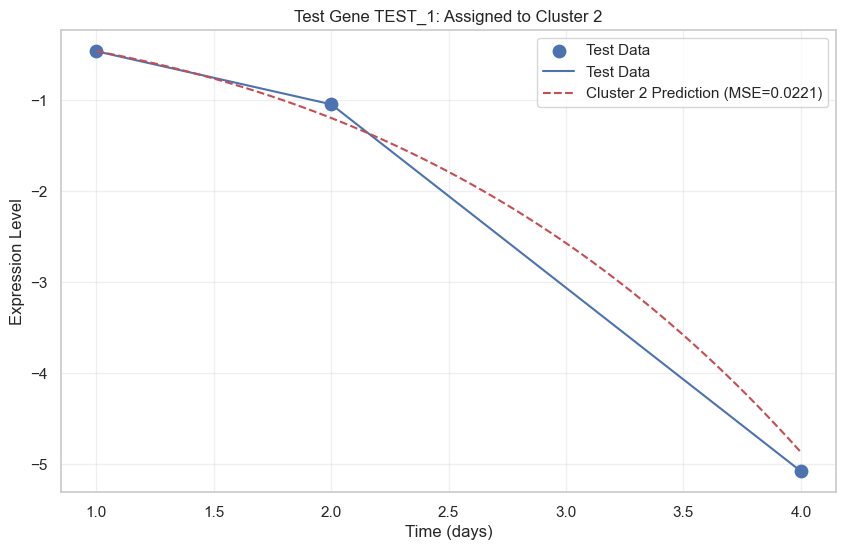

Cluster 2 ODE: dy/dt = -0.0502 + 0.3639*y + -0.2649*t
MSE: 0.0221



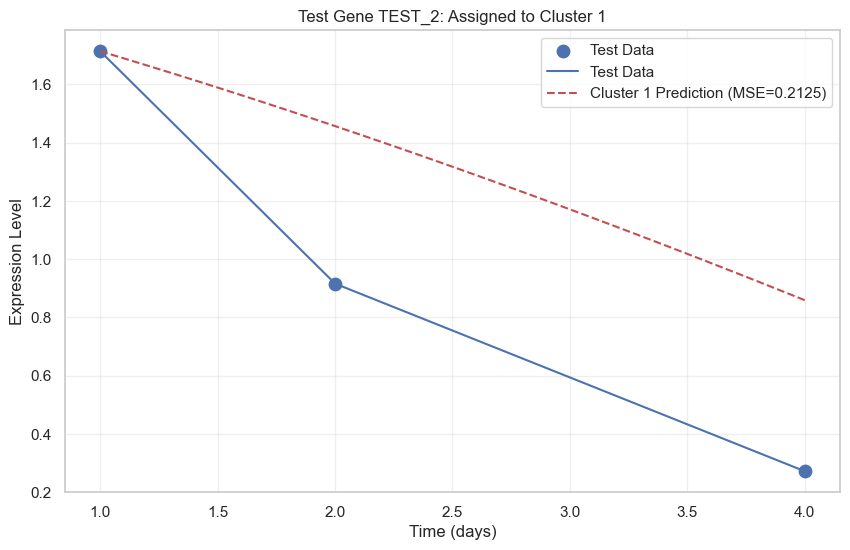

Cluster 1 ODE: dy/dt = -0.0007 + -0.1068*y + -0.0579*t
MSE: 0.2125



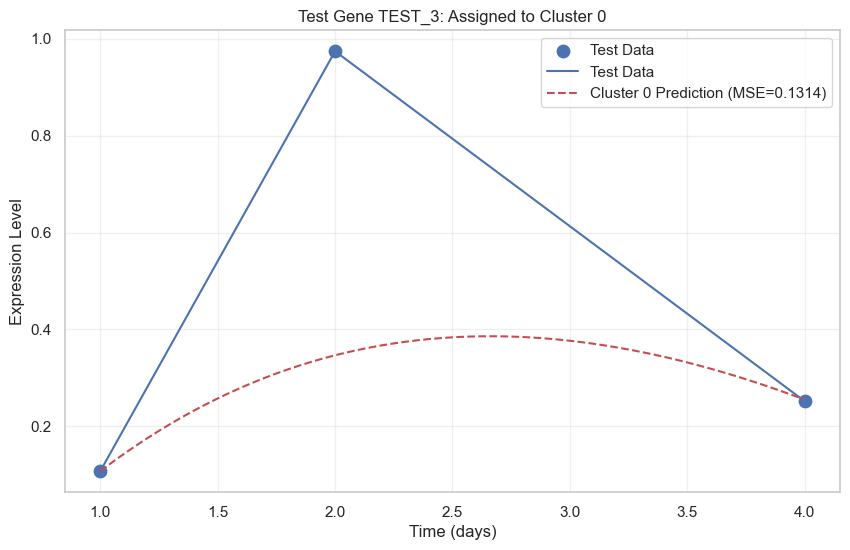

Cluster 0 ODE: dy/dt = 0.5707 + -0.3223*y + -0.1678*t
MSE: 0.1314



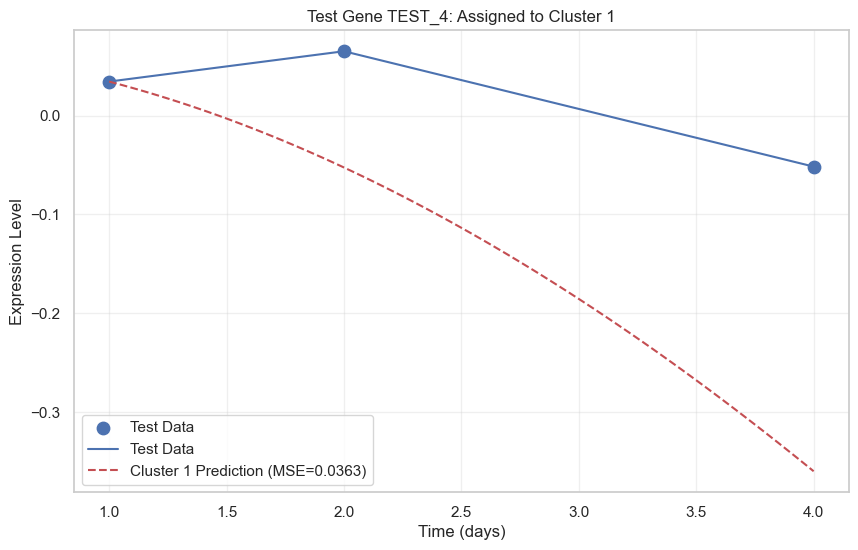

Cluster 1 ODE: dy/dt = -0.0007 + -0.1068*y + -0.0579*t
MSE: 0.0363



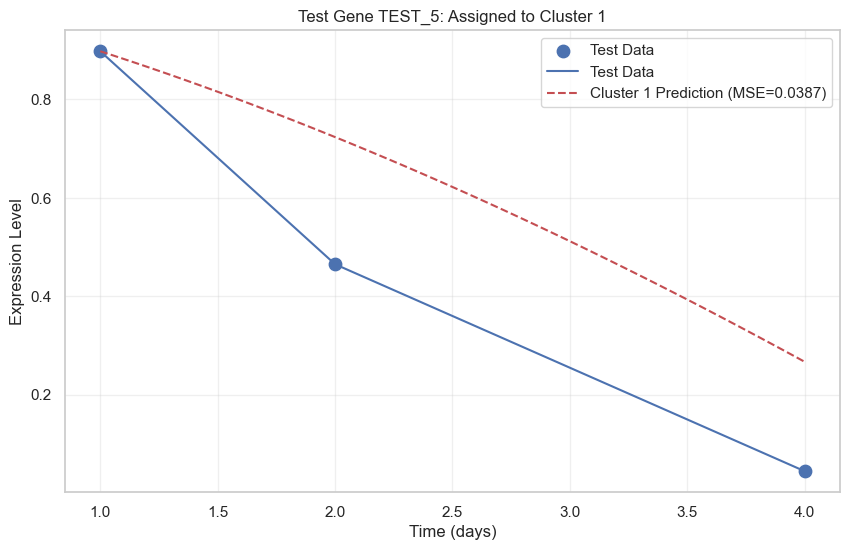

Cluster 1 ODE: dy/dt = -0.0007 + -0.1068*y + -0.0579*t
MSE: 0.0387


Test Gene Assignment Summary:
Gene      Cluster   MSE       
--------------------------------------------------
TEST_1    2         0.0221    
TEST_2    1         0.2125    
TEST_3    0         0.1314    
TEST_4    1         0.0363    
TEST_5    1         0.0387    


In [26]:
def assign_to_cluster_and_predict(test_gene_data, clusters, cluster_params, time_points_tensor):
    """
    Assign a test gene to the best-matching cluster and predict its trajectory.
    
    Args:
        test_gene_data: tensor of gene expression [n_timepoints]
        clusters: array of cluster assignments for training genes
        cluster_params: dictionary mapping cluster_id to (alpha, beta, gamma)
        time_points_tensor: tensor of time points
    
    Returns:
        best_cluster: int, best matching cluster ID
        prediction: tensor of predicted values
        mse: float, mean squared error between prediction and actual
    """
    # Initial value (Day1)
    y0 = test_gene_data[0].unsqueeze(0)
    
    # Try each cluster and compute error
    errors = []
    predictions = []
    
    for cluster_id in cluster_params:
        # Predict using this cluster's parameters
        pred = predict_with_cluster_params(
            time_points_tensor, 
            y0, 
            cluster_params[cluster_id]
        )
        
        # Calculate error
        mse = torch.mean((pred - test_gene_data)**2).item()
        errors.append(mse)
        predictions.append(pred.detach())
    
    # Find best cluster (lowest error)
    best_cluster = np.argmin(errors)
    best_error = errors[best_cluster]
    best_pred = predictions[best_cluster]
    
    return best_cluster, best_pred, best_error

# Evaluate test genes
results = []
fine_t = torch.linspace(1, 4, 100)

with torch.no_grad():
    for i in range(len(test_df)):
        gene_id = test_df["Gene_ID"][i]
        gene_data = test_values_tensor[i]
        
        # Find best cluster and get prediction
        best_cluster, prediction, error = assign_to_cluster_and_predict(
            gene_data, 
            clusters, 
            cluster_params, 
            test_time_points_tensor
        )
        
        # Generate fine-grained prediction for plotting
        y0 = gene_data[0].unsqueeze(0)
        fine_pred = predict_with_cluster_params(fine_t, y0, cluster_params[best_cluster])
        
        # Store results
        results.append({
            "gene_id": gene_id,
            "best_cluster": best_cluster,
            "error": error
        })
        
        # Plot
        plt.figure(figsize=(10, 6))
        plt.scatter(test_time_points, gene_data.numpy(), c='b', s=80, label="Test Data")
        plt.plot(test_time_points, gene_data.numpy(), 'b-', label="Test Data")
        plt.plot(fine_t.numpy(), fine_pred.numpy(), 'r--', 
                 label=f"Cluster {best_cluster} Prediction (MSE={error:.4f})")
        
        plt.title(f"Test Gene {gene_id}: Assigned to Cluster {best_cluster}")
        plt.xlabel("Time (days)")
        plt.ylabel("Expression Level")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.show()
        
        # Print cluster equation
        alpha, beta, gamma = cluster_params[best_cluster]
        print(f"Cluster {best_cluster} ODE: dy/dt = {alpha:.4f} + {beta:.4f}*y + {gamma:.4f}*t")
        print(f"MSE: {error:.4f}\n")

# Summarize results
print("\nTest Gene Assignment Summary:")
print("="*50)
print(f"{'Gene':<10}{'Cluster':<10}{'MSE':<10}")
print("-"*50)
for res in results:
    print(f"{res['gene_id']:<10}{res['best_cluster']:<10}{res['error']:<10.4f}")
print("="*50)



# 2. Pure Inverse PINN

Now, let's implement a pure Inverse PINN approach (without Neural ODE) for comparison:



In [32]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Define the neural network that approximates y(t)
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        # Here we still model y(t) with a neural network
        self.hidden = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 1)  # Output: y(t)
        )
        # Learnable ODE parameters for: dy/dt = α + β*y(t) + γ*t
        self.alpha = nn.Parameter(torch.tensor(1.0, requires_grad=True))
        self.beta  = nn.Parameter(torch.tensor(1.0, requires_grad=True))
        self.gamma = nn.Parameter(torch.tensor(1.0, requires_grad=True))

    def forward(self, t):
        return self.hidden(t)
    
    def get_ode_params(self):
    # """Return the learned parameters of the ODE"""

        return self.alpha.item(), self.beta.item(), self.gamma.item()

# Define the ODE loss function
def loss_fn(model, t, y_data):
    # Predict y(t) using the neural network; shape: (num_time_points,)
    y_pred = model(t).squeeze()

    # Compute dy/dt via autograd
    y_t = torch.autograd.grad(
        y_pred, t,
        grad_outputs=torch.ones_like(y_pred),
        create_graph=True
    )[0].squeeze()

    # Enforce that dy/dt equals the parametric ODE: α + β*y(t) + γ*t
    # Note: squeeze t to match y_pred's shape.
    ode_residual = y_t - (model.alpha + model.beta * y_pred + model.gamma * t.squeeze())

    physics_loss = torch.mean(ode_residual**2)
    data_loss = torch.mean((y_pred - y_data)**2)

    # Also enforce the initial condition (at the first time point)
    initial_condition_loss = (y_pred[0] - y_data[0])**2

    return data_loss + physics_loss + initial_condition_loss, data_loss, physics_loss


In [33]:

# Function to train the PINN model for a single gene
def train_pinn(gene_id, time_points, y_data, epochs=600, lr=0.01, lambda_physics=0.1):
    """
    Train a Physics-Informed Neural Network for a single gene
    
    Args:
        gene_id: ID of the gene
        time_points: Tensor of time points (requires_grad=True)
        y_data: Tensor of gene expression values
        epochs: Number of training epochs
        lr: Learning rate
        lambda_physics: Weight for physics loss
        
    Returns:
        model: Trained PINN model
        losses: List of losses during training
    """
    # Initialize model
    model = NeuralNet()
    
    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # For tracking progress
    losses = []
    
    # Training loop
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        total_loss, data_loss, physics_loss = loss_fn(model, time_points, y_data)
        
        # Store loss for plotting
        losses.append(total_loss.item())
        
        # Backpropagation
        total_loss.backward()
        optimizer.step()
        
        # Print progress
        if epoch % 100 == 0:
            print(f"  Epoch {epoch}: Total Loss = {total_loss.item():.6f}, "
                  f"Data Loss = {data_loss.item():.6f}, "
                  f"Physics Loss = {physics_loss.item():.6f}")
            
    return model, losses


In [34]:

# Load data from CSV
df = pd.read_csv("arabido_example_genes.csv")
print("Original Data:")
print(df)

# Time points (in days)
time_points = np.array([1.0, 2.0, 4.0], dtype=np.float32)  # Day1, Day2, Day4

# Extract gene expression data (each row is one gene)
gene_data = df[["Hpa-NO_1d", "Hpa-NO_2d", "Hpa-NO_4d"]].values

# Convert to PyTorch tensors
time_points_tensor = torch.tensor(time_points, dtype=torch.float32, requires_grad=True).view(-1, 1)
gene_data_tensor = torch.tensor(gene_data, dtype=torch.float32)

Original Data:
  Unnamed: 0  Hpa-NO_1d  Hpa-NO_2d  Hpa-NO_4d
0  AT5G40100  -0.447960  -0.560155  -5.091964
1  AT1G06930   1.778359   0.000000   0.000000
2  AT1G04470   0.000000   1.175150   0.000000
3  AT5G66730   0.055375   0.098435  -0.101757
4  AT2G38472   0.900000   0.500000   0.000000
5  AT2G38474   0.000000   0.500000   0.000000
6  AT2G38470   0.906000   0.906000   0.906000



Training PINN model for gene AT5G40100 (1/7):
  Epoch 0: Total Loss = 23.033703, Data Loss = 9.554893, Physics Loss = 13.253871


  Epoch 100: Total Loss = 0.246117, Data Loss = 0.040349, Physics Loss = 0.149318
  Epoch 200: Total Loss = 0.007971, Data Loss = 0.002531, Physics Loss = 0.002379
  Epoch 300: Total Loss = 0.030012, Data Loss = 0.008930, Physics Loss = 0.021082
  Epoch 400: Total Loss = 0.000086, Data Loss = 0.000032, Physics Loss = 0.000025
  Epoch 500: Total Loss = 0.000004, Data Loss = 0.000001, Physics Loss = 0.000001
[-0.44847488 -0.55675036 -5.0856166 ]


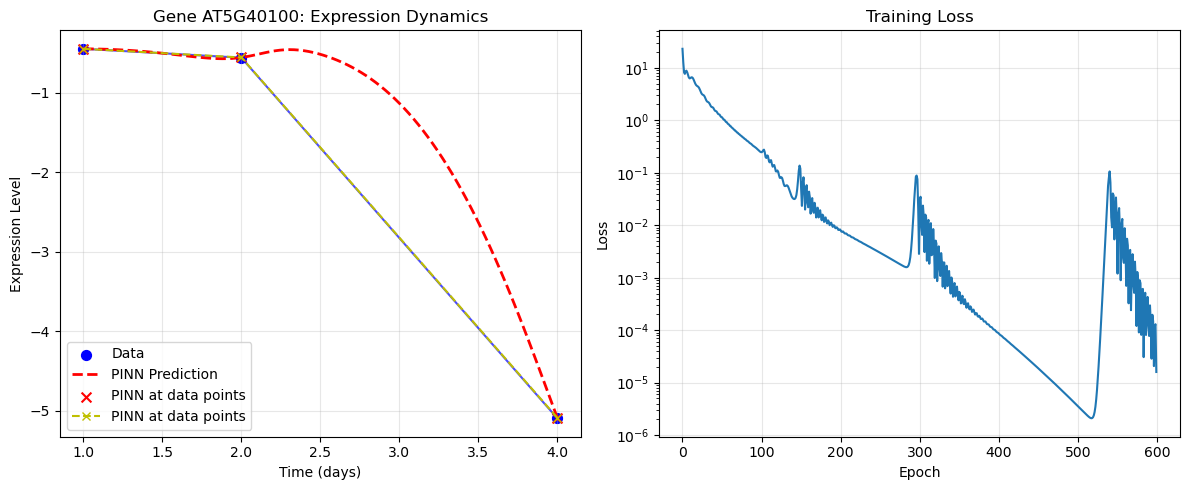

Learned ODE for AT5G40100: dy/dt = 0.1968 + 1.4361 * y + 0.4433 * t
MSE: 0.000017

Training PINN model for gene AT1G06930 (2/7):
  Epoch 0: Total Loss = 17.138277, Data Loss = 1.318462, Physics Loss = 11.874734
  Epoch 100: Total Loss = 0.505128, Data Loss = 0.335955, Physics Loss = 0.169172
  Epoch 200: Total Loss = 0.063701, Data Loss = 0.046627, Physics Loss = 0.017072
  Epoch 300: Total Loss = 0.000080, Data Loss = 0.000021, Physics Loss = 0.000053
  Epoch 400: Total Loss = 0.000000, Data Loss = 0.000000, Physics Loss = 0.000000
  Epoch 500: Total Loss = 0.000000, Data Loss = 0.000000, Physics Loss = 0.000000
[ 1.7783592e+00 -4.0978193e-07 -4.4703484e-07]


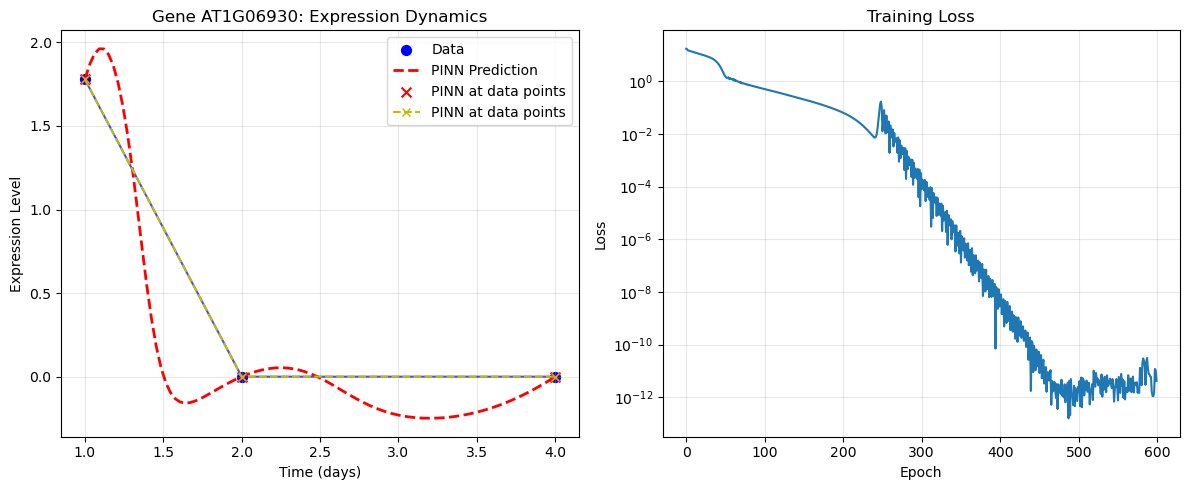

Learned ODE for AT1G06930: dy/dt = 0.2072 + 1.7259 * y + 0.0971 * t
MSE: 0.000000

Training PINN model for gene AT1G04470 (3/7):
  Epoch 0: Total Loss = 13.123073, Data Loss = 0.429620, Physics Loss = 12.688666
  Epoch 100: Total Loss = 0.615101, Data Loss = 0.322219, Physics Loss = 0.272771
  Epoch 200: Total Loss = 0.000113, Data Loss = 0.000046, Physics Loss = 0.000054
  Epoch 300: Total Loss = 0.000000, Data Loss = 0.000000, Physics Loss = 0.000000
  Epoch 400: Total Loss = 0.000000, Data Loss = 0.000000, Physics Loss = 0.000000
  Epoch 500: Total Loss = 0.000000, Data Loss = 0.000000, Physics Loss = 0.000000
[1.0174699e-07 1.1751496e+00 3.2526441e-07]


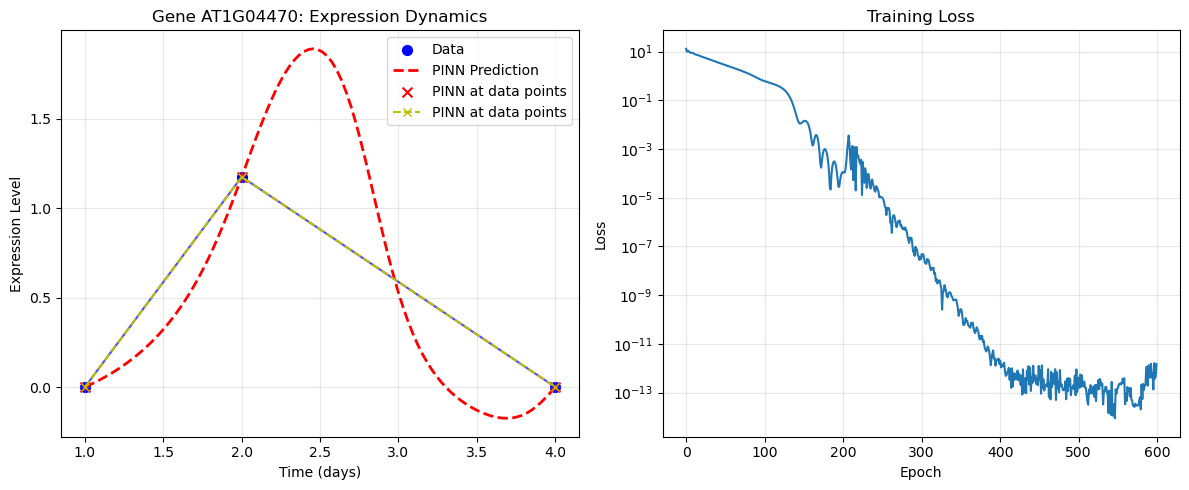

Learned ODE for AT1G04470: dy/dt = 0.1773 + 1.5186 * y + 0.2107 * t
MSE: 0.000000

Training PINN model for gene AT5G66730 (4/7):
  Epoch 0: Total Loss = 10.491358, Data Loss = 0.213069, Physics Loss = 10.127564
  Epoch 100: Total Loss = 0.192251, Data Loss = 0.149001, Physics Loss = 0.043194
  Epoch 200: Total Loss = 0.000007, Data Loss = 0.000005, Physics Loss = 0.000002
  Epoch 300: Total Loss = 0.000000, Data Loss = 0.000000, Physics Loss = 0.000000
  Epoch 400: Total Loss = 0.000310, Data Loss = 0.000046, Physics Loss = 0.000206
  Epoch 500: Total Loss = 0.000000, Data Loss = 0.000000, Physics Loss = 0.000000
[ 0.05537605  0.09843637 -0.10175613]


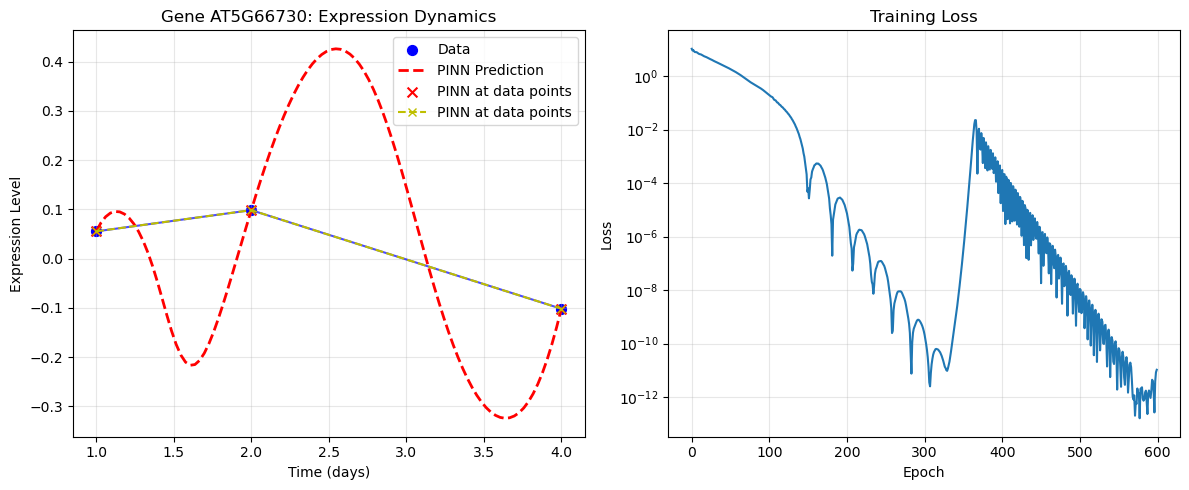

Learned ODE for AT5G66730: dy/dt = 0.2919 + 1.5959 * y + 0.2921 * t
MSE: 0.000000

Training PINN model for gene AT2G38472 (5/7):
  Epoch 0: Total Loss = 12.491783, Data Loss = 0.926704, Physics Loss = 10.036501
  Epoch 100: Total Loss = 0.584964, Data Loss = 0.405437, Physics Loss = 0.179385
  Epoch 200: Total Loss = 0.101602, Data Loss = 0.069928, Physics Loss = 0.031207
  Epoch 300: Total Loss = 0.000005, Data Loss = 0.000004, Physics Loss = 0.000001
  Epoch 400: Total Loss = 0.000015, Data Loss = 0.000005, Physics Loss = 0.000010
  Epoch 500: Total Loss = 0.000000, Data Loss = 0.000000, Physics Loss = 0.000000
[ 0.8996767   0.49881816 -0.00124814]


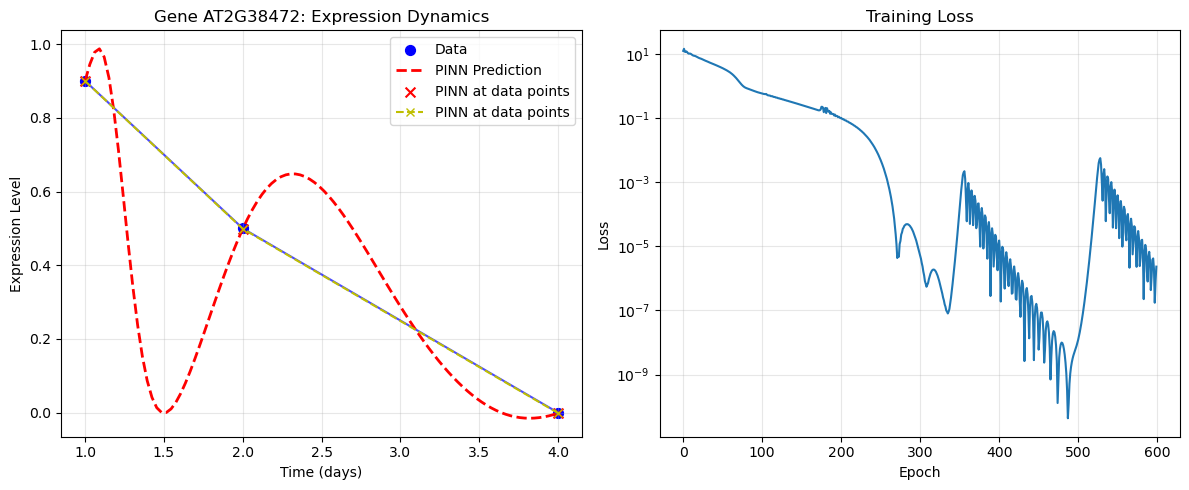

Learned ODE for AT2G38472: dy/dt = 0.0672 + 1.6653 * y + 0.0186 * t
MSE: 0.000001

Training PINN model for gene AT2G38474 (6/7):
  Epoch 0: Total Loss = 12.148342, Data Loss = 0.132892, Physics Loss = 11.994899
  Epoch 100: Total Loss = 0.415794, Data Loss = 0.269840, Physics Loss = 0.139616
  Epoch 200: Total Loss = 0.000012, Data Loss = 0.000009, Physics Loss = 0.000003
  Epoch 300: Total Loss = 0.000000, Data Loss = 0.000000, Physics Loss = 0.000000
  Epoch 400: Total Loss = 0.000000, Data Loss = 0.000000, Physics Loss = 0.000000
  Epoch 500: Total Loss = 0.000000, Data Loss = 0.000000, Physics Loss = 0.000000
[3.7252903e-07 5.0000083e-01 7.0035458e-07]


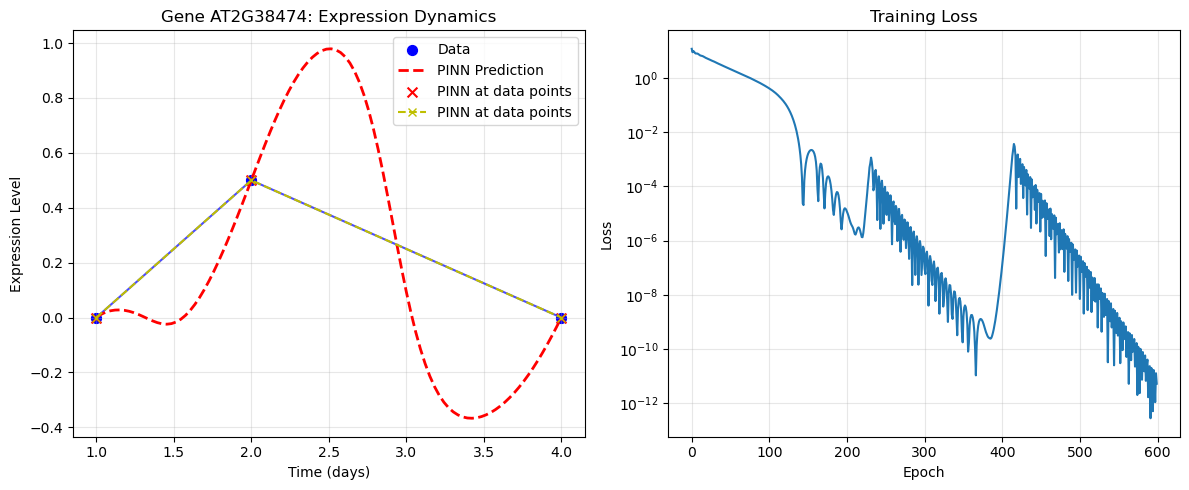

Learned ODE for AT2G38474: dy/dt = 0.2282 + 1.6130 * y + 0.2261 * t
MSE: 0.000000

Training PINN model for gene AT2G38470 (7/7):
  Epoch 0: Total Loss = 13.445135, Data Loss = 2.114943, Physics Loss = 9.590840
  Epoch 100: Total Loss = 0.995358, Data Loss = 0.591637, Physics Loss = 0.401892
  Epoch 200: Total Loss = 0.000679, Data Loss = 0.000575, Physics Loss = 0.000101
  Epoch 300: Total Loss = 0.000014, Data Loss = 0.000001, Physics Loss = 0.000011
  Epoch 400: Total Loss = 0.000000, Data Loss = 0.000000, Physics Loss = 0.000000
  Epoch 500: Total Loss = 0.000195, Data Loss = 0.000035, Physics Loss = 0.000127
[0.9059943 0.9060069 0.9060097]


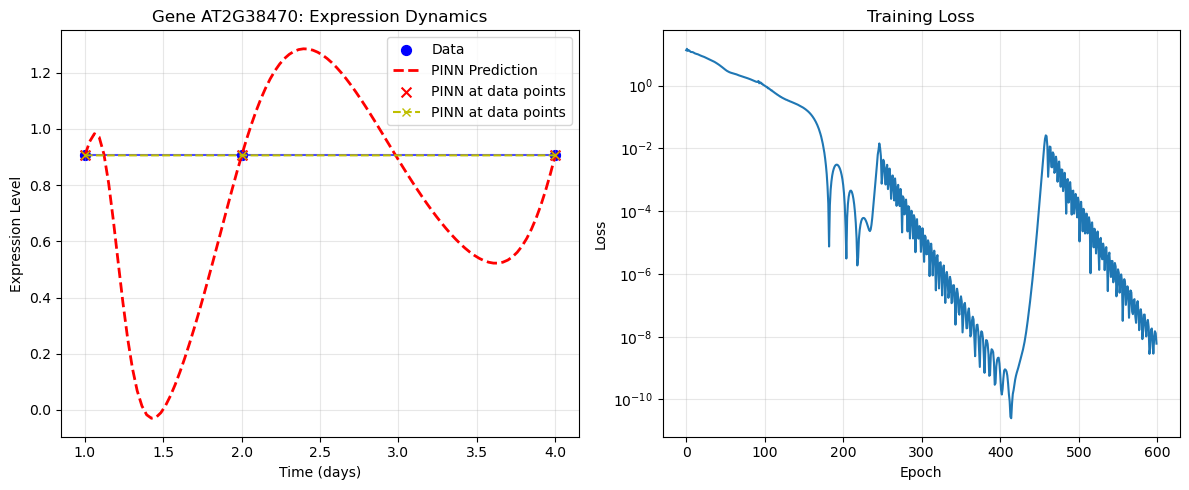

Learned ODE for AT2G38470: dy/dt = 0.2001 + 1.5216 * y + 0.1595 * t
MSE: 0.000000

Learned parameters with cluster assignments:
      alpha      beta     gamma    gene_id  cluster
0  0.196849  1.436124  0.443261  AT5G40100        2
1  0.207240  1.725898  0.097130  AT1G06930        1
2  0.177277  1.518552  0.210680  AT1G04470        0
3  0.291859  1.595881  0.292140  AT5G66730        1
4  0.067159  1.665267  0.018560  AT2G38472        3
5  0.228233  1.613020  0.226064  AT2G38474        1
6  0.200077  1.521567  0.159467  AT2G38470        0


c:\Users\praba\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [38]:
# Train models for each gene and visualize results
models = []
all_params = []

for i, gene_id in enumerate(df['Unnamed: 0']):
    print(f"\nTraining PINN model for gene {gene_id} ({i+1}/{len(df)}):")
    gene_values = gene_data_tensor[i]
    model, losses = train_pinn(gene_id, time_points_tensor, gene_values)
    models.append(model)
    
    # Get learned parameters
    alpha, beta, gamma = model.get_ode_params()
    all_params.append([alpha, beta, gamma])
    
    # Generate smooth predictions
    t_fine = torch.linspace(1, 4, 100).reshape(-1, 1)
    with torch.no_grad():
        y_fine = model(t_fine).squeeze().numpy()
        y_pred = model(time_points_tensor).squeeze().detach().numpy()
    
    # Plot results
    plt.figure(figsize=(12, 5))
    
    # Plot 1: Data and predictions
    print(y_pred)
    plt.subplot(1, 2, 1)
    plt.scatter(time_points, gene_values.numpy(), c='b', s=50, label="Data")
    plt.plot(time_points, gene_values.numpy(), 'b-', alpha=0.7)
    plt.plot(t_fine.numpy(), y_fine, 'r--', linewidth=2, label="PINN Prediction")
    plt.scatter(time_points, y_pred, c='r', marker='x', s=50, label="PINN at data points")
    plt.plot(time_points, y_pred, 'y--', marker='x', label="PINN at data points")
    plt.title(f"Gene {gene_id}: Expression Dynamics")
    plt.xlabel("Time (days)")
    plt.ylabel("Expression Level")
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Plot 2: Loss curve
    plt.subplot(1, 2, 2)
    plt.plot(losses)
    plt.title(f"Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.yscale('log')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print learned ODE
    print(f"Learned ODE for {gene_id}: dy/dt = {alpha:.4f} + {beta:.4f} * y + {gamma:.4f} * t")
    print(f"MSE: {np.mean((y_pred - gene_values.numpy())**2):.6f}")

# Store the parameters in a DataFrame for further analysis
all_params_df = pd.DataFrame(all_params, columns=['alpha', 'beta', 'gamma'])
all_params_df['gene_id'] = df['Unnamed: 0'].values

# Perform clustering on the learned parameters
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Scale the parameters for clustering
scaler = StandardScaler()
params_scaled = scaler.fit_transform(all_params_df[['alpha', 'beta', 'gamma']])

# Perform clustering (e.g., k=4 clusters)
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(params_scaled)

# Add cluster assignments to the DataFrame
all_params_df['cluster'] = clusters

# Print the final DataFrame
print("\nLearned parameters with cluster assignments:")
print(all_params_df)

# Save the DataFrame to a CSV file for further analysis
all_params_df.to_csv("learned_parameters_with_clusters.csv", index=False)

Synthetic Point 0:
  Actual Derivative: [-0.34432   -0.9490575 -2.1585325]
  Predicted Derivative: [-0.00878827 -0.06001348 -5.37333214]
  Satisfies Model: False

Synthetic Point 1:
  Actual Derivative: [-0.396208 -1.005107 -2.222905]
  Predicted Derivative: [ 0.14906617  0.02332336 -5.47488908]
  Satisfies Model: False



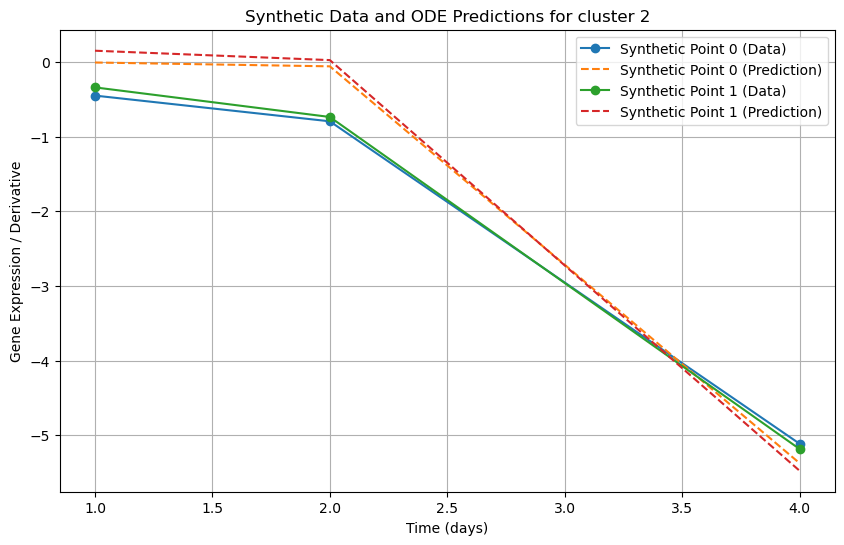

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Given parameters for cluster 2
alpha = 0.196849
beta = 1.436124 
gamma = 0.443261

# Synthetic data points in cluster 2
# synthetic_cluster_2 = pd.DataFrame({
#     "Hpa-NO_1d": [-0.451840, -0.341923, -0.453931, -0.571841],
#     "Hpa-NO_2d": [-0.796160, -0.738131, -0.386800, -0.574107]
#     "Hpa-NO_4d": [-5.113225, -5.183941, -5.105513, -5.057426]
# })
synthetic_cluster_2 = pd.DataFrame({
    "Hpa-NO_1d": [-0.451840, -0.341923, ],
    "Hpa-NO_2d": [-0.796160, -0.738131, ],
    "Hpa-NO_4d": [-5.113225, -5.183941,   ]
})

# Time points corresponding to the columns
time_points = np.array([1.0, 2.0, 4.0])  # Day 1, Day 2, Day 4

# Function to compute the ODE prediction
def compute_ode_prediction(y, t, alpha, beta, gamma):
    return alpha + beta * y + gamma * t

# Check if the synthetic data satisfies the ODE model
results = []
for index, row in synthetic_cluster_2.iterrows():
    y_values = row.values  # Extract y(t) values
    dy_dt_actual = np.gradient(y_values, time_points)  # Compute actual derivative using finite differences
    dy_dt_predicted = compute_ode_prediction(y_values, time_points, alpha, beta, gamma)  # Predicted derivative
    satisfies_model = np.allclose(dy_dt_actual, dy_dt_predicted, atol=0.1)  # Check if actual ≈ predicted
    results.append({
        "Synthetic Point": index,
        "Actual Derivative": dy_dt_actual,
        "Predicted Derivative": dy_dt_predicted,
        "Satisfies Model": satisfies_model
    })

# Display results
for result in results:
    print(f"Synthetic Point {result['Synthetic Point']}:")
    print(f"  Actual Derivative: {result['Actual Derivative']}")
    print(f"  Predicted Derivative: {result['Predicted Derivative']}")
    print(f"  Satisfies Model: {result['Satisfies Model']}")
    print()

# Plot the synthetic data and predictions
plt.figure(figsize=(10, 6))
for index, row in synthetic_cluster_2.iterrows():
    y_values = row.values  # Extract y(t) values
    dy_dt_predicted = compute_ode_prediction(y_values, time_points, alpha, beta, gamma)  # Predicted derivative

    # Plot synthetic data
    plt.plot(time_points, y_values, 'o-', label=f"Synthetic Point {index} (Data)")

    # Plot predicted values
    plt.plot(time_points, dy_dt_predicted, '--', label=f"Synthetic Point {index} (Prediction)")

plt.xlabel("Time (days)")
plt.ylabel("Gene Expression / Derivative")
plt.title("Synthetic Data and ODE Predictions for cluster 2")
plt.legend()
plt.grid(True)
plt.show()

Synthetic Point 0:
  Actual Derivative: [0.36042123 2.57740055 7.01135919]
  Predicted Derivative: [-8.78826816e-03  9.52082311e-01  2.19769667e+01]
  Satisfies Model: False



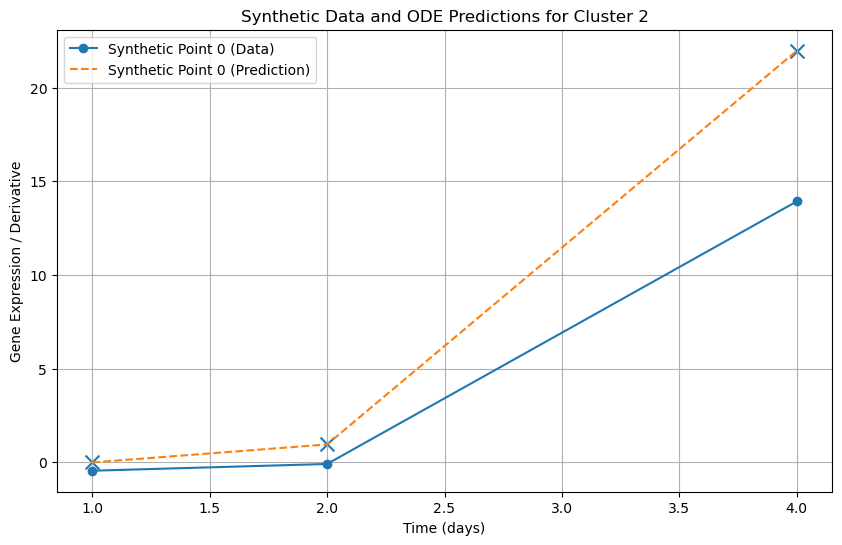

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Given parameters for cluster 2
alpha = 0.196849
beta = 1.436124
gamma = 0.443261

# Time points corresponding to the columns
time_points = np.array([1.0, 2.0, 4.0])  # Day 1, Day 2, Day 4

# Function to define the ODE: dy/dt = alpha + beta * y + gamma * t
def ode_model(y, t, alpha, beta, gamma):
    return alpha + beta * y + gamma * t

# Generate synthetic data by solving the ODE
initial_conditions = [-0.451840,]  # Initial conditions for synthetic data points
synthetic_data = []

for y0 in initial_conditions:
    y_solution = odeint(ode_model, y0, time_points, args=(alpha, beta, gamma)).flatten()
    synthetic_data.append(y_solution)

# Convert synthetic data to a DataFrame
synthetic_cluster_2 = pd.DataFrame(synthetic_data, columns=["Hpa-NO_1d", "Hpa-NO_2d", "Hpa-NO_4d"])

# Function to compute the ODE prediction
def compute_ode_prediction(y, t, alpha, beta, gamma):
    return alpha + beta * y + gamma * t

# Check if the synthetic data satisfies the ODE model
results = []
for index, row in synthetic_cluster_2.iterrows():
    y_values = row.values  # Extract y(t) values
    dy_dt_actual = np.gradient(y_values, time_points)  # Compute actual derivative using finite differences
    dy_dt_predicted = compute_ode_prediction(y_values, time_points, alpha, beta, gamma)  # Predicted derivative
    satisfies_model = np.allclose(dy_dt_actual, dy_dt_predicted, atol=0.1)  # Check if actual ≈ predicted
    results.append({
        "Synthetic Point": index,
        "Actual Derivative": dy_dt_actual,
        "Predicted Derivative": dy_dt_predicted,
        "Satisfies Model": satisfies_model
    })

# Display results
for result in results:
    print(f"Synthetic Point {result['Synthetic Point']}:")
    print(f"  Actual Derivative: {result['Actual Derivative']}")
    print(f"  Predicted Derivative: {result['Predicted Derivative']}")
    print(f"  Satisfies Model: {result['Satisfies Model']}")
    print()

# Plot the synthetic data and predictions
plt.figure(figsize=(10, 6))
for index, row in synthetic_cluster_2.iterrows():
    y_values = row.values  # Extract y(t) values
    dy_dt_predicted = compute_ode_prediction(y_values, time_points, alpha, beta, gamma)  # Predicted derivative

    # Plot synthetic data
    plt.plot(time_points, y_values, 'o-', label=f"Synthetic Point {index} (Data)")

    # Plot predicted values
    plt.plot(time_points, dy_dt_predicted, '--', label=f"Synthetic Point {index} (Prediction)")
    plt.scatter(time_points, dy_dt_predicted, marker='x', s=100)

plt.xlabel("Time (days)")
plt.ylabel("Gene Expression / Derivative")
plt.title("Synthetic Data and ODE Predictions for Cluster 2")
plt.legend()
plt.grid(True)
plt.show()

c:\Users\praba\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Synthetic Data:
          Unnamed: 0  Hpa-NO_1d  Hpa-NO_2d  Hpa-NO_4d  cluster
0   SYNTHETIC_0_7375   0.218027   1.012739   0.139721        0
1   SYNTHETIC_0_2220  -0.325258   1.027454  -0.073312        0
2   SYNTHETIC_0_2882  -0.131210   1.330801   0.093685        0
3   SYNTHETIC_0_5909   0.253375   1.392200  -0.244124        0
4   SYNTHETIC_1_7401   0.382392   0.273740  -0.047931        1
5   SYNTHETIC_1_6511   0.462190   0.332045  -0.199485        1
6   SYNTHETIC_1_5639  -0.217922   0.048863   0.151243        1
7   SYNTHETIC_1_1443  -0.030695   0.336699  -0.036365        1
8   SYNTHETIC_2_4906  -0.479013  -0.413844  -5.090982        2
9   SYNTHETIC_2_6042  -0.380061  -0.613814  -5.351425        2
10  SYNTHETIC_2_7209  -0.509320  -0.296524  -5.211923        2
11  SYNTHETIC_2_2058  -0.569371  -0.752861  -5.189023        2
12  SYNTHETIC_3_9817   1.346573   0.784426   0.421983        3
13  SYNTHETIC_3_8572   1.001114   0.848430   0.096175        3
14  SYNTHETIC_3_7039   1.331687   0.412

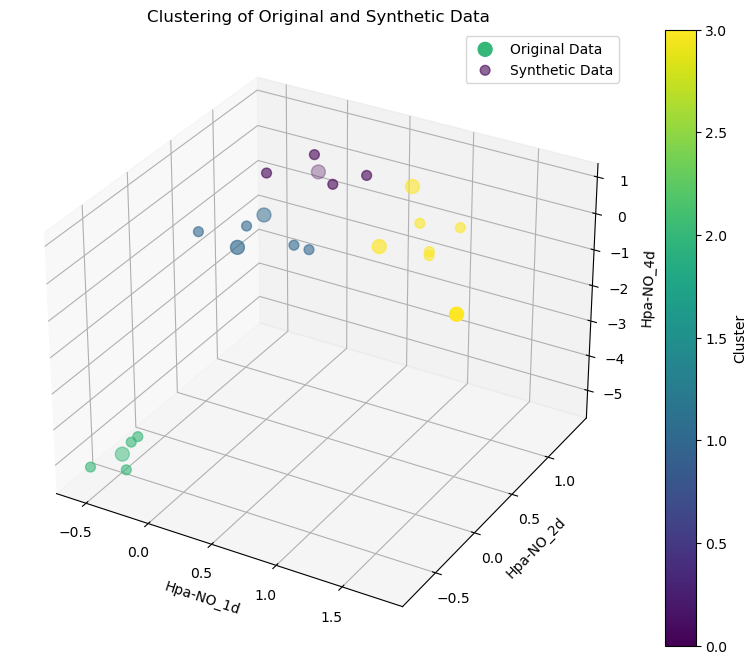

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Original data (example structure)
original_data = pd.DataFrame({
    "Unnamed: 0": ["AT5G40100", "AT1G06930", "AT1G04470", "AT5G66730", "AT2G38472", "AT2G38474", "AT2G38470"],
    "Hpa-NO_1d": [-0.447960, 1.778359, 0.000000, 0.055375, 0.900000, 0.000000, 0.906000],
    "Hpa-NO_2d": [-0.560155, 0.000000, 1.175150, 0.098435, 0.500000, 0.500000, 0.906000],
    "Hpa-NO_4d": [-5.091964, 0.000000, 0.000000, -0.101757, 0.000000, 0.000000, 0.906000]
})

# Extract numerical data for clustering
X = original_data[["Hpa-NO_1d", "Hpa-NO_2d", "Hpa-NO_4d"]].values

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform clustering (e.g., k=4 clusters)
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to the original data
original_data["cluster"] = clusters

# Generate synthetic data based on cluster centroids
centroids = kmeans.cluster_centers_
centroids_original = scaler.inverse_transform(centroids)  # Transform centroids back to original scale

# Number of synthetic samples per cluster
num_synthetic_samples_per_cluster = 4

# Generate synthetic data
synthetic_data = []
for cluster_idx, centroid in enumerate(centroids_original):
    # Add random noise around the centroid to generate synthetic points
    noise = np.random.normal(scale=0.2, size=(num_synthetic_samples_per_cluster, 3))  # Adjust scale for noise level
    cluster_synthetic_points = centroid + noise
    for point in cluster_synthetic_points:
        synthetic_data.append({
            "Unnamed: 0": f"SYNTHETIC_{cluster_idx}_{np.random.randint(1000, 9999)}",
            "Hpa-NO_1d": point[0],
            "Hpa-NO_2d": point[1],
            "Hpa-NO_4d": point[2],
            "cluster": cluster_idx
        })

# Convert synthetic data to DataFrame
synthetic_df = pd.DataFrame(synthetic_data)

# Combine original and synthetic data for comparison
combined_data = pd.concat([original_data, synthetic_df], ignore_index=True)

# Print synthetic data
print("Synthetic Data:")
print(synthetic_df)

# Print combined data
print("\nCombined Data:")
print(combined_data)

# Visualize the clusters in 3D parameter space
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot original data
scatter_original = ax.scatter(
    original_data["Hpa-NO_1d"], original_data["Hpa-NO_2d"], original_data["Hpa-NO_4d"],
    c=original_data["cluster"], cmap='viridis', s=100, label="Original Data"
)

# Plot synthetic data
scatter_synthetic = ax.scatter(
    synthetic_df["Hpa-NO_1d"], synthetic_df["Hpa-NO_2d"], synthetic_df["Hpa-NO_4d"],
    c=synthetic_df["cluster"], cmap='viridis', s=50, alpha=0.6, label="Synthetic Data"
)

ax.set_xlabel("Hpa-NO_1d")
ax.set_ylabel("Hpa-NO_2d")
ax.set_zlabel("Hpa-NO_4d")
ax.set_title("Clustering of Original and Synthetic Data")
plt.colorbar(scatter_original, ax=ax, label="Cluster")
plt.legend()
plt.show()


Learned Parameters Summary:
        Gene     Alpha      Beta     Gamma
0  AT5G40100  0.158772  1.441907  0.423733
1  AT1G06930  0.318225  1.593497  0.280467
2  AT1G04470  0.256754  1.551588  0.277585
3  AT5G66730  0.169387  1.645118  0.158098
4  AT2G38472  0.101174  1.676101 -0.010626
5  AT2G38474 -0.031414  1.645422 -0.062694
6  AT2G38470  0.187018  1.536218  0.097197

Cluster Assignments:
[2 0 0 3 3 1 0]

Cluster Assignments:
        Gene  Cluster
0  AT5G40100        2
1  AT1G06930        0
2  AT1G04470        0
3  AT5G66730        3
4  AT2G38472        3
5  AT2G38474        1
6  AT2G38470        0


c:\Users\praba\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


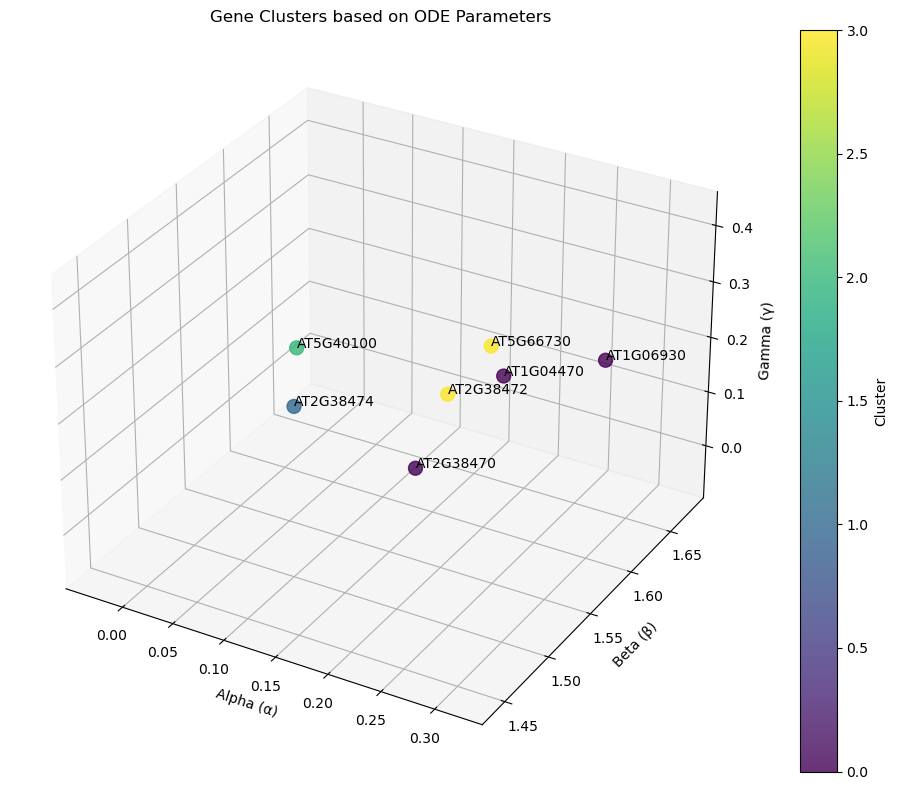


Cluster Statistics:

Cluster 0 - 3 genes:
Genes: AT1G06930, AT1G04470, AT2G38470
Alpha: mean = 0.2540, std = 0.0656
Beta:  mean = 1.5604, std = 0.0296
Gamma: mean = 0.2184, std = 0.1050

Cluster 1 - 1 genes:
Genes: AT2G38474
Alpha: mean = -0.0314, std = nan
Beta:  mean = 1.6454, std = nan
Gamma: mean = -0.0627, std = nan

Cluster 2 - 1 genes:
Genes: AT5G40100
Alpha: mean = 0.1588, std = nan
Beta:  mean = 1.4419, std = nan
Gamma: mean = 0.4237, std = nan

Cluster 3 - 2 genes:
Genes: AT5G66730, AT2G38472
Alpha: mean = 0.1353, std = 0.0482
Beta:  mean = 1.6606, std = 0.0219
Gamma: mean = 0.0737, std = 0.1193


In [36]:

# Convert parameters to array for clustering
param_array = np.array(all_params)

# Create parameter summary dataframe
param_df = pd.DataFrame({
    'Gene': df['Unnamed: 0'],
    'Alpha': param_array[:, 0],
    'Beta': param_array[:, 1],
    'Gamma': param_array[:, 2]
})
print("\nLearned Parameters Summary:")
print(param_df)

# Cluster genes based on parameters
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Scale the parameters
scaler = StandardScaler()
param_scaled = scaler.fit_transform(param_array)

# Apply K-means clustering
k = 4  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(param_scaled)
print("\nCluster Assignments:")
print(clusters)

# Add cluster information to the dataframe
param_df['Cluster'] = clusters

print("\nCluster Assignments:")
print(param_df[['Gene', 'Cluster']])

# Visualize clusters
plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')
scatter = ax.scatter(param_array[:, 0], param_array[:, 1], param_array[:, 2], 
                    c=clusters, cmap='viridis', s=100, alpha=0.8)

# Add gene labels
for i, gene in enumerate(df['Unnamed: 0']):
    ax.text(param_array[i, 0], param_array[i, 1], param_array[i, 2], gene)

ax.set_xlabel('Alpha (α)')
ax.set_ylabel('Beta (β)')
ax.set_zlabel('Gamma (γ)')
plt.colorbar(scatter, label='Cluster')
plt.title('Gene Clusters based on ODE Parameters')
plt.tight_layout()
plt.show()

# Generate cluster statistics
print("\nCluster Statistics:")
for cluster_id in range(k):
    cluster_genes = param_df[param_df['Cluster'] == cluster_id]
    print(f"\nCluster {cluster_id} - {len(cluster_genes)} genes:")
    print(f"Genes: {', '.join(cluster_genes['Gene'].values)}")
    print(f"Alpha: mean = {cluster_genes['Alpha'].mean():.4f}, std = {cluster_genes['Alpha'].std():.4f}")
    print(f"Beta:  mean = {cluster_genes['Beta'].mean():.4f}, std = {cluster_genes['Beta'].std():.4f}")
    print(f"Gamma: mean = {cluster_genes['Gamma'].mean():.4f}, std = {cluster_genes['Gamma'].std():.4f}")

In [32]:
# pinn_model = train_inverse_pinn(gene_data_tensor, time_points_tensor)



## 6. Analysis and Insights for Research Report




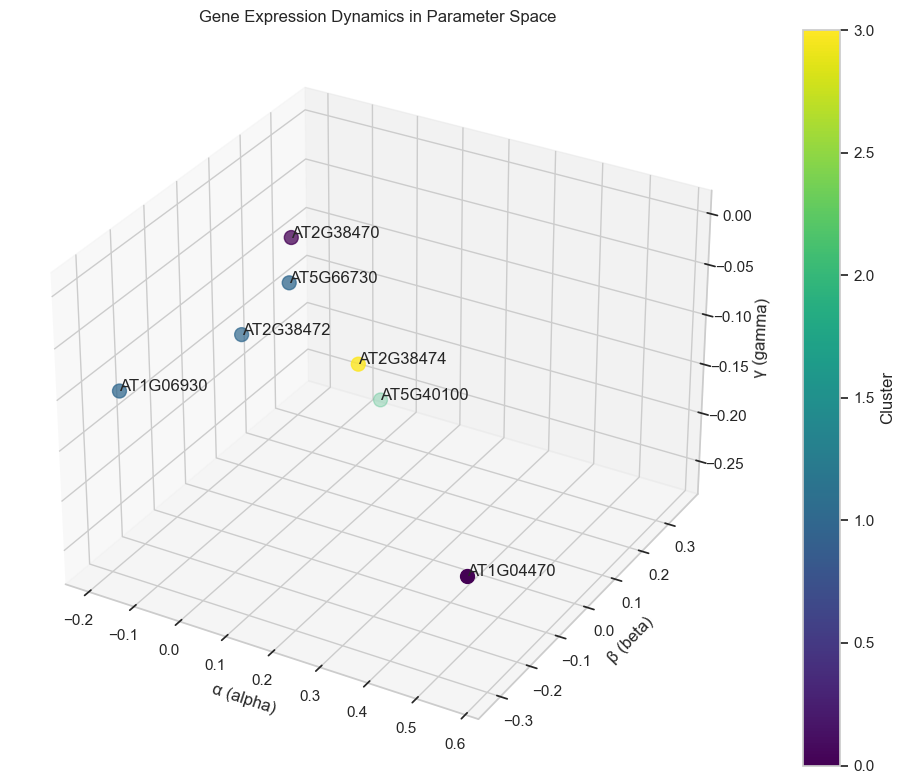


Insights for Research Report:
Neural ODE + Inverse PINN Average Training MSE: 0.126199

Parameter Patterns by Cluster:

Cluster 0 - Representative genes: AT1G04470, AT2G38470
α: μ = 0.2892, σ = 0.2815
β: μ = -0.1694, σ = 0.1529
γ: μ = -0.0823, σ = 0.0854
Interpretation: Moderate negative feedback (gradual decrease)

Cluster 1 - Representative genes: AT1G06930, AT5G66730, AT2G38472
α: μ = -0.0745, σ = 0.0923
β: μ = -0.1350, σ = 0.0926
γ: μ = -0.0743, σ = 0.0338
Interpretation: Moderate negative feedback (gradual decrease)

Cluster 2 - Representative genes: AT5G40100
α: μ = -0.0502, σ = 0.0000
β: μ = 0.3639, σ = 0.0000
γ: μ = -0.2649, σ = 0.0000
Interpretation: Moderate positive feedback (gradual increase)

Cluster 3 - Representative genes: AT2G38474
α: μ = 0.2121, σ = 0.0000
β: μ = -0.1123, σ = 0.0000
γ: μ = -0.0697, σ = 0.0000
Interpretation: Moderate negative feedback (gradual decrease)


In [33]:
# Key insights visualization - parameter distribution by gene type
plt.figure(figsize=(12, 8))

# Get parameters
alphas = [model.alpha.item() for model in ode_models]
betas = [model.beta.item() for model in ode_models]
gammas = [model.gamma.item() for model in ode_models]

# Create a 3D scatter plot
ax = plt.axes(projection='3d')
scatter = ax.scatter(alphas, betas, gammas, c=clusters, s=100, cmap='viridis')

# Add gene labels
for i, gene_id in enumerate(df['Unnamed: 0']):
    ax.text(alphas[i], betas[i], gammas[i], gene_id)

ax.set_xlabel('α (alpha)')
ax.set_ylabel('β (beta)')
ax.set_zlabel('γ (gamma)')
plt.colorbar(scatter, label='Cluster')
plt.title('Gene Expression Dynamics in Parameter Space')
plt.tight_layout()
plt.show()

# Generate summary statistics
print("\nInsights for Research Report:")
print("="*50)

# Make sure time_points_tensor is 1D for odeint
time_points_1d = time_points_tensor.squeeze()

# Overall model performance
avg_train_mse = np.mean([torch.mean((odeint(model, gene_data_tensor[i,0].unsqueeze(0), 
                                           time_points_1d).squeeze() - 
                                     gene_data_tensor[i])**2).item() 
                         for i, model in enumerate(ode_models)])
print(f"Neural ODE + Inverse PINN Average Training MSE: {avg_train_mse:.6f}")

# Parameter patterns analysis
print("\nParameter Patterns by Cluster:")
for cluster_id in sorted(np.unique(clusters)):
    indices = np.where(clusters == cluster_id)[0]
    print(f"\nCluster {cluster_id} - Representative genes: {', '.join([df['Unnamed: 0'][i] for i in indices])}")
    
    # Parameter statistics
    cluster_alphas = [ode_models[i].alpha.item() for i in indices]
    cluster_betas = [ode_models[i].beta.item() for i in indices]
    cluster_gammas = [ode_models[i].gamma.item() for i in indices]
    
    print(f"α: μ = {np.mean(cluster_alphas):.4f}, σ = {np.std(cluster_alphas):.4f}")
    print(f"β: μ = {np.mean(cluster_betas):.4f}, σ = {np.std(cluster_betas):.4f}")
    print(f"γ: μ = {np.mean(cluster_gammas):.4f}, σ = {np.std(cluster_gammas):.4f}")
    
    # Biological interpretation
    if np.mean(cluster_betas) < -0.5:
        print("Interpretation: Strong negative feedback (rapid decrease)")
    elif np.mean(cluster_betas) < 0:
        print("Interpretation: Moderate negative feedback (gradual decrease)")
    elif np.mean(cluster_betas) > 0.5:
        print("Interpretation: Strong positive feedback (exponential growth)")
    elif np.mean(cluster_betas) > 0:
        print("Interpretation: Moderate positive feedback (gradual increase)")
    else:
        print("Interpretation: Minimal feedback (stable)")

In [34]:
# import numpy as np
# import pandas as pd
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torchdiffeq import odeint
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.cluster import KMeans
# from sklearn.preprocessing import StandardScaler

# # Define a function to predict gene expression using cluster-averaged parameters
# def predict_with_cluster_params(time_points, y0, cluster_params):
#     """
#     Predict gene expression trajectory using cluster-averaged parameters.
    
#     Args:
#         time_points: tensor of time points
#         y0: initial value tensor [1]
#         cluster_params: tuple (alpha, beta, gamma) for the cluster
    
#     Returns:
#         Predicted trajectory
#     """
#     alpha, beta, gamma = cluster_params
    
#     class ClusterODE(nn.Module):
#         def forward(self, t, y):
#             return alpha + beta * y + gamma * t
    
#     model = ClusterODE()
#     y_pred = odeint(model, y0, time_points).squeeze()
    
#     return y_pred

# 3.Neural ODE (Parametric)


In [48]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# Load gene expression data
df = pd.read_csv('arabido_example_genes.csv')
print("Original Gene Expression Data:")
print(df)

# Time points (in days)
time_points = np.array([1.0, 2.0, 4.0], dtype=np.float32)  # Day1, Day2, Day4

# Extract gene expression data (each row is one gene)
gene_ids = df.iloc[:, 0]  # First column contains gene IDs
gene_data = df[["Hpa-NO_1d", "Hpa-NO_2d", "Hpa-NO_4d"]].values

# Convert to PyTorch tensors
time_tensor = torch.tensor(time_points, dtype=torch.float32)
gene_data_tensor = torch.tensor(gene_data, dtype=torch.float32)

print(f"Number of genes: {gene_data_tensor.shape[0]}")
print(f"Number of time points: {time_tensor.shape[0]}")

Original Gene Expression Data:
  Unnamed: 0  Hpa-NO_1d  Hpa-NO_2d  Hpa-NO_4d
0  AT5G40100  -0.447960  -0.560155  -5.091964
1  AT1G06930   1.778359   0.000000   0.000000
2  AT1G04470   0.000000   1.175150   0.000000
3  AT5G66730   0.055375   0.098435  -0.101757
4  AT2G38472   0.900000   0.500000   0.000000
5  AT2G38474   0.000000   0.500000   0.000000
6  AT2G38470   0.906000   0.906000   0.906000
Number of genes: 7
Number of time points: 3


##  Neural ODE Model for Gene Expression Dynamics


In [49]:
class GeneParametricODE(nn.Module):
    def __init__(self):
        super(GeneParametricODE, self).__init__()
        # Learnable parameters: α, β, and γ for ODE: dy/dt = α + β * y(t) + γ * t
        self.alpha = nn.Parameter(torch.tensor(0.1, dtype=torch.float32))
        self.beta = nn.Parameter(torch.tensor(0.1, dtype=torch.float32))
        self.gamma = nn.Parameter(torch.tensor(0.1, dtype=torch.float32))

    def forward(self, t, y):
        return self.alpha + self.beta * y + self.gamma * t
    
    def get_parameters(self):
        return {
            'alpha': self.alpha.item(),
            'beta': self.beta.item(),
            'gamma': self.gamma.item()
        }

# Create one ODE model per gene
num_genes = gene_data_tensor.shape[0]
ode_models = nn.ModuleList([GeneParametricODE() for _ in range(num_genes)])

## Training Neural ODEs for Each Gene

In [50]:
def train_neural_ode(gene_idx, epochs=500, lr=0.01):
    """Train Neural ODE for a specific gene"""
    model = ode_models[gene_idx]
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
    
    # Gene expression data for this gene
    y_observed = gene_data_tensor[gene_idx]
    y0 = y_observed[0].unsqueeze(0)  # Initial condition
    
    losses = []
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Solve ODE
        y_pred = odeint(model, y0, time_tensor)
        y_pred = y_pred.squeeze()
        
        # Data loss (MSE)
        loss = torch.mean((y_pred - y_observed)**2)
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        losses.append(loss.item())
        
        if epoch % 100 == 0:
            print(f"Gene {gene_idx}, Epoch {epoch}: Loss = {loss.item():.6f}")
    
    return losses

# Train models for each gene
all_losses = []
for i in range(num_genes):
    print(f"\nTraining model for gene {gene_ids.iloc[i]}")
    gene_losses = train_neural_ode(i)
    all_losses.append(gene_losses)
    
# # Plot training curves
# plt.figure(figsize=(10, 6))
# for i, losses in enumerate(all_losses):
#     plt.plot(losses, label=f"Gene {gene_ids.iloc[i]}")
# plt.xlabel('Epoch')
# plt.ylabel('MSE Loss')
# plt.title('Training Loss for Each Gene')
# plt.legend()
# plt.grid(True)
# plt.show()


Training model for gene AT5G40100
Gene 0, Epoch 0: Loss = 10.810974


Gene 0, Epoch 100: Loss = 0.152062
Gene 0, Epoch 200: Loss = 0.143251
Gene 0, Epoch 300: Loss = 0.137955
Gene 0, Epoch 400: Loss = 0.134842

Training model for gene AT1G06930
Gene 1, Epoch 0: Loss = 5.971052
Gene 1, Epoch 100: Loss = 0.416353
Gene 1, Epoch 200: Loss = 0.363428
Gene 1, Epoch 300: Loss = 0.333202
Gene 1, Epoch 400: Loss = 0.316547

Training model for gene AT1G04470
Gene 2, Epoch 0: Loss = 0.756562
Gene 2, Epoch 100: Loss = 0.348582
Gene 2, Epoch 200: Loss = 0.289153
Gene 2, Epoch 300: Loss = 0.258130
Gene 2, Epoch 400: Loss = 0.241930

Training model for gene AT5G66730
Gene 3, Epoch 0: Loss = 0.646882
Gene 3, Epoch 100: Loss = 0.001916
Gene 3, Epoch 200: Loss = 0.001669
Gene 3, Epoch 300: Loss = 0.001524
Gene 3, Epoch 400: Loss = 0.001442

Training model for gene AT2G38472
Gene 4, Epoch 0: Loss = 2.132010
Gene 4, Epoch 100: Loss = 0.005993
Gene 4, Epoch 200: Loss = 0.005173
Gene 4, Epoch 300: Loss = 0.004710
Gene 4, Epoch 400: Loss = 0.004451

Training model for gene AT2

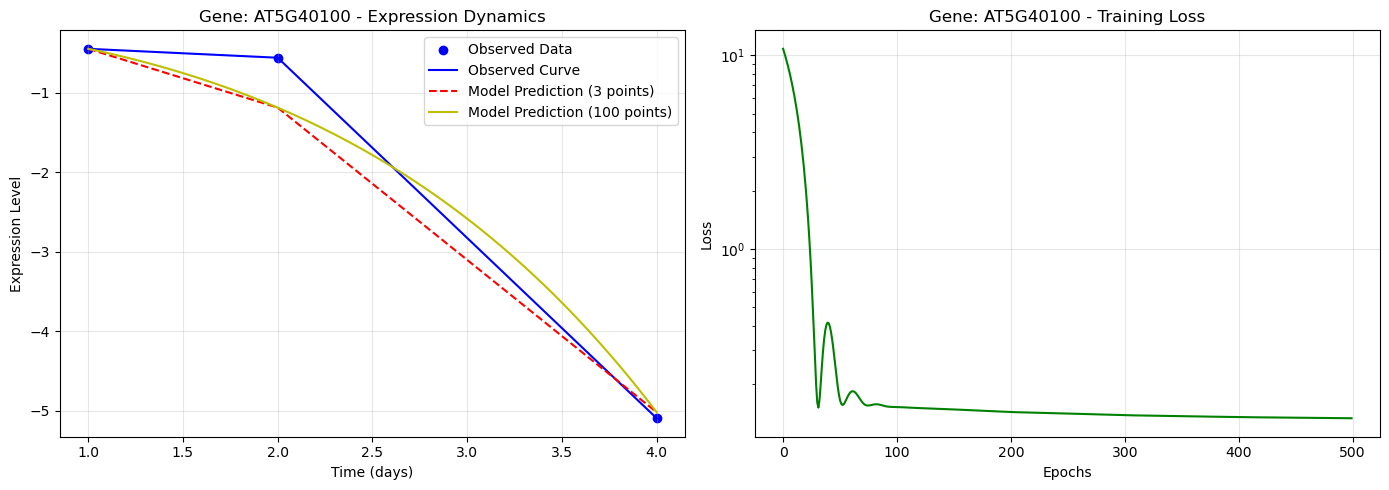

Learned ODE for Gene AT5G40100:
  dy/dt = -0.1150 + 0.4565 * y + -0.1806 * t
Formatted ODE Equation: dy/dt = -0.1150 + 0.4565 * y(t) + -0.1806 * t



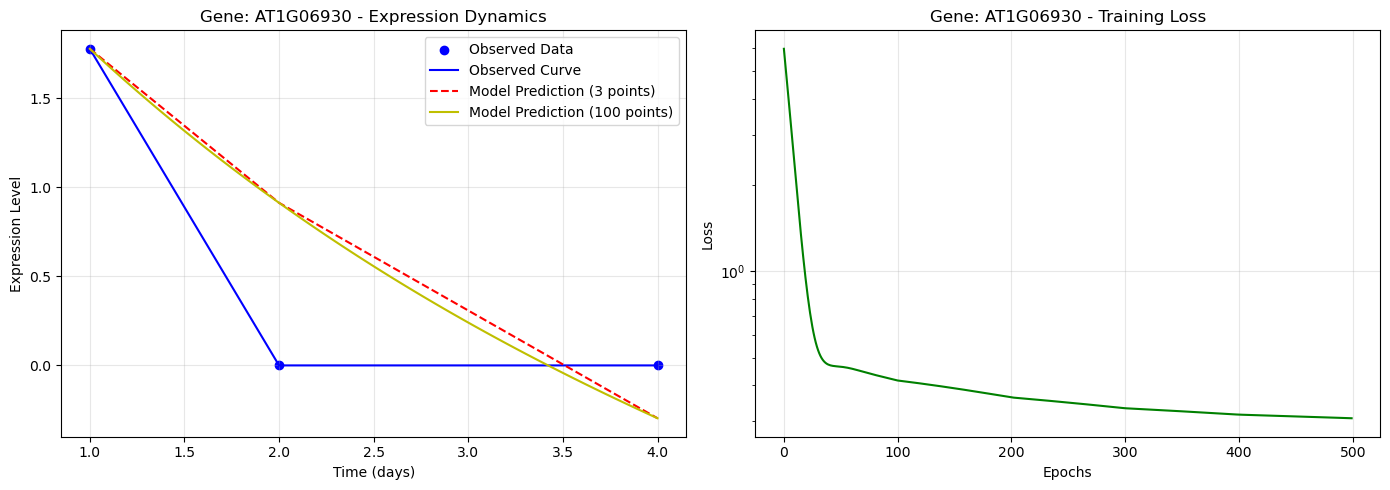

Learned ODE for Gene AT1G06930:
  dy/dt = -0.2870 + -0.3505 * y + -0.0753 * t
Formatted ODE Equation: dy/dt = -0.2870 + -0.3505 * y(t) + -0.0753 * t



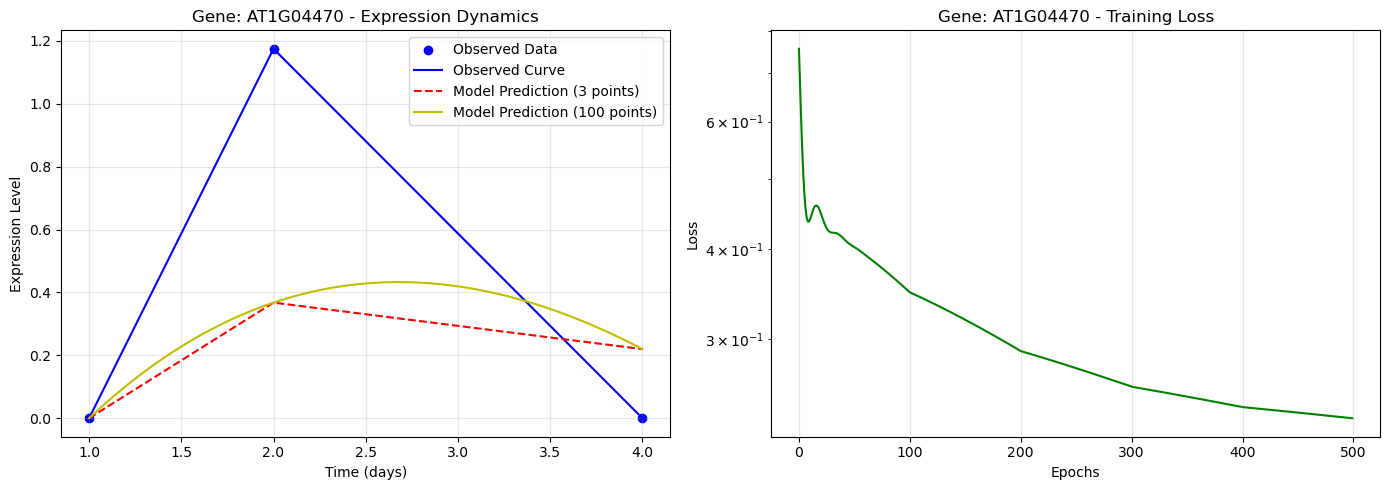

Learned ODE for Gene AT1G04470:
  dy/dt = 0.8208 + -0.2298 * y + -0.2693 * t
Formatted ODE Equation: dy/dt = 0.8208 + -0.2298 * y(t) + -0.2693 * t



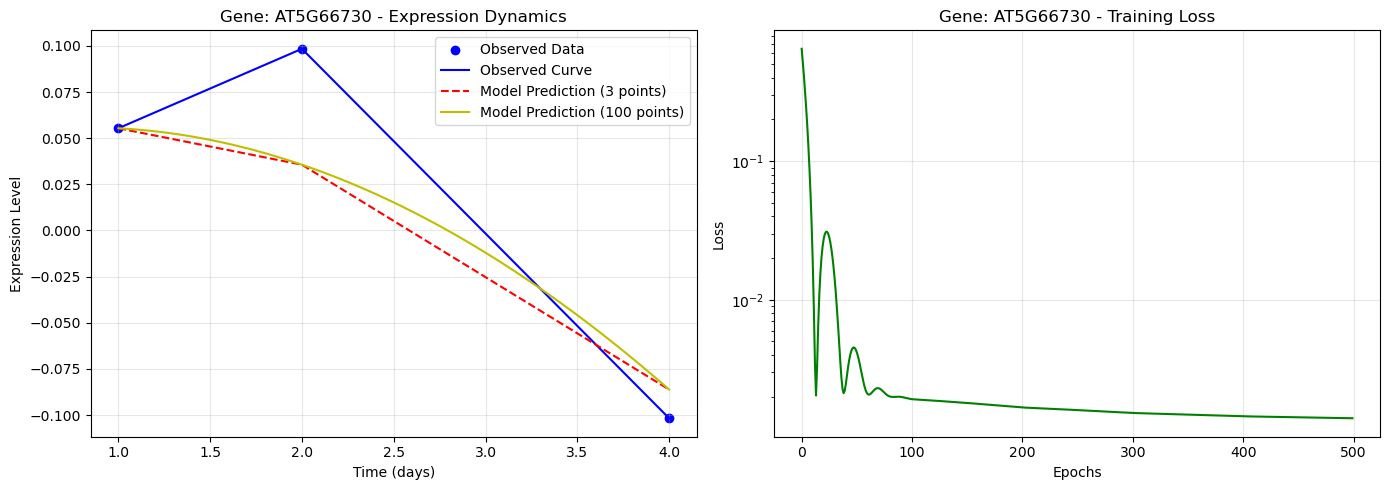

Learned ODE for Gene AT5G66730:
  dy/dt = 0.0272 + -0.0517 * y + -0.0297 * t
Formatted ODE Equation: dy/dt = 0.0272 + -0.0517 * y(t) + -0.0297 * t



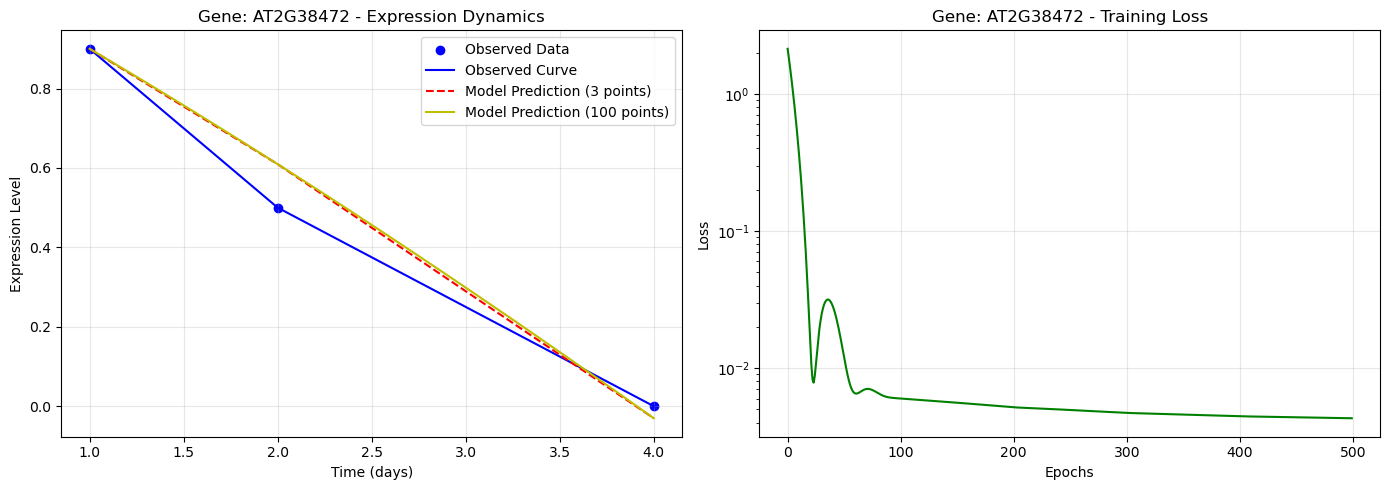

Learned ODE for Gene AT2G38472:
  dy/dt = -0.1076 + -0.1260 * y + -0.0584 * t
Formatted ODE Equation: dy/dt = -0.1076 + -0.1260 * y(t) + -0.0584 * t



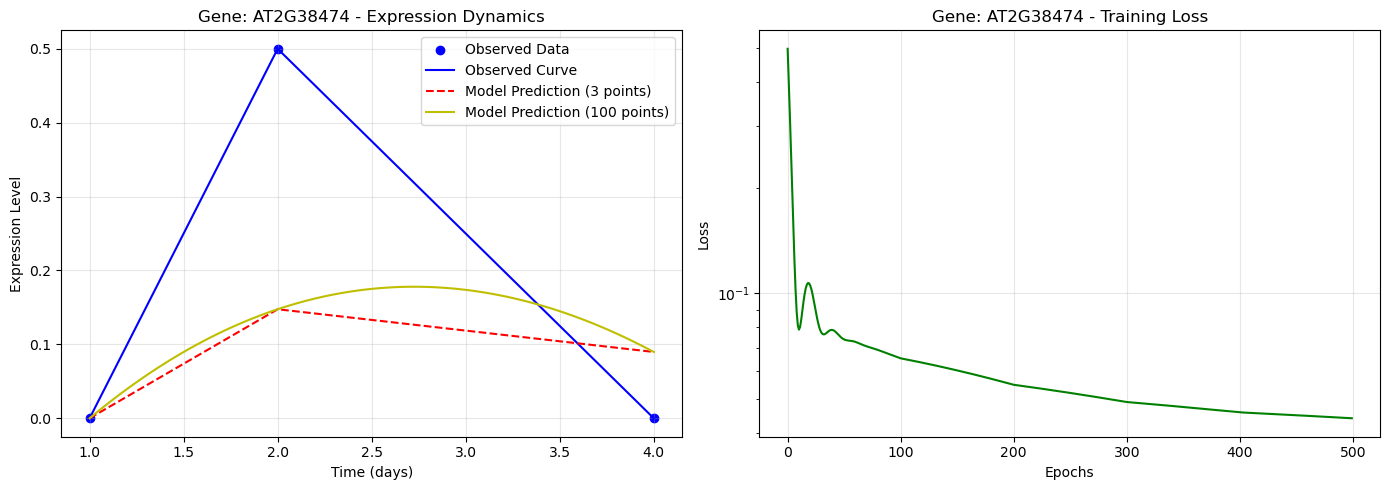

Learned ODE for Gene AT2G38474:
  dy/dt = 0.3252 + -0.0950 * y + -0.1131 * t
Formatted ODE Equation: dy/dt = 0.3252 + -0.0950 * y(t) + -0.1131 * t



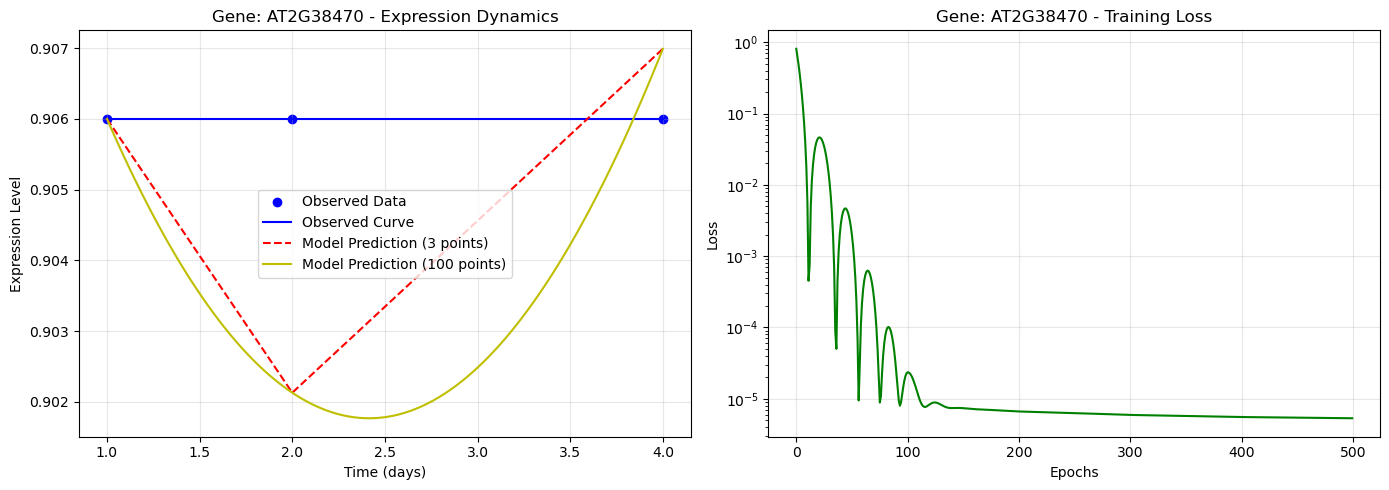

Learned ODE for Gene AT2G38470:
  dy/dt = 0.0060 + -0.0179 * y + 0.0042 * t
Formatted ODE Equation: dy/dt = 0.0060 + -0.0179 * y(t) + 0.0042 * t



In [51]:
# Generate dense time points for smoother curves
fine_t = torch.linspace(1, 4, steps=100)

# Plot predictions and loss functions for each gene
with torch.no_grad():
    for i, gene_id in enumerate(gene_ids):
        # Use the Day1 value as the initial condition for each gene
        y0 = gene_data_tensor[i, 0].unsqueeze(0)  # shape: (1,)
        preds = odeint(ode_models[i], y0, time_tensor).squeeze().numpy()
        y_pred = odeint(ode_models[i], y0, fine_t).squeeze().detach().numpy()
        
        # Create figure with two subplots side by side
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        # Plot 1: Predictions
        ax1.scatter(time_points, gene_data[i], c='b', label="Observed Data")
        ax1.plot(time_points, gene_data[i], 'b-', label="Observed Curve")
        ax1.plot(time_points, preds, 'r--', label="Model Prediction (3 points)")
        ax1.plot(fine_t.numpy(), y_pred, 'y-', label='Model Prediction (100 points)')
        ax1.set_title(f"Gene: {gene_id} - Expression Dynamics")
        ax1.set_xlabel("Time (days)")
        ax1.set_ylabel("Expression Level")
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Loss function
        ax2.plot(range(len(all_losses[i])), all_losses[i], 'g-')
        ax2.set_title(f"Gene: {gene_id} - Training Loss")
        ax2.set_xlabel("Epochs")
        ax2.set_ylabel("Loss")
        ax2.set_yscale('log')  # Log scale for better visualization
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Print learned parameters for the gene
        model = ode_models[i]
        alpha = model.alpha.item()
        beta = model.beta.item()
        gamma = model.gamma.item()
        print(f"Learned ODE for Gene {gene_id}:")
        print(f"  dy/dt = {alpha:.4f} + {beta:.4f} * y + {gamma:.4f} * t")
        print(f"Formatted ODE Equation: dy/dt = {alpha:.4f} + {beta:.4f} * y(t) + {gamma:.4f} * t\n")

## Extracting and Saving ODE Parameters

In [52]:
# # Extract parameters from trained models
# parameters = []

# for i, model in enumerate(ode_models):
#     param_dict = model.get_parameters()
#     param_dict['Gene'] = gene_ids.iloc[i]
#     parameters.append(param_dict)

# # Create DataFrame with parameters
# param_df = pd.DataFrame(parameters)
# param_df = param_df[['Gene', 'alpha', 'beta', 'gamma']]  # Reorder columns
# print("\nExtracted ODE Parameters:")
# print(param_df)


# Extract parameters from trained models
parameters = []

for i, model in enumerate(ode_models):
    params = {
        'Gene': gene_ids.iloc[i],
        'alpha': model.alpha.item(),
        'beta': model.beta.item(),
        'gamma': model.gamma.item()
    }
    parameters.append(params)

# Create DataFrame with parameters
param_df = pd.DataFrame(parameters)
print("\nExtracted ODE Parameters:")
print(param_df)

# Save parameters to CSV
param_df.to_csv('neural_ode_parameters.csv', index=False)


Extracted ODE Parameters:
        Gene     alpha      beta     gamma
0  AT5G40100 -0.114982  0.456523 -0.180553
1  AT1G06930 -0.287002 -0.350527 -0.075282
2  AT1G04470  0.820759 -0.229800 -0.269294
3  AT5G66730  0.027203 -0.051694 -0.029655
4  AT2G38472 -0.107584 -0.125984 -0.058369
5  AT2G38474  0.325214 -0.095020 -0.113117
6  AT2G38470  0.006043 -0.017935  0.004196


## Clustering Genes Based on ODE Parameters

c:\Users\praba\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\praba\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\praba\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\praba\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

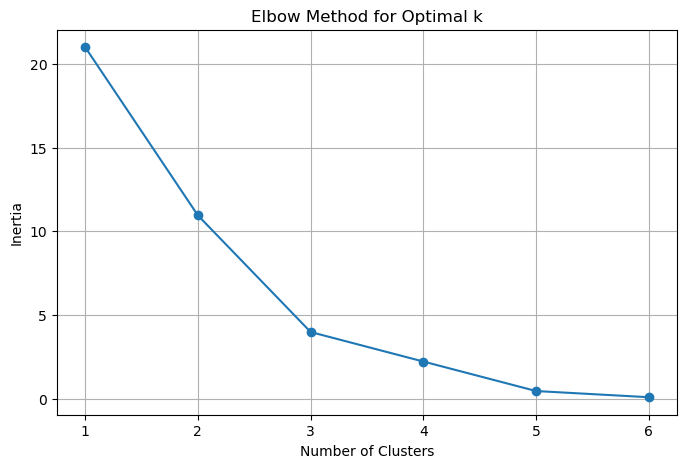


Cluster Assignments:
[2 1 0 1 1 3 1]

Parameters with Cluster Assignments:
        Gene     alpha      beta     gamma  cluster
0  AT5G40100 -0.114982  0.456523 -0.180553        2
1  AT1G06930 -0.287002 -0.350527 -0.075282        1
2  AT1G04470  0.820759 -0.229800 -0.269294        0
3  AT5G66730  0.027203 -0.051694 -0.029655        1
4  AT2G38472 -0.107584 -0.125984 -0.058369        1
5  AT2G38474  0.325214 -0.095020 -0.113117        3
6  AT2G38470  0.006043 -0.017935  0.004196        1


c:\Users\praba\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [53]:
# Prepare data for clustering
X = param_df[['alpha', 'beta', 'gamma']].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determine optimal number of clusters using elbow method
inertia = []
k_range = range(1, min(7, num_genes))
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, 'o-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

# Apply K-means clustering
n_clusters = 4  # Based on elbow method or biological knowledge
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
print("\nCluster Assignments:")
print(clusters)
# Add cluster information to parameters dataframe
param_df['cluster'] = clusters
print("\nParameters with Cluster Assignments:")
print(param_df)

# Save clustered parameters
param_df.to_csv('neural_ode_clustered_parameters.csv', index=False)

c:\Users\praba\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Synthetic Data:
          Unnamed: 0  Hpa-NO_1d  Hpa-NO_2d  Hpa-NO_4d  cluster
0   SYNTHETIC_0_1059   0.132368   1.503952   0.255681        0
1   SYNTHETIC_0_5670  -0.138951   1.330882  -0.072788        0
2   SYNTHETIC_0_7989   0.028292   1.456172   0.087188        0
3   SYNTHETIC_0_3964   0.567803   0.947664  -0.179138        0
4   SYNTHETIC_1_5496   0.128114   0.105457  -0.070392        1
5   SYNTHETIC_1_7985   0.036892   0.325844  -0.211569        1
6   SYNTHETIC_1_8721   0.205550   0.434418  -0.213456        1
7   SYNTHETIC_1_9828   0.380185   0.040318   0.080556        1
8   SYNTHETIC_2_8610  -0.791447  -0.688725  -5.313879        2
9   SYNTHETIC_2_8568  -0.427815  -0.374819  -4.979178        2
10  SYNTHETIC_2_5217  -0.757582  -0.958537  -4.848002        2
11  SYNTHETIC_2_2904  -0.408406  -0.725083  -4.970346        2
12  SYNTHETIC_3_2433   1.130559   0.908659   0.212303        3
13  SYNTHETIC_3_3327   1.286132   0.372341  -0.107768        3
14  SYNTHETIC_3_9064   1.190826   0.438

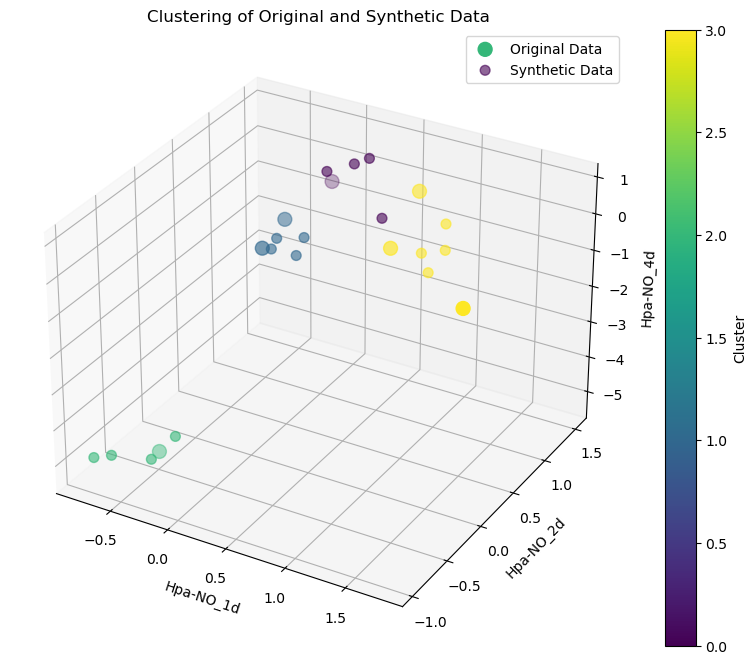

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Original data (example structure)
original_data = pd.DataFrame({
    "Unnamed: 0": ["AT5G40100", "AT1G06930", "AT1G04470", "AT5G66730", "AT2G38472", "AT2G38474", "AT2G38470"],
    "Hpa-NO_1d": [-0.447960, 1.778359, 0.000000, 0.055375, 0.900000, 0.000000, 0.906000],
    "Hpa-NO_2d": [-0.560155, 0.000000, 1.175150, 0.098435, 0.500000, 0.500000, 0.906000],
    "Hpa-NO_4d": [-5.091964, 0.000000, 0.000000, -0.101757, 0.000000, 0.000000, 0.906000]
})

# Extract numerical data for clustering
X = original_data[["Hpa-NO_1d", "Hpa-NO_2d", "Hpa-NO_4d"]].values

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform clustering (e.g., k=4 clusters)
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to the original data
original_data["cluster"] = clusters

# Generate synthetic data based on cluster centroids
centroids = kmeans.cluster_centers_
centroids_original = scaler.inverse_transform(centroids)  # Transform centroids back to original scale

# Number of synthetic samples per cluster
num_synthetic_samples_per_cluster = 4

# Generate synthetic data
synthetic_data = []
for cluster_idx, centroid in enumerate(centroids_original):
    # Add random noise around the centroid to generate synthetic points
    noise = np.random.normal(scale=0.2, size=(num_synthetic_samples_per_cluster, 3))  # Adjust scale for noise level
    cluster_synthetic_points = centroid + noise
    for point in cluster_synthetic_points:
        synthetic_data.append({
            "Unnamed: 0": f"SYNTHETIC_{cluster_idx}_{np.random.randint(1000, 9999)}",
            "Hpa-NO_1d": point[0],
            "Hpa-NO_2d": point[1],
            "Hpa-NO_4d": point[2],
            "cluster": cluster_idx
        })

# Convert synthetic data to DataFrame
synthetic_df = pd.DataFrame(synthetic_data)

# Combine original and synthetic data for comparison
combined_data = pd.concat([original_data, synthetic_df], ignore_index=True)

# Print synthetic data
print("Synthetic Data:")
print(synthetic_df)

# Print combined data
print("\nCombined Data:")
print(combined_data)

# Visualize the clusters in 3D parameter space
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot original data
scatter_original = ax.scatter(
    original_data["Hpa-NO_1d"], original_data["Hpa-NO_2d"], original_data["Hpa-NO_4d"],
    c=original_data["cluster"], cmap='viridis', s=100, label="Original Data"
)

# Plot synthetic data
scatter_synthetic = ax.scatter(
    synthetic_df["Hpa-NO_1d"], synthetic_df["Hpa-NO_2d"], synthetic_df["Hpa-NO_4d"],
    c=synthetic_df["cluster"], cmap='viridis', s=50, alpha=0.6, label="Synthetic Data"
)

ax.set_xlabel("Hpa-NO_1d")
ax.set_ylabel("Hpa-NO_2d")
ax.set_zlabel("Hpa-NO_4d")
ax.set_title("Clustering of Original and Synthetic Data")
plt.colorbar(scatter_original, ax=ax, label="Cluster")
plt.legend()
plt.show()

Synthetic Point 0:
  Actual Derivative: [-0.396208 -1.005107 -2.222905]
  Predicted Derivative: [-0.45163071 -0.81306178 -3.2037823 ]
  Satisfies Model: False



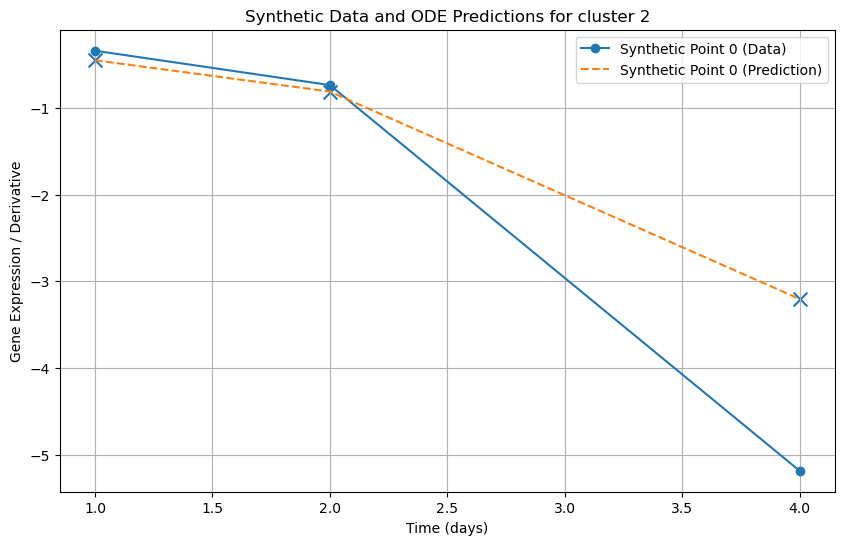

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Given parameters for cluster 2


alpha = -0.114982
beta = 0.456523
gamma = -0.180553

# Synthetic data points in cluster 2
# synthetic_cluster_2 = pd.DataFrame({
#     "Hpa-NO_1d": [-0.451840, -0.341923, -0.453931, -0.571841],
#     "Hpa-NO_2d": [-0.796160, -0.738131, -0.386800, -0.574107]
#     "Hpa-NO_4d": [-5.113225, -5.183941, -5.105513, -5.057426]
# })
synthetic_cluster_2 = pd.DataFrame({
    "Hpa-NO_1d": [ -0.341923, ],
    "Hpa-NO_2d": [-0.738131, ],
    "Hpa-NO_4d": [-5.183941,   ]
})




# Time points corresponding to the columns
time_points = np.array([1.0, 2.0, 4.0])  # Day 1, Day 2, Day 4

# Function to compute the ODE prediction
def compute_ode_prediction(y, t, alpha, beta, gamma):
    return alpha + beta * y + gamma * t

# Check if the synthetic data satisfies the ODE model
results = []
for index, row in synthetic_cluster_2.iterrows():
    y_values = row.values  # Extract y(t) values
    dy_dt_actual = np.gradient(y_values, time_points)  # Compute actual derivative using finite differences
    dy_dt_predicted = compute_ode_prediction(y_values, time_points, alpha, beta, gamma)  # Predicted derivative
    satisfies_model = np.allclose(dy_dt_actual, dy_dt_predicted, atol=0.1)  # Check if actual ≈ predicted
    results.append({
        "Synthetic Point": index,
        "Actual Derivative": dy_dt_actual,
        "Predicted Derivative": dy_dt_predicted,
        "Satisfies Model": satisfies_model
    })

# Display results
for result in results:
    print(f"Synthetic Point {result['Synthetic Point']}:")
    print(f"  Actual Derivative: {result['Actual Derivative']}")
    print(f"  Predicted Derivative: {result['Predicted Derivative']}")
    print(f"  Satisfies Model: {result['Satisfies Model']}")
    print()

# Plot the synthetic data and predictions
plt.figure(figsize=(10, 6))
for index, row in synthetic_cluster_2.iterrows():
    y_values = row.values  # Extract y(t) values
    dy_dt_predicted = compute_ode_prediction(y_values, time_points, alpha, beta, gamma)  # Predicted derivative

    # Plot synthetic data
    plt.plot(time_points, y_values, 'o-', label=f"Synthetic Point {index} (Data)")

    # Plot predicted values
    plt.plot(time_points, dy_dt_predicted, '--', label=f"Synthetic Point {index} (Prediction)")
    
    plt.scatter(time_points, dy_dt_predicted, marker='x', s=100)
plt.xlabel("Time (days)")
plt.ylabel("Gene Expression / Derivative")
plt.title("Synthetic Data and ODE Predictions for cluster 2")
plt.legend()
plt.grid(True)
plt.show()

##  Visualizing Clusters in 3D Parameter Space

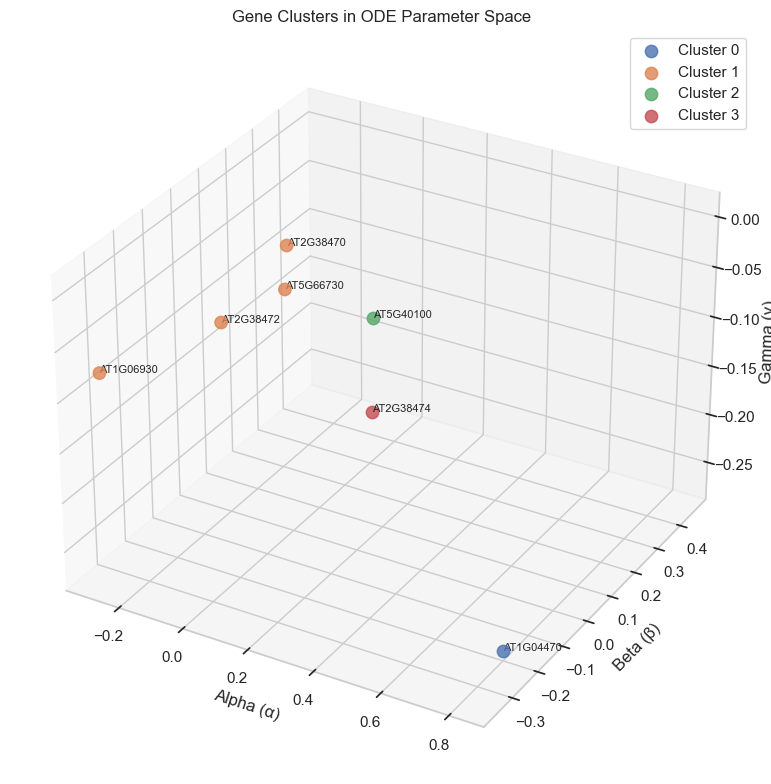

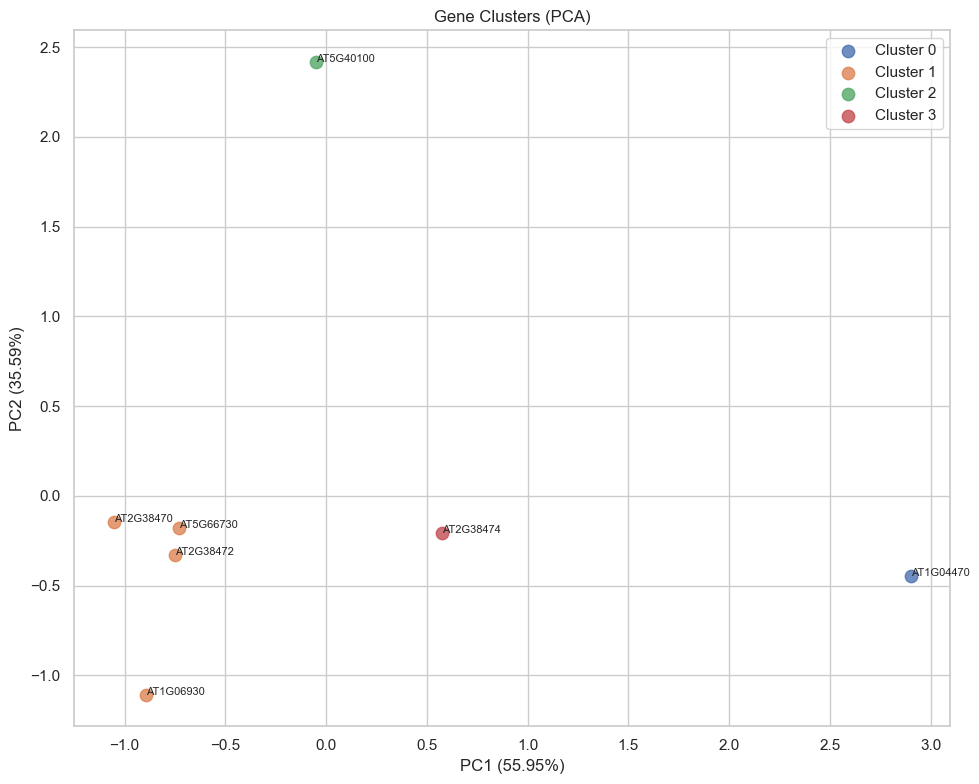

In [41]:
# 3D visualization of parameter clusters
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot each cluster
for cluster_id in range(n_clusters):
    cluster_data = param_df[param_df['cluster'] == cluster_id]
    ax.scatter(
        cluster_data['alpha'], 
        cluster_data['beta'], 
        cluster_data['gamma'],
        label=f'Cluster {cluster_id}',
        s=80,
        alpha=0.8
    )
    
    # Add gene labels
    for i, row in cluster_data.iterrows():
        ax.text(row['alpha'], row['beta'], row['gamma'], row['Gene'], size=8)

ax.set_xlabel('Alpha (α)')
ax.set_ylabel('Beta (β)')
ax.set_zlabel('Gamma (γ)')
ax.set_title('Gene Clusters in ODE Parameter Space')
ax.legend()
plt.tight_layout()
plt.show()

# Additionally, visualize using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 8))
for cluster_id in range(n_clusters):
    cluster_mask = clusters == cluster_id
    plt.scatter(
        X_pca[cluster_mask, 0],
        X_pca[cluster_mask, 1],
        label=f'Cluster {cluster_id}',
        s=80,
        alpha=0.8
    )

    # Add gene labels
    for i, (x, y) in enumerate(X_pca[cluster_mask]):
        gene_idx = np.where(cluster_mask)[0][i]
        plt.annotate(param_df['Gene'].iloc[gene_idx], (x, y), fontsize=8)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
plt.title('Gene Clusters (PCA)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Analyzing Cluster Characteristics


Cluster Statistics:
            alpha                beta              gamma          
             mean       std      mean      std      mean       std
cluster                                                           
0        0.820759       NaN -0.229800      NaN -0.269294       NaN
1       -0.090335  0.143851 -0.136535  0.14963 -0.039778  0.034844
2       -0.114982       NaN  0.456523      NaN -0.180553       NaN
3        0.325214       NaN -0.095020      NaN -0.113117       NaN


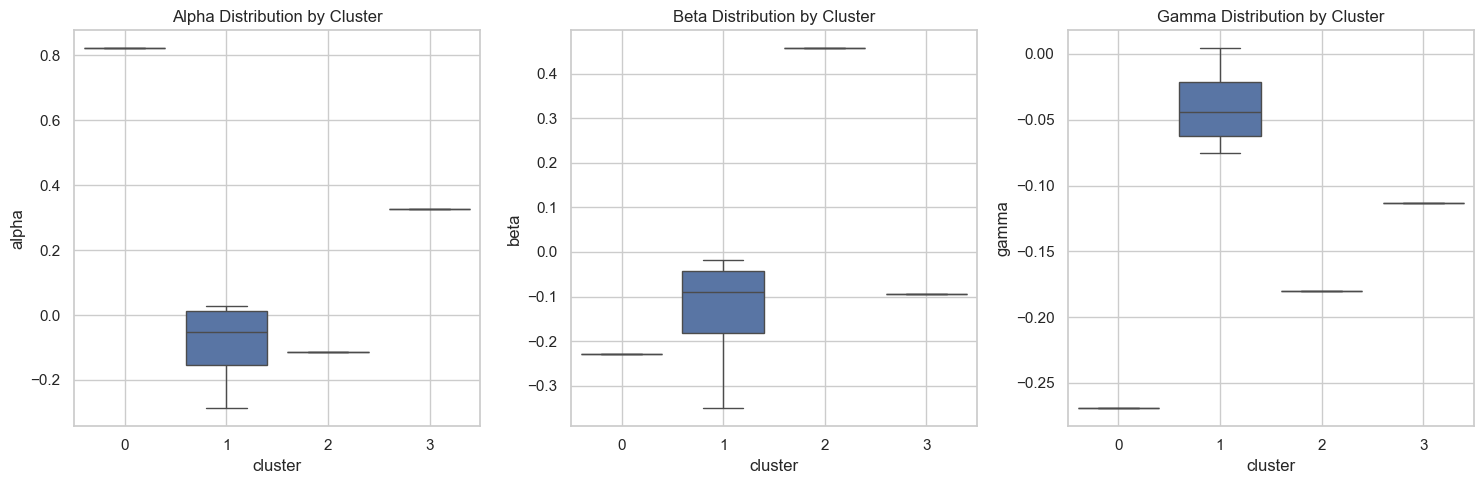

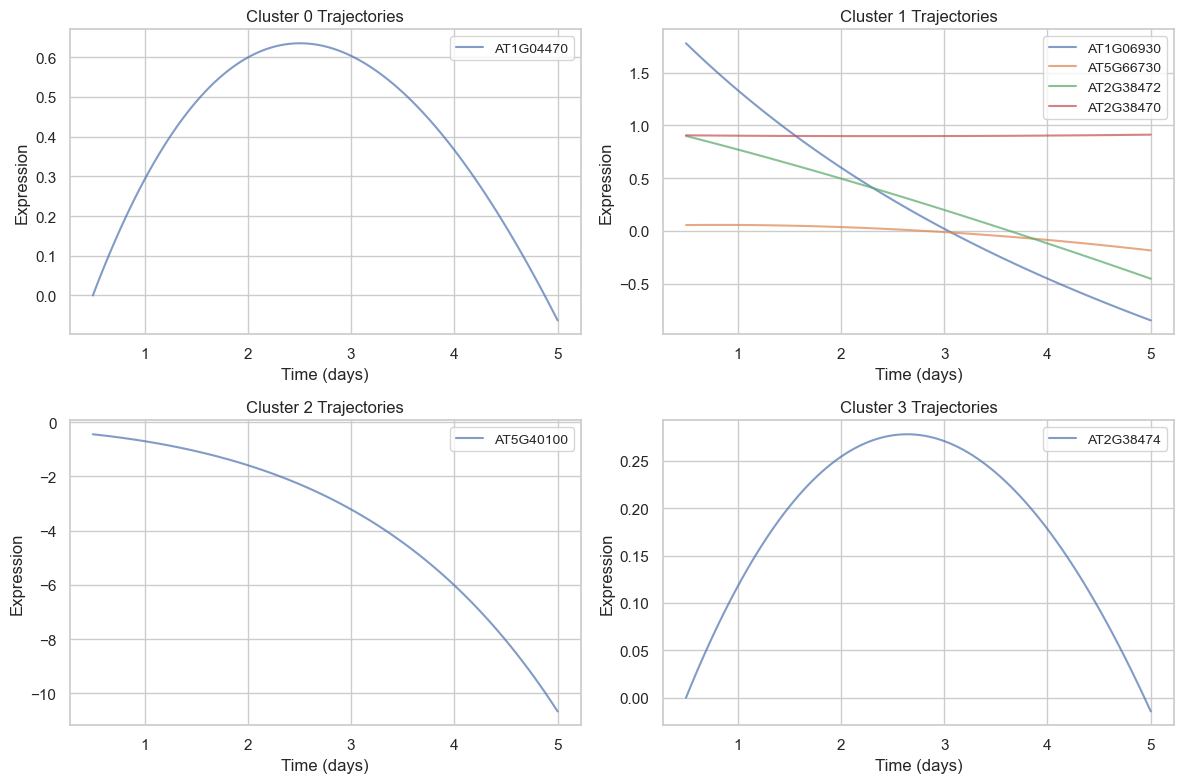

In [42]:
# Analyze and compare clusters
cluster_stats = param_df.groupby('cluster')[['alpha', 'beta', 'gamma']].agg(['mean', 'std'])
print("\nCluster Statistics:")
print(cluster_stats)

# Visualize parameter distributions by cluster
plt.figure(figsize=(15, 5))

# Alpha parameter
plt.subplot(1, 3, 1)
sns.boxplot(x='cluster', y='alpha', data=param_df)
plt.title('Alpha Distribution by Cluster')
plt.grid(True)

# Beta parameter
plt.subplot(1, 3, 2)
sns.boxplot(x='cluster', y='beta', data=param_df)
plt.title('Beta Distribution by Cluster')
plt.grid(True)

# Gamma parameter
plt.subplot(1, 3, 3)
sns.boxplot(x='cluster', y='gamma', data=param_df)
plt.title('Gamma Distribution by Cluster')
plt.grid(True)

plt.tight_layout()
plt.show()

# Generate representative trajectories for each cluster
plt.figure(figsize=(12, 8))
dense_time = torch.linspace(0.5, 5.0, 100)

for cluster_id in range(n_clusters):
    plt.subplot(2, 2, cluster_id+1)
    
    # Get genes in this cluster
    cluster_genes = param_df[param_df['cluster'] == cluster_id]
    
    for gene_idx in cluster_genes.index:
        # Get model and initial condition
        model = ode_models[gene_idx]
        y0 = gene_data_tensor[gene_idx, 0].unsqueeze(0)
        
        # Generate trajectory
        trajectory = odeint(model, y0, dense_time).squeeze().detach()
        
        # Plot trajectory
        plt.plot(dense_time.numpy(), trajectory.numpy(), alpha=0.7, 
                 label=f"{param_df['Gene'].iloc[gene_idx]}")
    
    plt.title(f'Cluster {cluster_id} Trajectories')
    plt.xlabel('Time (days)')
    plt.ylabel('Expression')
    plt.grid(True)
    plt.legend(fontsize='small')

plt.tight_layout()
plt.show()

# 4. neural ode simple

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import matplotlib.pyplot as plt

gene_ids = df['Unnamed: 0']

# Time points (in days) and converting to tensor
time_points = np.array([1.0, 2.0, 4.0], dtype=np.float32)  # Day1, Day2, Day4
time_tensor = torch.tensor(time_points, dtype=torch.float32)

gene_data = df[["Hpa-NO_1d", "Hpa-NO_2d", "Hpa-NO_4d"]].values
gene_data_tensor = torch.tensor(gene_data, dtype=torch.float32)

##############################################################################
# Neural ODE Model: Representing dy/dt = f(y, t) with a neural network
##############################################################################

class NeuralODEFunc(nn.Module):
    def __init__(self, hidden_dim=32):
        super(NeuralODEFunc, self).__init__()
        # A simple feed-forward network that takes [y, t] as input
        self.net = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, t, y):
        # Ensure y is of shape (batch_size, 1)
        if len(y.shape) == 1:
            y = y.unsqueeze(1)
        # Create a feature for time t with the same shape as y
        t_feature = t * torch.ones_like(y)
        # Concatenate y and t along the last dimension
        input_tensor = torch.cat([y, t_feature], dim=1)
        return self.net(input_tensor)

    def get_parameters(self):
        # Optionally, you can extract parameters (weights) if needed.
        # Here, we simply return a string summary.
        return {name: param.detach().cpu().numpy() for name, param in self.named_parameters()}

# Create one Neural ODE model per gene
num_genes = gene_data_tensor.shape[0]
neural_ode_models = nn.ModuleList([NeuralODEFunc() for _ in range(num_genes)])


In [7]:

##############################################################################
# Training Function for Neural ODE for a Specific Gene
##############################################################################

def train_neural_ode(gene_idx, epochs=150, lr=0.01):
    """Train Neural ODE for a specific gene"""
    model = neural_ode_models[gene_idx]
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
    
    # Gene expression data for this gene and initial condition
    y_observed = gene_data_tensor[gene_idx]
    y0 = y_observed[0].unsqueeze(0)  # shape: (1,)
    
    losses = []
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Solve the Neural ODE: compute predictions over time_tensor
        y_pred = odeint(model, y0, time_tensor)
        y_pred = y_pred.squeeze()  # shape: (num_time_points,)
        
        # Data loss: Mean squared error between predictions and observed data
        loss = torch.mean((y_pred - y_observed)**2)
        
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        losses.append(loss.item())
        
        if epoch % 10 == 0:
            print(f"Gene {gene_idx}, Epoch {epoch}: Loss = {loss.item():.6f}")
    
    return losses



Training Neural ODE model for gene AT5G40100
Gene 0, Epoch 0: Loss = 4.400183
Gene 0, Epoch 10: Loss = 0.753280
Gene 0, Epoch 20: Loss = 0.583933
Gene 0, Epoch 30: Loss = 0.450104
Gene 0, Epoch 40: Loss = 0.220576
Gene 0, Epoch 50: Loss = 0.065702
Gene 0, Epoch 60: Loss = 0.006451
Gene 0, Epoch 70: Loss = 0.001887
Gene 0, Epoch 80: Loss = 0.020471
Gene 0, Epoch 90: Loss = 0.004661
Gene 0, Epoch 100: Loss = 0.000888
Gene 0, Epoch 110: Loss = 0.000462
Gene 0, Epoch 120: Loss = 0.000126
Gene 0, Epoch 130: Loss = 0.000025
Gene 0, Epoch 140: Loss = 0.000015

Training Neural ODE model for gene AT1G06930
Gene 1, Epoch 0: Loss = 3.608403
Gene 1, Epoch 10: Loss = 0.116969
Gene 1, Epoch 20: Loss = 0.044364
Gene 1, Epoch 30: Loss = 0.018939
Gene 1, Epoch 40: Loss = 0.001923
Gene 1, Epoch 50: Loss = 0.000333
Gene 1, Epoch 60: Loss = 0.000669
Gene 1, Epoch 70: Loss = 0.000198
Gene 1, Epoch 80: Loss = 0.000042
Gene 1, Epoch 90: Loss = 0.000032
Gene 1, Epoch 100: Loss = 0.000020
Gene 1, Epoch 110: L

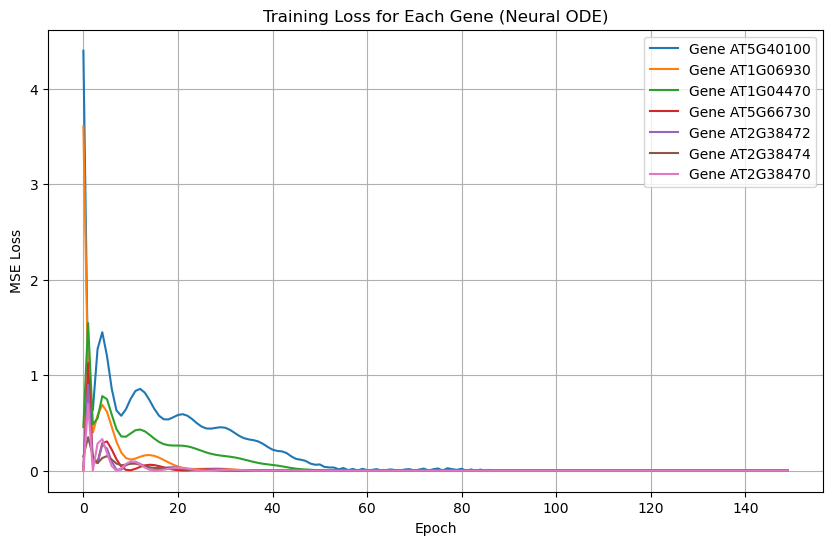

In [8]:

##############################################################################
# Train Neural ODE Models for Each Gene
##############################################################################

all_losses = []
for i in range(num_genes):
    print(f"\nTraining Neural ODE model for gene {gene_ids.iloc[i]}")
    gene_losses = train_neural_ode(i)
    all_losses.append(gene_losses)

##############################################################################
# Plot Training Curves for Each Gene
##############################################################################

plt.figure(figsize=(10, 6))
for i, losses in enumerate(all_losses):
    plt.plot(losses, label=f"Gene {gene_ids.iloc[i]}")
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss for Each Gene (Neural ODE)')
plt.legend()
plt.grid(True)
plt.show()


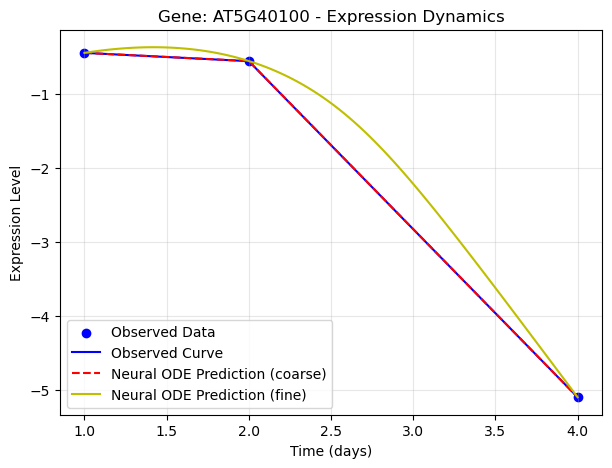

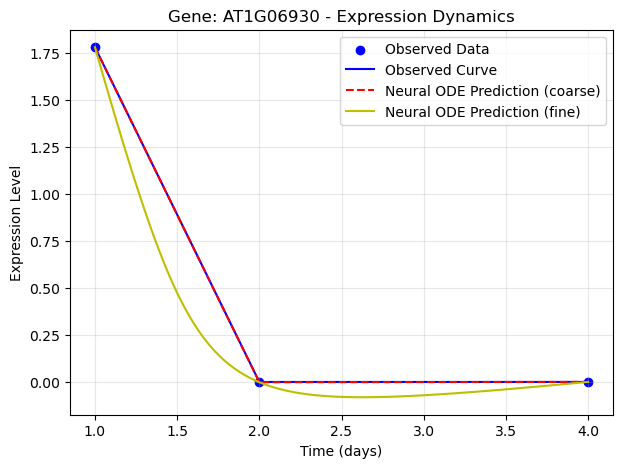

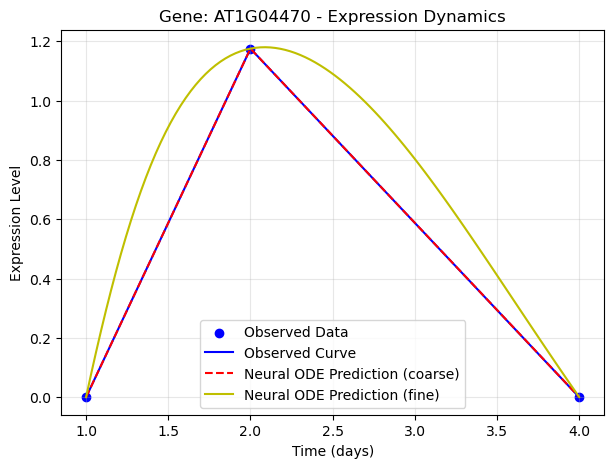

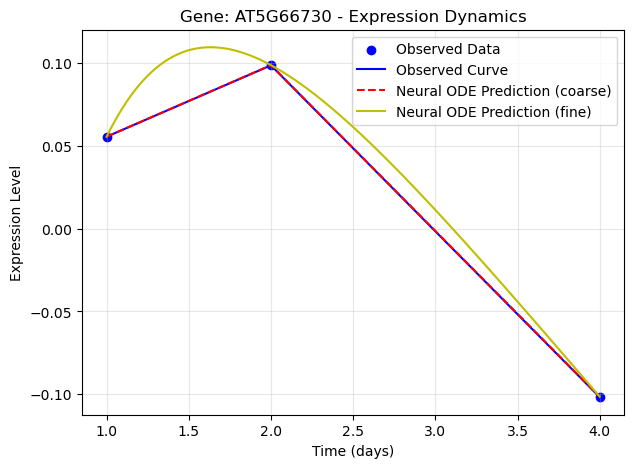

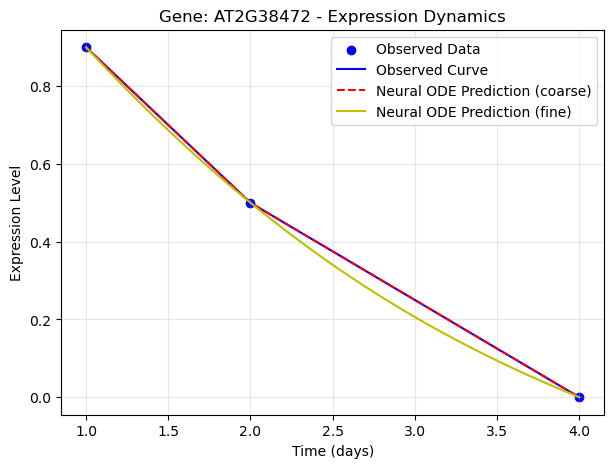

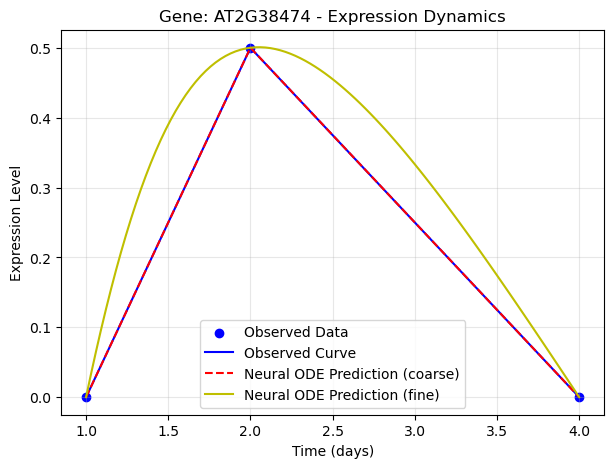

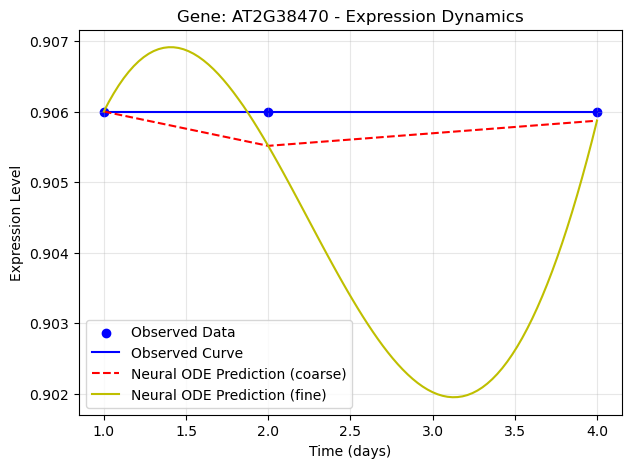

In [9]:

##############################################################################
# Evaluate and Visualize the Predictions
##############################################################################

fine_t = torch.linspace(1, 4, steps=100)
with torch.no_grad():
    for i, gene_id in enumerate(gene_ids):
        model = neural_ode_models[i]
        y0 = gene_data_tensor[i, 0].unsqueeze(0)
        
        # Predictions on original and fine time points
        preds_coarse = odeint(model, y0, time_tensor).squeeze().numpy()
        preds_fine = odeint(model, y0, fine_t).squeeze().numpy()
        
        # Plot the predictions and observed data
        plt.figure(figsize=(7, 5))
        plt.scatter(time_points, gene_data_tensor[i].numpy(), c='b', label="Observed Data")
        plt.plot(time_points, gene_data_tensor[i].numpy(), 'b-', label="Observed Curve")
        plt.plot(time_points, preds_coarse, 'r--', label="Neural ODE Prediction (coarse)")
        plt.plot(fine_t.numpy(), preds_fine, 'y-', label="Neural ODE Prediction (fine)")
        plt.title(f"Gene: {gene_id} - Expression Dynamics")
        plt.xlabel("Time (days)")
        plt.ylabel("Expression Level")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()


# neural ode parametric 2

In [10]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import matplotlib.pyplot as plt

# Load data
# df = pd.read_csv("your_data.csv")  # Uncomment and load your dataset

gene_ids = df['Unnamed: 0']
time_points = np.array([1.0, 2.0, 4.0], dtype=np.float32)
time_tensor = torch.tensor(time_points, dtype=torch.float32)

gene_data = df[["Hpa-NO_1d", "Hpa-NO_2d", "Hpa-NO_4d"]].values
gene_data_tensor = torch.tensor(gene_data, dtype=torch.float32)

##############################################################################
# Parameterized Neural ODE Model
##############################################################################

class ParametricNeuralODE(nn.Module):
    def __init__(self, hidden_dim=32):
        super(ParametricNeuralODE, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden_dim),  # Input: y(t)
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 3)  # Output: alpha, beta, gamma
        )
    
    def forward(self, t, y):
        if len(y.shape) == 1:
            y = y.unsqueeze(1)
        params = self.net(y)  # Predict (α, β, γ)
        alpha, beta, gamma = params[:, 0], params[:, 1], params[:, 2]
        return alpha + beta * y + gamma * t

# Create one model per gene
num_genes = gene_data_tensor.shape[0]
neural_ode_models = nn.ModuleList([ParametricNeuralODE() for _ in range(num_genes)])


In [11]:

##############################################################################
# Training Function
##############################################################################

def train_model(gene_idx, epochs=150, lr=0.01):
    model = neural_ode_models[gene_idx]
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
    
    y_observed = gene_data_tensor[gene_idx]
    y0 = y_observed[0].unsqueeze(0)
    losses = []
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        y_pred = odeint(model, y0, time_tensor).squeeze()
        loss = torch.mean((y_pred - y_observed)**2)
        loss.backward()
        optimizer.step()
        scheduler.step()
        losses.append(loss.item())
        
        if epoch % 100 == 0:
            print(f"Gene {gene_idx}, Epoch {epoch}: Loss = {loss.item():.6f}")
    
    return losses

##############################################################################
# Train for Each Gene
##############################################################################

all_losses = []
for i in range(num_genes):
    print(f"\nTraining Parameterized Neural ODE model for gene {gene_ids.iloc[i]}")
    gene_losses = train_model(i)
    all_losses.append(gene_losses)



Training Parameterized Neural ODE model for gene AT5G40100
Gene 0, Epoch 0: Loss = 2.327854
Gene 0, Epoch 100: Loss = 0.000171

Training Parameterized Neural ODE model for gene AT1G06930
Gene 1, Epoch 0: Loss = 1.209808
Gene 1, Epoch 100: Loss = 0.000163

Training Parameterized Neural ODE model for gene AT1G04470
Gene 2, Epoch 0: Loss = 0.540006
Gene 2, Epoch 100: Loss = 0.000263

Training Parameterized Neural ODE model for gene AT5G66730
Gene 3, Epoch 0: Loss = 0.081259
Gene 3, Epoch 100: Loss = 0.001714

Training Parameterized Neural ODE model for gene AT2G38472
Gene 4, Epoch 0: Loss = 13.005870
Gene 4, Epoch 100: Loss = 0.004659

Training Parameterized Neural ODE model for gene AT2G38474
Gene 5, Epoch 0: Loss = 0.080522
Gene 5, Epoch 100: Loss = 0.000019

Training Parameterized Neural ODE model for gene AT2G38470
Gene 6, Epoch 0: Loss = 0.407141
Gene 6, Epoch 100: Loss = 0.000102


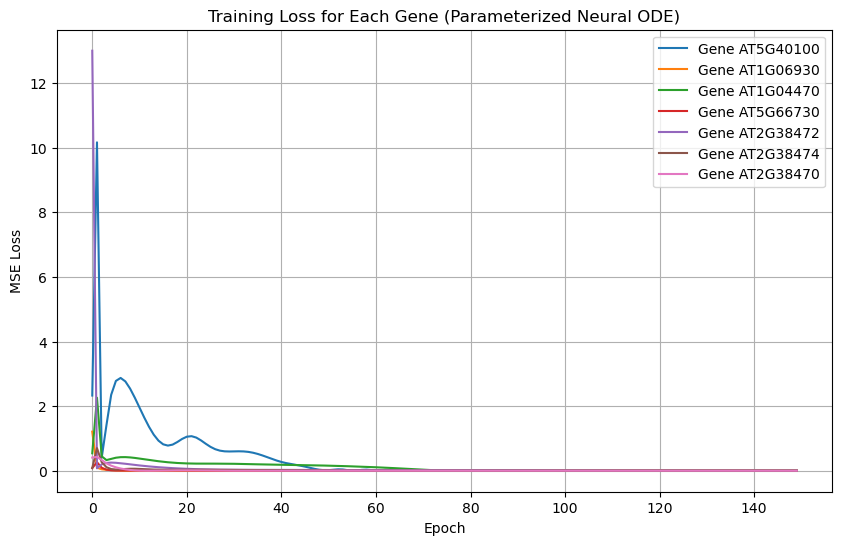

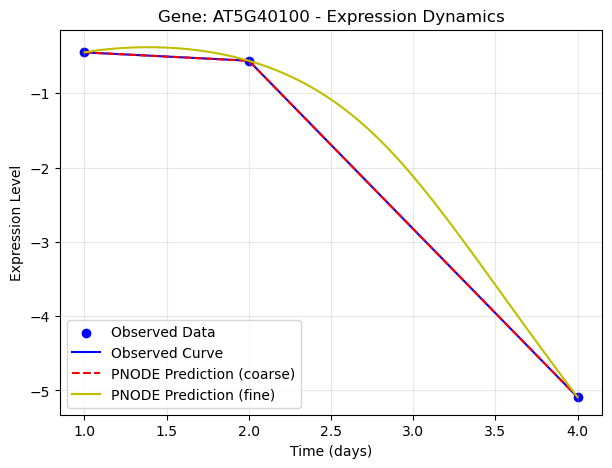

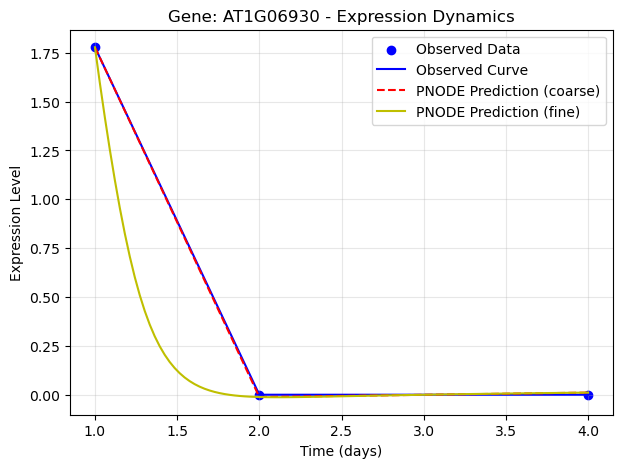

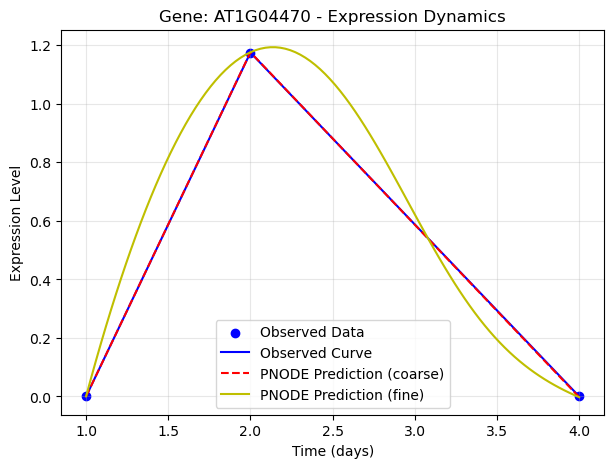

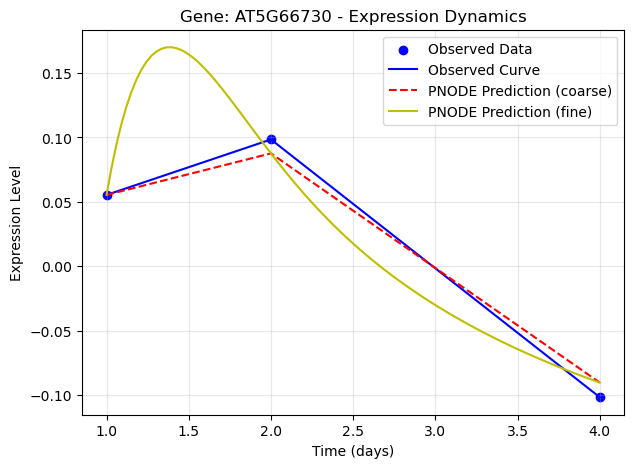

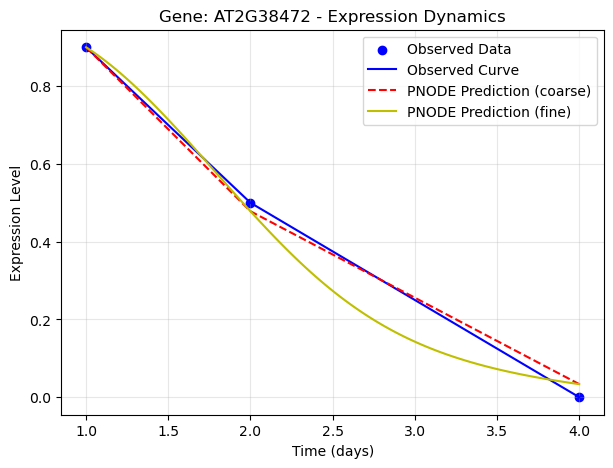

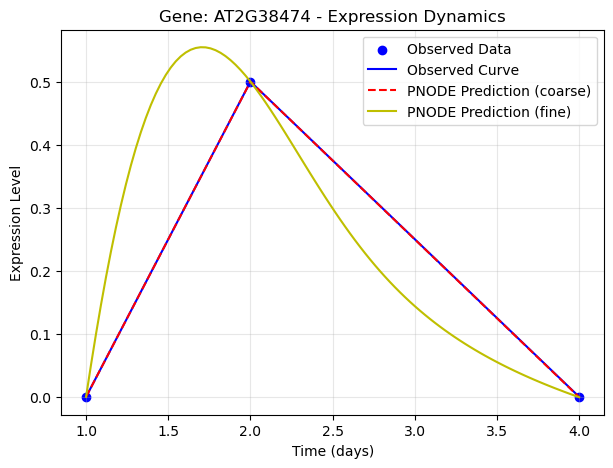

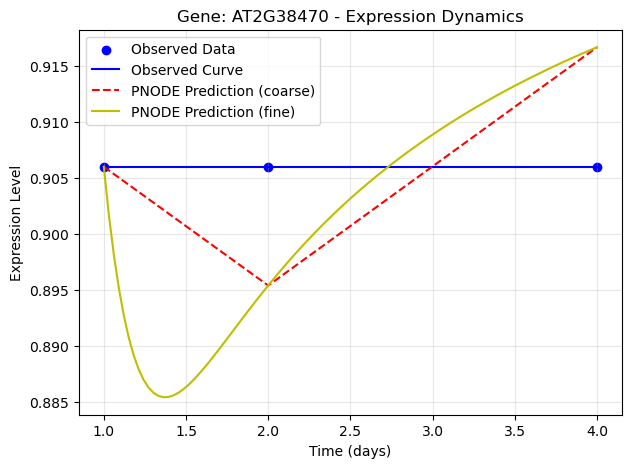

In [12]:

##############################################################################
# Plot Training Curves
##############################################################################

plt.figure(figsize=(10, 6))
for i, losses in enumerate(all_losses):
    plt.plot(losses, label=f"Gene {gene_ids.iloc[i]}")
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss for Each Gene (Parameterized Neural ODE)')
plt.legend()
plt.grid(True)
plt.show()

##############################################################################
# Evaluate and Visualize Predictions
##############################################################################

fine_t = torch.linspace(1, 4, steps=100)
with torch.no_grad():
    for i, gene_id in enumerate(gene_ids):
        model = neural_ode_models[i]
        y0 = gene_data_tensor[i, 0].unsqueeze(0)
        preds_coarse = odeint(model, y0, time_tensor).squeeze().numpy()
        preds_fine = odeint(model, y0, fine_t).squeeze().numpy()
        
        plt.figure(figsize=(7, 5))
        plt.scatter(time_points, gene_data_tensor[i].numpy(), c='b', label="Observed Data")
        plt.plot(time_points, gene_data_tensor[i].numpy(), 'b-', label="Observed Curve")
        plt.plot(time_points, preds_coarse, 'r--', label="PNODE Prediction (coarse)")
        plt.plot(fine_t.numpy(), preds_fine, 'y-', label="PNODE Prediction (fine)")
        plt.title(f"Gene: {gene_id} - Expression Dynamics")
        plt.xlabel("Time (days)")
        plt.ylabel("Expression Level")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()



Training Parameterized Neural ODE model for gene AT5G40100
Gene 0, Epoch 0: Loss = 6.059884
Gene 0, Epoch 2: Loss = 0.952052
Gene 0, Epoch 4: Loss = 0.975369
Gene 0, Epoch 6: Loss = 0.609404
Gene 0, Epoch 8: Loss = 0.528985
Gene 0, Epoch 10: Loss = 0.271665
Gene 0, Epoch 12: Loss = 0.267811
Gene 0, Epoch 14: Loss = 0.144308
Gene 0, Epoch 16: Loss = 0.083628
Gene 0, Epoch 18: Loss = 0.008009
Gene 0, Epoch 20: Loss = 0.088972
Gene 0, Epoch 22: Loss = 0.039186
Gene 0, Epoch 24: Loss = 0.008249
Gene 0, Epoch 26: Loss = 0.046271
Gene 0, Epoch 28: Loss = 0.051991
Gene 0, Epoch 30: Loss = 0.014795
Gene 0, Epoch 32: Loss = 0.013242
Gene 0, Epoch 34: Loss = 0.023442
Gene 0, Epoch 36: Loss = 0.003938
Gene 0, Epoch 38: Loss = 0.006464
Gene 0, Epoch 40: Loss = 0.008787
Gene 0, Epoch 42: Loss = 0.000709
Gene 0, Epoch 44: Loss = 0.007614
Gene 0, Epoch 46: Loss = 0.003165
Gene 0, Epoch 48: Loss = 0.003833
Gene 0, Epoch 50: Loss = 0.004876
Gene 0, Epoch 52: Loss = 0.001437
Gene 0, Epoch 54: Loss = 0.

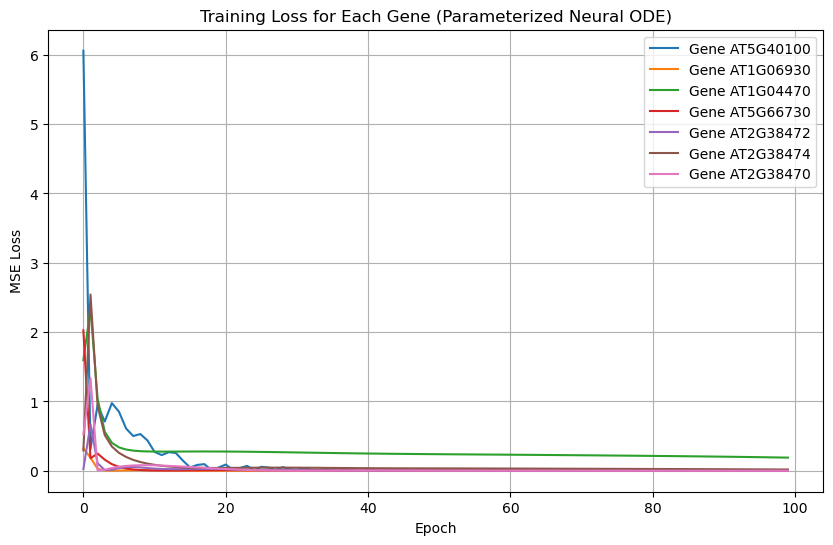

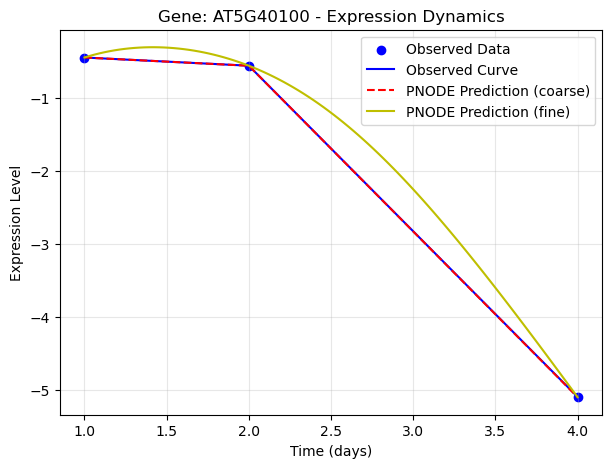

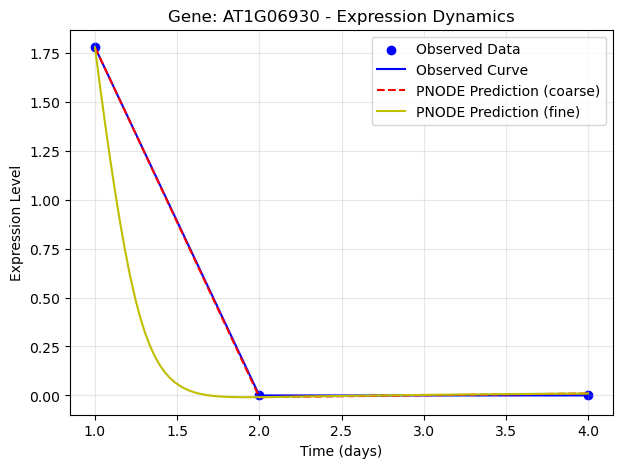

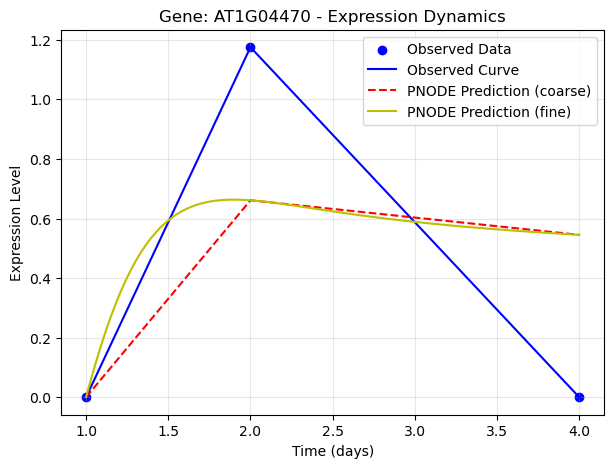

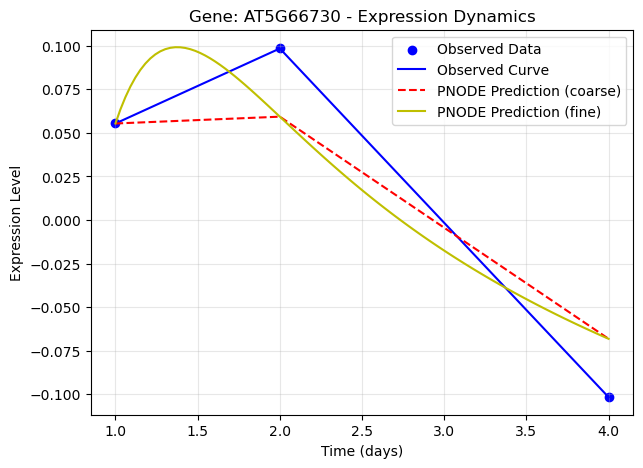

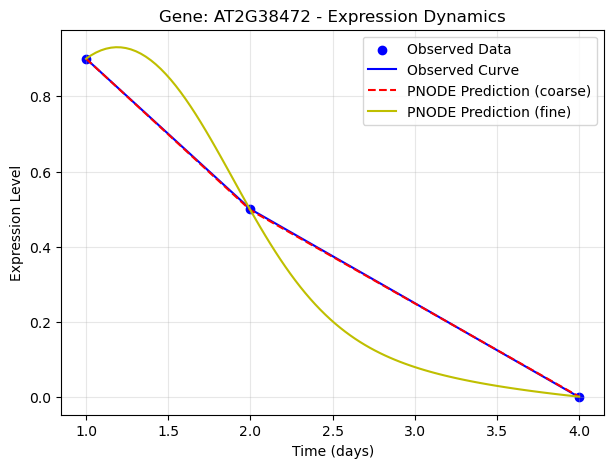

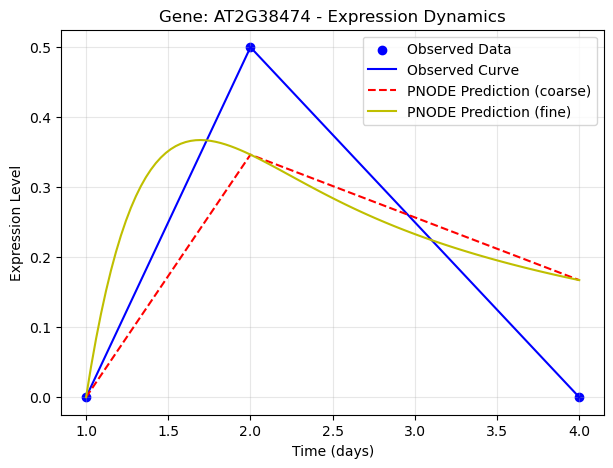

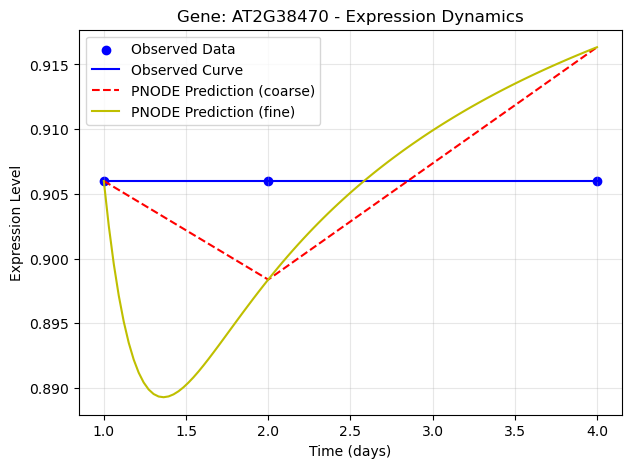

In [20]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
import matplotlib.pyplot as plt

# Load data
# df = pd.read_csv("your_data.csv")  # Uncomment and load your dataset

gene_ids = df['Unnamed: 0']
time_points = np.array([1.0, 2.0, 4.0], dtype=np.float32)
time_tensor = torch.tensor(time_points, dtype=torch.float32)

gene_data = df[["Hpa-NO_1d", "Hpa-NO_2d", "Hpa-NO_4d"]].values
gene_data_tensor = torch.tensor(gene_data, dtype=torch.float32)

##############################################################################
# Parameterized Neural ODE Model
##############################################################################

class ParametricNeuralODE(nn.Module):
    def __init__(self, hidden_dim=32):
        super(ParametricNeuralODE, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden_dim),  # Input: y(t)
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 3)  # Output: alpha, beta, gamma
        )
    
    def forward(self, t, y):
        if len(y.shape) == 1:
            y = y.unsqueeze(1)
        params = self.net(y)  # Predict (α, β, γ)
        alpha, beta, gamma = params[:, 0], params[:, 1], params[:, 2]
        return alpha + beta * y + gamma * t

# Create one model per gene
num_genes = gene_data_tensor.shape[0]
neural_ode_models = nn.ModuleList([ParametricNeuralODE() for _ in range(num_genes)])

##############################################################################
# Training Function
##############################################################################

def train_model(gene_idx, epochs=100,lr=0.01):
    model = neural_ode_models[gene_idx]
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
    
    y_observed = gene_data_tensor[gene_idx]
    y0 = y_observed[0].unsqueeze(0)
    losses = []
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        y_pred = odeint(model, y0, time_tensor).squeeze()
        loss = torch.mean((y_pred - y_observed)**2)
        loss.backward()
        optimizer.step()
        scheduler.step()
        losses.append(loss.item())
        
        if epoch % 20== 0:
            print(f"Gene {gene_idx}, Epoch {epoch}: Loss = {loss.item():.6f}")
    
    return losses

##############################################################################
# Train for Each Gene and Save Parameters
##############################################################################

all_losses = []
param_results = []  # To store alpha, beta, gamma for each gene

for i in range(num_genes):
    print(f"\nTraining Parameterized Neural ODE model for gene {gene_ids.iloc[i]}")
    gene_losses = train_model(i)
    all_losses.append(gene_losses)
    
    # Extract parameters after training
    with torch.no_grad():
        model = neural_ode_models[i]
        y_sample = gene_data_tensor[i, 0].unsqueeze(0)  # Use the first time point
        params = model.net(y_sample).squeeze()  # Get alpha, beta, gamma
        alpha, beta, gamma = params[0].item(), params[1].item(), params[2].item()
        param_results.append([gene_ids.iloc[i], alpha, beta, gamma])

# Convert parameters to a DataFrame
param_df = pd.DataFrame(param_results, columns=['Gene', 'Alpha', 'Beta', 'Gamma'])
print("\nLearned Parameters for Each Gene:")
print(param_df)

##############################################################################
# Plot Training Curves
##############################################################################

plt.figure(figsize=(10, 6))
for i, losses in enumerate(all_losses):
    plt.plot(losses, label=f"Gene {gene_ids.iloc[i]}")
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss for Each Gene (Parameterized Neural ODE)')
plt.legend()
plt.grid(True)
plt.show()

##############################################################################
# Evaluate and Visualize Predictions
##############################################################################

fine_t = torch.linspace(1, 4, steps=100)
with torch.no_grad():
    for i, gene_id in enumerate(gene_ids):
        model = neural_ode_models[i]
        y0 = gene_data_tensor[i, 0].unsqueeze(0)
        preds_coarse = odeint(model, y0, time_tensor).squeeze().numpy()
        preds_fine = odeint(model, y0, fine_t).squeeze().numpy()
        
        plt.figure(figsize=(7, 5))
        plt.scatter(time_points, gene_data_tensor[i].numpy(), c='b', label="Observed Data")
        plt.plot(time_points, gene_data_tensor[i].numpy(), 'b-', label="Observed Curve")
        plt.plot(time_points, preds_coarse, 'r--', label="PNODE Prediction (coarse)")
        plt.plot(fine_t.numpy(), preds_fine, 'y-', label="PNODE Prediction (fine)")
        plt.title(f"Gene: {gene_id} - Expression Dynamics")
        plt.xlabel("Time (days)")
        plt.ylabel("Expression Level")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

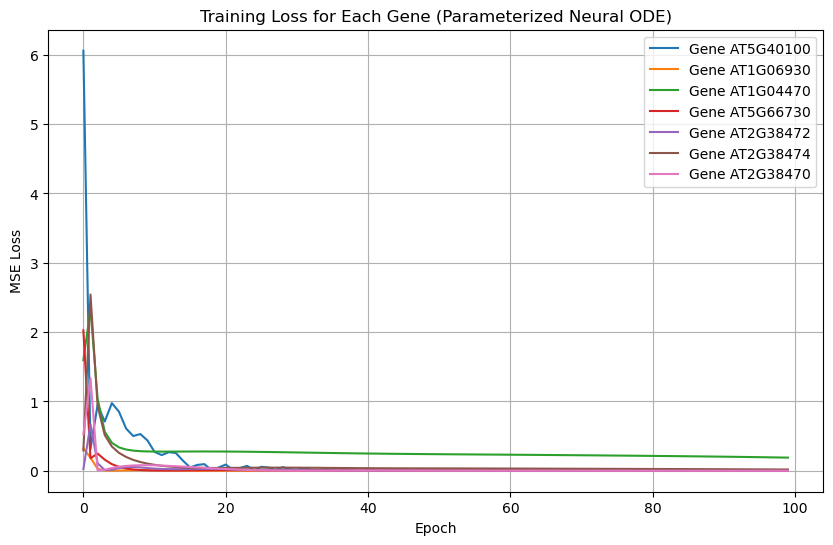

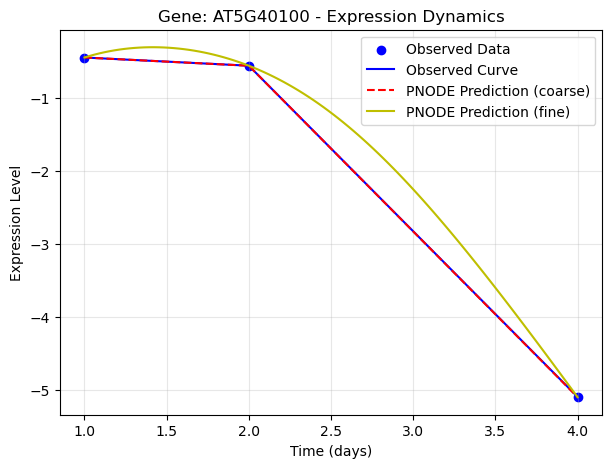

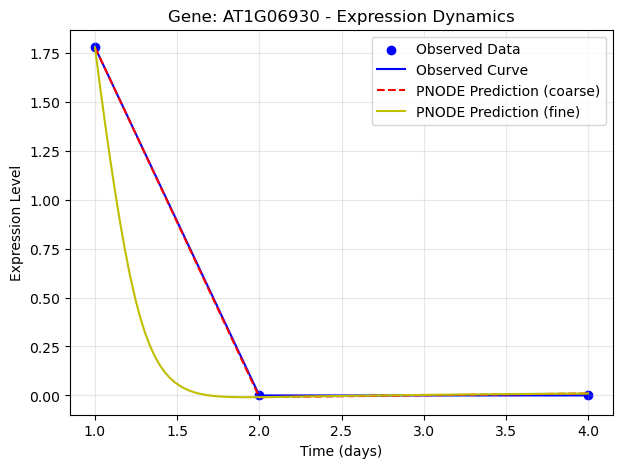

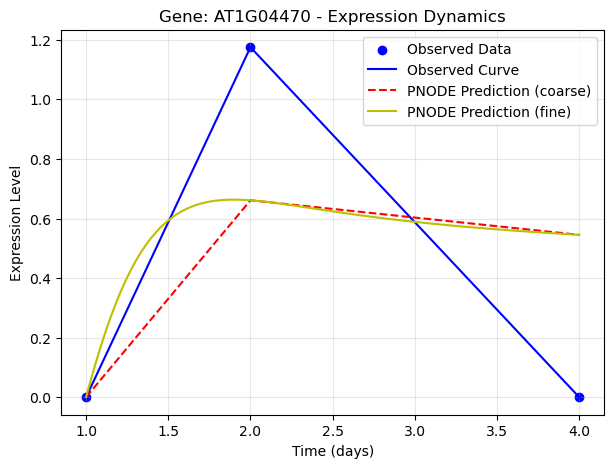

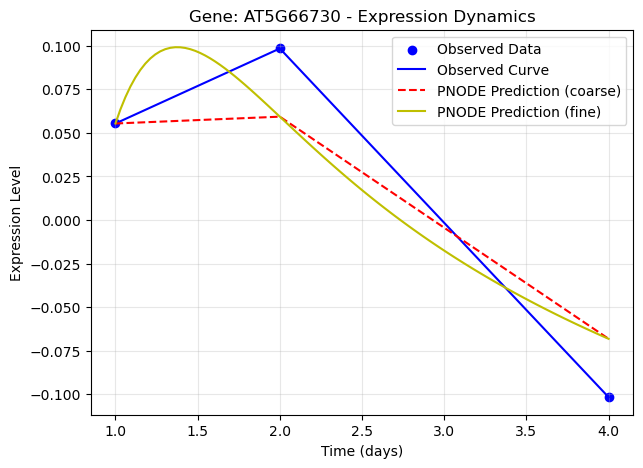

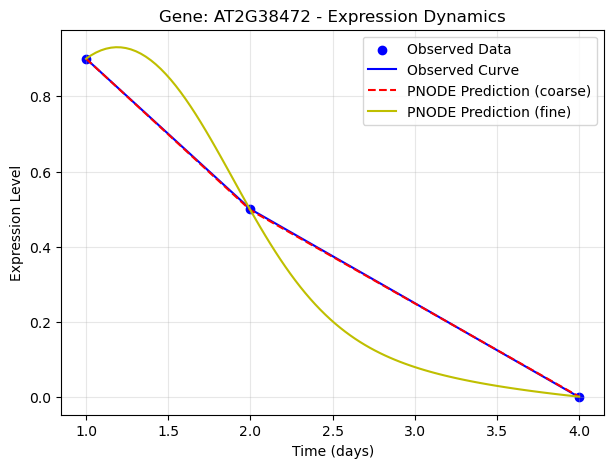

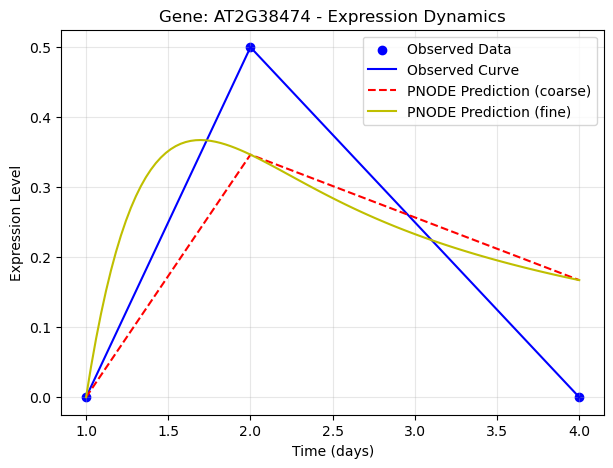

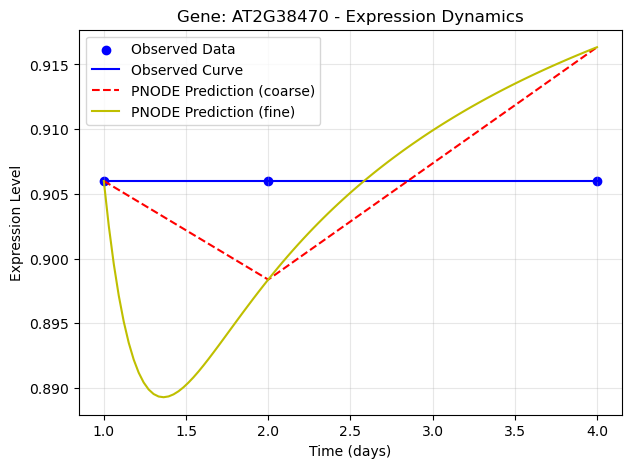

In [22]:

##############################################################################
# Plot Training Curves
##############################################################################

plt.figure(figsize=(10, 6))
for i, losses in enumerate(all_losses):
    plt.plot(losses, label=f"Gene {gene_ids.iloc[i]}")
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss for Each Gene (Parameterized Neural ODE)')
plt.legend()
plt.grid(True)
plt.show()

##############################################################################
# Evaluate and Visualize Predictions
##############################################################################

fine_t = torch.linspace(1, 4, steps=100)
with torch.no_grad():
    for i, gene_id in enumerate(gene_ids):
        model = neural_ode_models[i]
        y0 = gene_data_tensor[i, 0].unsqueeze(0)
        preds_coarse = odeint(model, y0, time_tensor).squeeze().numpy()
        preds_fine = odeint(model, y0, fine_t).squeeze().numpy()
        
        plt.figure(figsize=(7, 5))
        plt.scatter(time_points, gene_data_tensor[i].numpy(), c='b', label="Observed Data")
        plt.plot(time_points, gene_data_tensor[i].numpy(), 'b-', label="Observed Curve")
        plt.plot(time_points, preds_coarse, 'r--', label="PNODE Prediction (coarse)")
        plt.plot(fine_t.numpy(), preds_fine, 'y-', label="PNODE Prediction (fine)")
        plt.title(f"Gene: {gene_id} - Expression Dynamics")
        plt.xlabel("Time (days)")
        plt.ylabel("Expression Level")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Original data (example structure)
original_data = pd.DataFrame({
    "Unnamed: 0": ["AT5G40100", "AT1G06930", "AT1G04470", "AT5G66730", "AT2G38472", "AT2G38474", "AT2G38470"],
    "Hpa-NO_1d": [-0.447960, 1.778359, 0.000000, 0.055375, 0.900000, 0.000000, 0.906000],
    "Hpa-NO_2d": [-0.560155, 0.000000, 1.175150, 0.098435, 0.500000, 0.500000, 0.906000],
    "Hpa-NO_4d": [-5.091964, 0.000000, 0.000000, -0.101757, 0.000000, 0.000000, 0.906000]
})

# Extract numerical data for clustering
X = original_data[["Hpa-NO_1d", "Hpa-NO_2d", "Hpa-NO_4d"]].values

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform clustering (e.g., k=4 clusters)
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to the original data
original_data["cluster"] = clusters

# Generate synthetic data based on cluster centroids
centroids = kmeans.cluster_centers_
centroids_original = scaler.inverse_transform(centroids)  # Transform centroids back to original scale

# Number of synthetic samples per cluster
num_synthetic_samples_per_cluster = 4

# Generate synthetic data
synthetic_data = []
for cluster_idx, centroid in enumerate(centroids_original):
    # Add random noise around the centroid to generate synthetic points
    noise = np.random.normal(scale=0.2, size=(num_synthetic_samples_per_cluster, 3))  # Adjust scale for noise level
    cluster_synthetic_points = centroid + noise
    for point in cluster_synthetic_points:
        synthetic_data.append({
            "Unnamed: 0": f"SYNTHETIC_{cluster_idx}_{np.random.randint(1000, 9999)}",
            "Hpa-NO_1d": point[0],
            "Hpa-NO_2d": point[1],
            "Hpa-NO_4d": point[2],
            "cluster": cluster_idx
        })

# Convert synthetic data to DataFrame
synthetic_df = pd.DataFrame(synthetic_data)

# Combine original and synthetic data for comparison
combined_data = pd.concat([original_data, synthetic_df], ignore_index=True)

# Print synthetic data
print("Synthetic Data:")
print(synthetic_df)

# Print combined data
print("\nCombined Data:")
print(combined_data)

# Visualize the clusters in 3D parameter space
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot original data
scatter_original = ax.scatter(
    original_data["Hpa-NO_1d"], original_data["Hpa-NO_2d"], original_data["Hpa-NO_4d"],
    c=original_data["cluster"], cmap='viridis', s=100, label="Original Data"
)

# Plot synthetic data
scatter_synthetic = ax.scatter(
    synthetic_df["Hpa-NO_1d"], synthetic_df["Hpa-NO_2d"], synthetic_df["Hpa-NO_4d"],
    c=synthetic_df["cluster"], cmap='viridis', s=50, alpha=0.6, label="Synthetic Data"
)

ax.set_xlabel("Hpa-NO_1d")
ax.set_ylabel("Hpa-NO_2d")
ax.set_zlabel("Hpa-NO_4d")
ax.set_title("Clustering of Original and Synthetic Data")
plt.colorbar(scatter_original, ax=ax, label="Cluster")
plt.legend()
plt.show()

Synthetic Point 0:
  Actual Derivative: [-0.34432   -0.9490575 -2.1585325]
  Predicted Derivative: [ 0.71055287 -0.67668578 -1.30965938]
  Satisfies Model: False

Synthetic Point 1:
  Actual Derivative: [-0.396208 -1.005107 -2.222905]
  Predicted Derivative: [ 0.64567964 -0.71093461 -1.26792265]
  Satisfies Model: False



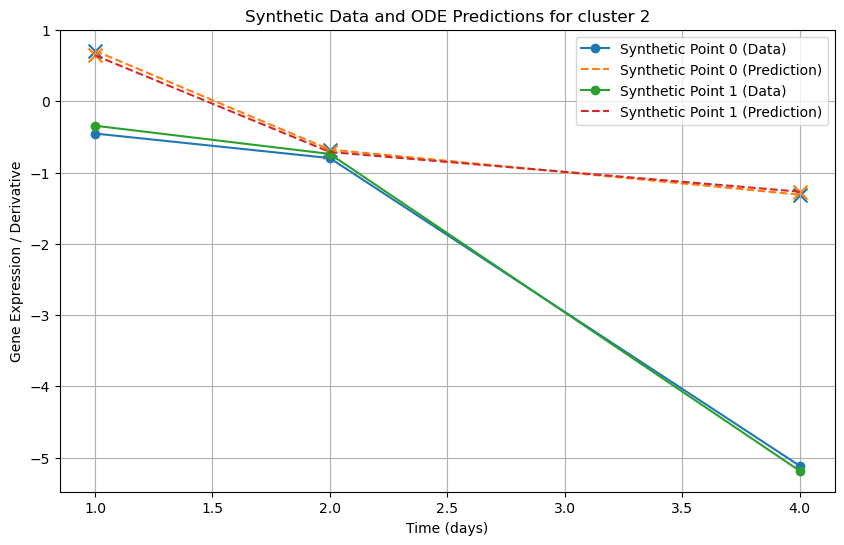

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Given parameters for cluster 2


alpha = 2.034333
beta =  -0.590202
gamma =  -1.590457

# Synthetic data points in cluster 2
# synthetic_cluster_2 = pd.DataFrame({
#     "Hpa-NO_1d": [-0.451840, -0.341923, -0.453931, -0.571841],
#     "Hpa-NO_2d": [-0.796160, -0.738131, -0.386800, -0.574107]
#     "Hpa-NO_4d": [-5.113225, -5.183941, -5.105513, -5.057426]
# })
synthetic_cluster_2 = pd.DataFrame({
    "Hpa-NO_1d": [-0.451840, -0.341923, ],
    "Hpa-NO_2d": [-0.796160, -0.738131, ],
    "Hpa-NO_4d": [-5.113225, -5.183941,   ]
})


# Time points corresponding to the columns
time_points = np.array([1.0, 2.0, 4.0])  # Day 1, Day 2, Day 4

# Function to compute the ODE prediction
def compute_ode_prediction(y, t, alpha, beta, gamma):
    return alpha + beta * y + gamma * t

# Check if the synthetic data satisfies the ODE model
results = []
for index, row in synthetic_cluster_2.iterrows():
    y_values = row.values  # Extract y(t) values
    dy_dt_actual = np.gradient(y_values, time_points)  # Compute actual derivative using finite differences
    dy_dt_predicted = compute_ode_prediction(y_values, time_points, alpha, beta, gamma)  # Predicted derivative
    satisfies_model = np.allclose(dy_dt_actual, dy_dt_predicted, atol=0.1)  # Check if actual ≈ predicted
    results.append({
        "Synthetic Point": index,
        "Actual Derivative": dy_dt_actual,
        "Predicted Derivative": dy_dt_predicted,
        "Satisfies Model": satisfies_model
    })

# Display results
for result in results:
    print(f"Synthetic Point {result['Synthetic Point']}:")
    print(f"  Actual Derivative: {result['Actual Derivative']}")
    print(f"  Predicted Derivative: {result['Predicted Derivative']}")
    print(f"  Satisfies Model: {result['Satisfies Model']}")
    print()

# Plot the synthetic data and predictions
plt.figure(figsize=(10, 6))
for index, row in synthetic_cluster_2.iterrows():
    y_values = row.values  # Extract y(t) values
    dy_dt_predicted = compute_ode_prediction(y_values, time_points, alpha, beta, gamma)  # Predicted derivative

    # Plot synthetic data
    plt.plot(time_points, y_values, 'o-', label=f"Synthetic Point {index} (Data)")

    # Plot predicted values
    plt.plot(time_points, dy_dt_predicted, '--', label=f"Synthetic Point {index} (Prediction)")
    
    plt.scatter(time_points, dy_dt_predicted, marker='x', s=100)
plt.xlabel("Time (days)")
plt.ylabel("Gene Expression / Derivative")
plt.title("Synthetic Data and ODE Predictions for cluster 2")
plt.legend()
plt.grid(True)
plt.show()